#--- BƯỚC 1: THIẾT LẬP MÔI TRƯỜNG VÀ CÀI ĐẶT THƯ VIỆN ---

In [1]:
#@title THIẾT LẬP MÔI TRƯỜNG VÀ CÀI ĐẶT THƯ VIỆN

import os
import pandas as pd
import numpy as np
import json
import pickle
from sklearn.model_selection import train_test_split
import random
import torch
from tqdm.auto import tqdm # Để hiển thị tiến độ

print("1. Thiết lập môi trường và cài đặt thư viện...")

# 1.1. Cài đặt các thư viện cần thiết
!pip install transformers underthesea sentence-transformers faiss-cpu rank_bm25 accelerate datasets evaluate -q
print("Đã cài đặt các thư viện.")

# 1.2. Kiểm tra và import faiss
try:
    import faiss
    print(f"faiss đã được cài đặt, phiên bản: {faiss.__version__}")
except ImportError:
    print("Lỗi: faiss chưa được cài đặt. Vui lòng thử cài đặt lại bằng '!pip install faiss-cpu'.")
    exit()

from sentence_transformers import SentenceTransformer
from rank_bm25 import BM25Okapi

# 1.3. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
print("Đã mount Google Drive.")

# 1.4. Định nghĩa đường dẫn dự án và tạo thư mục
PROJECT_DIR = '/content/drive/MyDrive/Legal_QA_HRAG_Project'
PROCESSED_DATA_DIR = os.path.join(PROJECT_DIR, 'processed_data')
EMBEDDINGS_DIR = os.path.join(PROJECT_DIR, 'embeddings')
RETRIEVAL_MODELS_DIR = os.path.join(PROJECT_DIR, 'retrieval_models')
TRAINED_MODELS_DIR = os.path.join(PROJECT_DIR, 'trained_models')
DATASET_DIR = os.path.join(PROJECT_DIR, 'dataset')

os.makedirs(PROJECT_DIR, exist_ok=True)
os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)
os.makedirs(EMBEDDINGS_DIR, exist_ok=True)
os.makedirs(RETRIEVAL_MODELS_DIR, exist_ok=True)
os.makedirs(TRAINED_MODELS_DIR, exist_ok=True)
os.makedirs(DATASET_DIR, exist_ok=True)

os.chdir(PROJECT_DIR) # Di chuyển vào thư mục dự án
print(f"Đã chuyển đến thư mục dự án: {PROJECT_DIR}")

# 1.5. Kiểm tra GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Thiết bị đang sử dụng: {device}")
!nvidia-smi

1. Thiết lập môi trường và cài đặt thư viện...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 87.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.1 MB/s eta 0:00:00
 

#--- BƯỚC 2: CHUẨN BỊ DỮ LIỆU ---

In [ ]:
#@title Xử lý token >512 và xuống dòng
import pandas as pd
import os
import gc # Để quản lý bộ nhớ

# --- Cấu hình ---
# Đường dẫn tệp đầu vào và đầu ra
INPUT_DF_PATH = "/content/drive/MyDrive/Legal_QA_HRAG_Project/dataset/combined_legal_qa.csv"
FINAL_CLEANED_DF_PATH = "/content/drive/MyDrive/Legal_QA_HRAG_Project/dataset/cleaned_legal_combined_legal_qa.csv"

# Giới hạn ký tự mục tiêu cho ngữ cảnh
MAX_CONTEXT_CHAR_LENGTH = 500 # Giới hạn ký tự ngữ cảnh bạn đã chỉ định

# --- Tải tập dữ liệu ---
print(f"Đang tải DataFrame từ: {INPUT_DF_PATH}...")
try:
    df = pd.read_csv(INPUT_DF_PATH)
    print(f"Kích thước DataFrame ban đầu: {len(df)} hàng.")
    if df.empty:
        raise ValueError("DataFrame đã tải trống.")
except FileNotFoundError:
    print(f"LỖI: Không tìm thấy tệp tại {INPUT_DF_PATH}. Vui lòng kiểm tra đường dẫn.")
    exit()
except ValueError as e:
    print(f"LỖI: {e}")
    exit()
except Exception as e:
    print(f"LỖI khi tải DataFrame: {e}")
    exit()

# --- Làm sạch DataFrame cơ bản ---
initial_rows = len(df)
df.dropna(subset=['question', 'context'], inplace=True) # Xóa các hàng có NaN trong các cột này
df['question'] = df['question'].astype(str).str.strip()
df['context'] = df['context'].astype(str).str.strip()

# Đảm bảo cột 'answer' tồn tại và xử lý NaN nếu có
if 'answer' in df.columns:
    df.dropna(subset=['answer'], inplace=True)
    df['answer'] = df['answer'].astype(str).str.strip()
else:
    print("CẢNH BÁO: Cột 'answer' không tồn tại trong DataFrame. Bỏ qua kiểm tra xuống dòng cho cột này.")

rows_after_initial_cleaning = len(df)
if rows_after_initial_cleaning < initial_rows:
    print(f"Làm sạch cơ bản hoàn tất: {initial_rows - rows_after_initial_cleaning} hàng đã bị xóa. Kích thước hiện tại: {rows_after_initial_cleaning} hàng.")
initial_rows = rows_after_initial_cleaning # Cập nhật số hàng ban đầu cho các bước tiếp theo

if df.empty:
    print("DataFrame trống sau khi làm sạch cơ bản. Không có dữ liệu để xử lý.")
    exit()

# --- Xóa hàng nếu có ký tự xuống dòng trong 'question', 'context', hoặc 'answer' ---
print("Đang kiểm tra và xóa các hàng có ký tự xuống dòng trong 'question', 'context', hoặc 'answer'...")

# Mẫu regex để tìm ký tự xuống dòng
newline_pattern = r'[\n\r]'

# Tạo mặt nạ boolean cho các hàng chứa xuống dòng trong bất kỳ cột nào
mask_newlines_in_question = df['question'].str.contains(newline_pattern, regex=True)
mask_newlines_in_context = df['context'].str.contains(newline_pattern, regex=True)
mask_newlines_in_answer = False
if 'answer' in df.columns: # Chỉ kiểm tra cột 'answer' nếu nó tồn tại
    mask_newlines_in_answer = df['answer'].str.contains(newline_pattern, regex=True)

# Kết hợp các mặt nạ: True nếu có xuống dòng trong bất kỳ cột nào
rows_with_newlines = mask_newlines_in_question | mask_newlines_in_context | mask_newlines_in_answer

# Lọc DataFrame để chỉ giữ lại các hàng KHÔNG chứa xuống dòng
df = df[~rows_with_newlines].copy()

rows_removed_by_newline_check = initial_rows - len(df)
if rows_removed_by_newline_check > 0:
    print(f"Đã xóa {rows_removed_by_newline_check} hàng do chứa ký tự xuống dòng trong 'question', 'context', hoặc 'answer'.")

rows_after_newline_check = len(df)
initial_rows = rows_after_newline_check # Cập nhật số hàng ban đầu cho các bước tiếp theo

if df.empty:
    print("DataFrame trống sau khi xóa hàng có xuống dòng. Không có dữ liệu để xử lý.")
    exit()

# --- Xóa hàng nếu 'context' chứa dấu gạch nối, dấu cộng hoặc nội dung trong ngoặc đơn ---
print("Đang kiểm tra và xóa các hàng có 'context' chứa dấu gạch nối, dấu cộng hoặc nội dung trong ngoặc đơn...")

# Định nghĩa các mẫu regex cần tìm để xóa hàng trong 'context'
patterns_to_remove_rows_in_context = r'[-+]|\(.*?\)'

# Tạo một mặt nạ boolean để xác định các hàng KHÔNG chứa các mẫu này trong 'context'
rows_to_keep_after_pattern_check = ~df['context'].str.contains(patterns_to_remove_rows_in_context, regex=True)

# Lọc DataFrame để chỉ giữ lại các hàng không chứa các mẫu đã chỉ định
df = df[rows_to_keep_after_pattern_check].copy()

rows_removed_by_pattern = initial_rows - len(df)
if rows_removed_by_pattern > 0:
    print(f"Đã xóa {rows_removed_by_pattern} hàng do 'context' chứa các mẫu không mong muốn (dấu gạch nối, dấu cộng, ngoặc đơn).")

rows_after_pattern_check = len(df)
initial_rows = rows_after_pattern_check # Cập nhật số hàng ban đầu cho các bước tiếp theo

if df.empty:
    print("DataFrame trống sau khi xóa hàng có mẫu không mong muốn trong 'context'. Không có dữ liệu để xử lý.")
    exit()

# --- Chuẩn hóa cột 'context' còn lại (xóa xuống dòng, khoảng trắng thừa) ---
# Bước này vẫn cần thiết để đảm bảo không còn khoảng trắng thừa nào sau các thao tác lọc.
print("Đang chuẩn hóa cột 'context' còn lại (xóa khoảng trắng thừa)...")

# Thay thế tất cả các loại khoảng trắng (bao gồm xuống dòng) bằng một khoảng trắng duy nhất
df['context'] = df['context'].str.replace(r'\s+', ' ', regex=True)

# Loại bỏ khoảng trắng ở đầu và cuối chuỗi
df['context'] = df['context'].str.strip()

# Sau các bước lọc, có thể có các hàng trống mới được tạo ra nếu chỉ có khoảng trắng
df = df[df['question'] != ''] # Xóa các hàng có câu hỏi trống
df = df[df['context'] != ''] # Xóa các hàng có ngữ cảnh trống
if 'answer' in df.columns:
    df = df[df['answer'] != ''] # Xóa các hàng có câu trả lời trống

rows_after_final_strip = len(df)
if rows_after_final_strip < initial_rows:
    print(f"Đã xóa thêm {initial_rows - rows_after_final_strip} hàng do trống sau khi chuẩn hóa.")
initial_rows = rows_after_final_strip

if df.empty:
    print("DataFrame trống sau khi làm sạch cuối cùng. Không có dữ liệu để xử lý.")
    exit()

# --- Xử lý và xóa các hàng dựa trên giới hạn ký tự ngữ cảnh ---
print(f"Bắt đầu kiểm tra và xóa các hàng có độ dài ký tự 'context' vượt quá {MAX_CONTEXT_CHAR_LENGTH}...")

rows_to_keep = []
dropped_count = 0

for idx, row in df.iterrows():
    context = str(row['context'])

    # Lấy độ dài ký tự của ngữ cảnh CHỈ
    num_chars = len(context)

    if num_chars <= MAX_CONTEXT_CHAR_LENGTH:
        rows_to_keep.append(idx)
    else:
        dropped_count += 1
        # print(f"    Đã xóa hàng {idx}: độ dài ngữ cảnh {num_chars} > {MAX_CONTEXT_CHAR_LENGTH}") # Bỏ ghi chú để gỡ lỗi

# Tạo DataFrame mới chỉ với các hàng được giữ lại
df_cleaned = df.loc[rows_to_keep].copy()

print(f"Tổng số hàng ban đầu (sau các bước lọc trước): {initial_rows}")
print(f"Số hàng đã bị xóa do 'context' dài (theo số ký tự): {dropped_count}")
print(f"Kích thước DataFrame cuối cùng: {len(df_cleaned)} hàng.")

# --- Kiểm tra cuối cùng về độ dài ký tự ngữ cảnh ---
print("\nĐang thực hiện kiểm tra cuối cùng về độ dài ký tự 'context' tối đa trong DataFrame đã làm sạch...")
max_context_chars_final = 0
for idx, row in df_cleaned.iterrows():
    max_context_chars_final = max(max_context_chars_final, len(str(row['context'])))

print(f"Độ dài ký tự 'context' tối đa sau khi làm sạch: {max_context_chars_final}")
if max_context_chars_final > MAX_CONTEXT_CHAR_LENGTH:
    print(f"CẢNH BÁO: Một số hàng vẫn có độ dài ký tự 'context' vượt quá {MAX_CONTEXT_CHAR_LENGTH}. Vui lòng kiểm tra lại logic.")
else:
    print(f"Tất cả các mục 'context' đều nằm trong giới hạn {MAX_CONTEXT_CHAR_LENGTH} ký tự.")


# --- Lưu DataFrame đã làm sạch ---
print(f"Đang lưu DataFrame đã làm sạch vào: {FINAL_CLEANED_DF_PATH}, kích thước: {len(df_cleaned)} hàng.")
try:
    df_cleaned.to_csv(FINAL_CLEANED_DF_PATH, index=False)
    print("DataFrame đã lưu thành công.")
except Exception as e:
    print(f"LỖI: Không thể lưu DataFrame vào {FINAL_CLEANED_DF_PATH}. Vui lòng kiểm tra quyền ghi hoặc đường dẫn.")
    print(e)

# --- Giải phóng bộ nhớ ---
del df
del df_cleaned
gc.collect()
print("Bộ nhớ đã được giải phóng.")

print("\n--- Hoàn tất làm sạch dựa trên ký tự ngữ cảnh ---")


Đang tải DataFrame từ: /content/drive/MyDrive/Legal_QA_HRAG_Project/dataset/combined_legal_qa.csv...
Kích thước DataFrame ban đầu: 4730 hàng.
Đang kiểm tra và xóa các hàng có ký tự xuống dòng trong 'question', 'context', hoặc 'answer'...
Đã xóa 124 hàng do chứa ký tự xuống dòng trong 'question', 'context', hoặc 'answer'.
Đang kiểm tra và xóa các hàng có 'context' chứa dấu gạch nối, dấu cộng hoặc nội dung trong ngoặc đơn...
Đã xóa 156 hàng do 'context' chứa các mẫu không mong muốn (dấu gạch nối, dấu cộng, ngoặc đơn).
Đang chuẩn hóa cột 'context' còn lại (xóa khoảng trắng thừa)...
Bắt đầu kiểm tra và xóa các hàng có độ dài ký tự 'context' vượt quá 500...
Tổng số hàng ban đầu (sau các bước lọc trước): 4450
Số hàng đã bị xóa do 'context' dài (theo số ký tự): 41
Kích thước DataFrame cuối cùng: 4409 hàng.

Đang thực hiện kiểm tra cuối cùng về độ dài ký tự 'context' tối đa trong DataFrame đã làm sạch...
Độ dài ký tự 'context' tối đa sau khi làm sạch: 496
Tất cả các mục 'context' đều nằm trong

In [ ]:
#@title CHUẨN BỊ DỮ LIỆU

print("\n2. Chuẩn bị dữ liệu...")

# Đường dẫn tới file dataset của bạn
data_path = os.path.join(DATASET_DIR, 'cleaned_legal_combined_legal_qa.csv') #combined_legal_qa copus-legal-vi

# Kiểm tra và tải dữ liệu
try:
    df = pd.read_csv(data_path)
    print(f"Đã tải dữ liệu từ {data_path}. Kích thước: {len(df)} hàng.")
except FileNotFoundError:
    print(f"LỖI: Không tìm thấy file {data_path}. Vui lòng tải file 'cleaned_legal_combined_legal_qa.csv' lên thư mục '{DATASET_DIR}' trên Google Drive.")

# Thêm ID duy nhất cho mỗi context
df['context_id'] = [f'doc_{i}' for i in range(len(df))]

print("Dữ liệu được sử dụng:")
print(df.head())

# Lưu DataFrame đã xử lý
processed_data_file = os.path.join(PROCESSED_DATA_DIR, 'legal_qa_processed_data.csv')
df.to_csv(processed_data_file, index=False)
print(f"Đã lưu DataFrame đã xử lý tại: {processed_data_file}")


2. Chuẩn bị dữ liệu...
Đã tải dữ liệu từ /content/drive/MyDrive/Legal_QA_HRAG_Project/dataset/cleaned_legal_combined_legal_qa.csv. Kích thước: 4409 hàng.
Dữ liệu được sử dụng:
                                             context  \
0  Quyền bề mặt chấm dứt khi chủ thể có quyền bề ...   
1  Quyền sở hữu được xác lập khi tạo thành tài sả...   
2  Hợp đồng hợp tác có nội dung về quyền, nghĩa v...   
3  Chủ sở hữu có quyền chiếm hữu, sử dụng, định đ...   
4  Người cố ý tố giác, báo tin giả cho lực lượng ...   

                                            question  \
0  Khi nào quyền bề mặt chấm dứt vì liên quan đến...   
1  Quyền sở hữu có được xác lập khi tài sản mới đ...   
2  Hợp đồng hợp tác cần lưu ý gì khi xác định quy...   
3  Chủ sở hữu có quyền gì đối với tài sản thuộc s...   
4  Báo tin giả cho lực lượng chức năng nhằm hạ uy...   

                                              answer context_id  
0  Quyền bề mặt chấm dứt khi chủ thể có quyền bề ...      doc_0  
1  Quyền sở hữu đ

#--- BƯỚC 3: TIỀN XỬ LÝ DỮ LIỆU VÀ LẬP CHỈ MỤC ---

In [ ]:
#@title TIỀN XỬ LÝ DỮ LIỆU VÀ LẬP CHỈ MỤC

from sentence_transformers import SentenceTransformer
import faiss
from rank_bm25 import BM25Okapi
import os
import pickle
import json
from underthesea import word_tokenize # TỐI ƯU HÓA: Để token hóa tiếng Việt cho BM25

# --- Cấu hình thư mục (Đảm bảo các biến này được định nghĩa ở nơi khác trong môi trường của bạn) ---
# Ví dụ:
# RETRIEVAL_MODELS_DIR = "/path/to/your/retrieval_models"
# EMBEDDINGS_DIR = "/path/to/your/embeddings"
# PROCESSED_DATA_DIR = "/path/to/your/processed_data"
# TRAINED_MODELS_DIR = "/path/to/your/trained_models"

# Đảm bảo biến 'df' đã được tải và làm sạch từ script trước đó
# Ví dụ: df = pd.read_csv(FINAL_CLEANED_DF_PATH)

print("\n3. Bắt đầu lập chỉ mục cho Retrieval...")

# 3.1. Tải hoặc tải lại Embedding Model
# Mô hình nhỏ gọn cho Colab Free: 'distiluse-base-multilingual-cased-v2'
embedding_model_name = 'distiluse-base-multilingual-cased-v2'
embedding_model_path = os.path.join(TRAINED_MODELS_DIR, 'embedding_model_retrieval')

try:
    print(f"Đang tải lại mô hình Embedding từ: {embedding_model_path}")
    embedding_model = SentenceTransformer(embedding_model_path)
    print("Đã tải lại mô hình Embedding thành công.")
except Exception as e:
    print(f"Không tìm thấy mô hình Embedding đã lưu: {e}. Đang tải và lưu mới...")
    embedding_model = SentenceTransformer(embedding_model_name)
    embedding_model.save(embedding_model_path)
    print(f"Đã tải và lưu mô hình Embedding mới tại: {embedding_model_path}")

# Lấy contexts từ DataFrame đã được làm sạch
# Đảm bảo cột 'context' trong df đã được tiền xử lý bằng hàm normalize_text
# (như trong script làm sạch dữ liệu của bạn)
contexts = df['context'].tolist()
context_ids = df['context_id'].tolist()

# 3.2. Tạo Embeddings và Lập chỉ mục Vector (FAISS)
faiss_index_path = os.path.join(EMBEDDINGS_DIR, 'faiss_index.bin')
context_map_path = os.path.join(PROCESSED_DATA_DIR, 'context_map.json')

try:
    faiss_index = faiss.read_index(faiss_index_path)
    with open(context_map_path, 'r', encoding='utf-8') as f:
        context_map = json.load(f)
    print(f"Đã tải lại Faiss index và context map từ: {faiss_index_path}, {context_map_path}")
except Exception as e:
    print(f"Không tìm thấy Faiss index hoặc context map đã lưu: {e}. Đang tạo mới...")
    print(f"Đang tạo {len(contexts)} embeddings cho các context (sẽ mất một thời gian)...")
    context_embeddings = embedding_model.encode(contexts, convert_to_tensor=True, show_progress_bar=True)
    context_embeddings_np = context_embeddings.cpu().numpy()

    embedding_dim = context_embeddings_np.shape[1]
    faiss_index = faiss.IndexFlatL2(embedding_dim)
    faiss_index.add(context_embeddings_np)

    faiss.write_index(faiss_index, faiss_index_path)
    print(f"Đã lưu Faiss index tại: {faiss_index_path}")

    # context_map lưu trữ nội dung đã được tiền xử lý
    context_map = {i: {'context_id': context_ids[i], 'content': contexts[i]} for i in range(len(contexts))}
    with open(context_map_path, 'w', encoding='utf-8') as f:
        json.dump(context_map, f, ensure_ascii=False, indent=4)
    print(f"Đã lưu ánh xạ context tại: {context_map_path}")


# 3.3. Lập chỉ mục BM25
bm25_path = os.path.join(RETRIEVAL_MODELS_DIR, 'bm25_model.pkl')

try:
    with open(bm25_path, 'rb') as f:
        bm25 = pickle.load(f)
    print(f"Đã tải lại mô hình BM25 từ: {bm25_path}")
except Exception as e:
    print(f"Không tìm thấy mô hình BM25 đã lưu: {e}.")
    print(f"Đang tạo mới BM25...")
    # TỐI ƯU HÓA: Sử dụng underthesea.word_tokenize để token hóa corpus cho BM25
    # Điều này đảm bảo tính nhất quán với cách câu hỏi được token hóa trong giai đoạn Retrieval.
    tokenized_corpus = [word_tokenize(doc) for doc in contexts]
    bm25 = BM25Okapi(tokenized_corpus)

    with open(bm25_path, 'wb') as f:
        pickle.dump(bm25, f)
    print(f"Đã lưu mô hình BM25 mới tại: {bm25_path}")

print("--- Hoàn thành Lập chỉ mục ---")


3. Bắt đầu lập chỉ mục cho Retrieval...
Đang tải lại mô hình Embedding từ: /content/drive/MyDrive/Legal_QA_HRAG_Project/trained_models/embedding_model_retrieval
Đã tải lại mô hình Embedding thành công.
Không tìm thấy Faiss index hoặc context map đã lưu: Error in faiss::FileIOReader::FileIOReader(const char*) at /project/faiss/faiss/impl/io.cpp:67: Error: 'f' failed: could not open /content/drive/MyDrive/Legal_QA_HRAG_Project/embeddings/faiss_index.bin for reading: No such file or directory. Đang tạo mới...
Đang tạo 4409 embeddings cho các context (sẽ mất một thời gian)...


Batches:   0%|          | 0/138 [00:00<?, ?it/s]

Đã lưu Faiss index tại: /content/drive/MyDrive/Legal_QA_HRAG_Project/embeddings/faiss_index.bin
Đã lưu ánh xạ context tại: /content/drive/MyDrive/Legal_QA_HRAG_Project/processed_data/context_map.json
Không tìm thấy mô hình BM25 đã lưu: [Errno 2] No such file or directory: '/content/drive/MyDrive/Legal_QA_HRAG_Project/retrieval_models/bm25_model.pkl'.
Đang tạo mới BM25...
Đã lưu mô hình BM25 mới tại: /content/drive/MyDrive/Legal_QA_HRAG_Project/retrieval_models/bm25_model.pkl
--- Hoàn thành Lập chỉ mục ---


#--- BƯỚC 4: GIAI ĐOẠN RETRIEVAL (HYBRID) ---

In [ ]:
!pip install underthesea

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.9 MB/s eta 0:00:00


In [2]:
#@title GIAI ĐOẠN RETRIEVAL (HYBRID)

print("\n4. Bắt đầu Retrieval (Hybrid)...")
import os
import pickle # Để tải BM25
import faiss # Để tải FAISS index
import json # Để tải context_map
import numpy as np # Để xử lý mảng
import re # Để xử lý biểu thức chính quy
from sentence_transformers import SentenceTransformer # Để tải mô hình nhúng
from underthesea import word_tokenize # TỐI ƯU HÓA: Để token hóa tiếng Việt cho BM25
from sentence_transformers.cross_encoder import CrossEncoder # TỐI ƯU HÓA: Để re-ranking

# --- Cấu hình thư mục (Đảm bảo các biến này được định nghĩa ở nơi khác trong môi trường của bạn) ---
# Ví dụ:
# RETRIEVAL_MODELS_DIR = "/path/to/your/retrieval_models"
# EMBEDDINGS_DIR = "/path/to/your/embeddings"
# PROCESSED_DATA_DIR = "/path/to/your/processed_data"
# TRAINED_MODELS_DIR = "/path/to/your/trained_models"

# --- Hàm chuẩn hóa văn bản (Đảm bảo khớp với hàm trong script làm sạch dữ liệu của bạn) ---
# Hàm này sẽ áp dụng cho câu hỏi truy vấn
def normalize_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower() # Chuyển tất cả về chữ thường
    # Loại bỏ các ký tự đặc biệt, dấu câu, ngoại trừ chữ cái, số và khoảng trắng
    #text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip() # Thay thế nhiều khoảng trắng bằng một khoảng trắng và loại bỏ khoảng trắng ở đầu/cuối
    return text

# Biến global để lưu trữ các thành phần retrieval đã tải
bm25 = None
faiss_index = None
context_map = None
embedding_model = None
cross_encoder_model = None # TỐI ƯU HÓA: Biến global cho Cross-Encoder
global_retrieval_components_loaded = False

# Hàm để đảm bảo tất cả các thành phần Retrieval được tải
def ensure_retrieval_components_loaded():
    global bm25, faiss_index, context_map, embedding_model, cross_encoder_model, global_retrieval_components_loaded

    if global_retrieval_components_loaded:
        return

    # Tải và kiểm tra các thành phần
    try:
        # Tải BM25
        bm25_path = os.path.join(RETRIEVAL_MODELS_DIR, 'bm25_model.pkl')
        if not os.path.exists(bm25_path):
            raise FileNotFoundError(f"BM25 model not found at {bm25_path}")
        with open(bm25_path, 'rb') as f:
            bm25 = pickle.load(f)

        # Tải FAISS index
        faiss_index_path = os.path.join(EMBEDDINGS_DIR, 'faiss_index.bin')
        if not os.path.exists(faiss_index_path):
            raise FileNotFoundError(f"FAISS index not found at {faiss_index_path}")
        faiss_index = faiss.read_index(faiss_index_path)

        # Tải context_map
        context_map_path = os.path.join(PROCESSED_DATA_DIR, 'context_map.json')
        if not os.path.exists(context_map_path):
            raise FileNotFoundError(f"Context map not found at {context_map_path}")
        with open(context_map_path, 'r', encoding='utf-8') as f:
            context_map = json.load(f)

        # Tải embedding model (Bi-Encoder)
        embedding_model_path = os.path.join(TRAINED_MODELS_DIR, 'embedding_model_retrieval')
        if not os.path.exists(embedding_model_path):
            raise FileNotFoundError(f"Embedding model not found at {embedding_model_path}")
        embedding_model = SentenceTransformer(embedding_model_path)

        # TỐI ƯU HÓA: Tải Cross-Encoder model cho Re-ranking
        # KHUYẾN NGHỊ: Thay thế bằng một mô hình Cross-Encoder đã được tinh chỉnh cho tiếng Việt
        # Ví dụ: 'cross-encoder/ms-marco-TinyBERT-L-2' là một mô hình tiếng Anh,
        # bạn nên tìm kiếm hoặc tinh chỉnh một mô hình phù hợp với tiếng Việt và lĩnh vực pháp luật.
        cross_encoder_model_name = 'cross-encoder/ms-marco-TinyBERT-L-2' # Placeholder
        cross_encoder_model_path = os.path.join(TRAINED_MODELS_DIR, 'cross_encoder_retrieval')

        try:
            print(f"Đang tải lại mô hình Cross-Encoder từ: {cross_encoder_model_path}")
            cross_encoder_model = CrossEncoder(cross_encoder_model_path)
            print("Đã tải lại mô hình Cross-Encoder thành công.")
        except Exception as e:
            print(f"Không tìm thấy mô hình Cross-Encoder đã lưu: {e}. Đang tải và lưu mới...")
            cross_encoder_model = CrossEncoder(cross_encoder_model_name)
            cross_encoder_model.save(cross_encoder_model_path)
            print(f"Đã tải và lưu mô hình Cross-Encoder mới tại: {cross_encoder_model_path}")

        global_retrieval_components_loaded = True
        print("\n✅ Đã tải thành công tất cả thành phần Retrieval (bao gồm Cross-Encoder).")
    except Exception as e:
        print(f"\n❌ Lỗi tải thành phần Retrieval: {e}. Vui lòng đảm bảo các file đã được tạo và lưu đúng cách.")
        raise # Ném lỗi để dừng lại nếu tải thất bại

# Hàm chính để truy xuất tài liệu
def retrieve_documents(question, top_k_sparse=10, top_k_dense=10, top_k_hybrid=10, rrf_k=60, top_k_rerank=5, content_preview_length=500):
    ensure_retrieval_components_loaded()

    if bm25 is None or faiss_index is None or context_map is None or embedding_model is None or cross_encoder_model is None:
        raise ValueError("Các thành phần Retrieval không được tải đầy đủ. Không thể thực hiện truy xuất.")

    # Chuẩn hóa câu hỏi
    normalized_question = normalize_text(question)

    # 1. Sparse Retrieval (BM25)
    tokenized_question = word_tokenize(normalized_question)
    bm25_scores = bm25.get_scores(tokenized_question)
    sparse_results_indices = np.argsort(bm25_scores)[::-1][:top_k_sparse]

    sparse_ranked_list = []
    for rank, idx in enumerate(sparse_results_indices):
        str_idx = str(idx)
        if str_idx in context_map:
            sparse_ranked_list.append({
                'doc_id': context_map[str_idx]['context_id'],
                'content': context_map[str_idx]['content'],
                'score': bm25_scores[idx],
                'rank': rank + 1
            })

    # 2. Dense Retrieval (Semantic Search)
    question_embedding = embedding_model.encode(normalized_question, convert_to_tensor=True).cpu().numpy().reshape(1, -1)
    D, I = faiss_index.search(question_embedding, top_k_dense)

    dense_ranked_list = []
    for rank, idx in enumerate(I[0]):
        str_idx = str(idx)
        if str_idx in context_map:
            dense_ranked_list.append({
                'doc_id': context_map[str_idx]['context_id'],
                'content': context_map[str_idx]['content'],
                'score': float(D[0][rank]),
                'rank': rank + 1
            })

    # 3. Hybrid Fusion (Reciprocal Rank Fusion - RRF)
    def rrf_score(rank, k=rrf_k):
        return 1 / (k + rank)

    combined_scores = {}
    doc_content_map = {}

    for item in sparse_ranked_list:
        doc_id = item['doc_id']
        combined_scores[doc_id] = combined_scores.get(doc_id, 0) + rrf_score(item['rank'])
        doc_content_map[doc_id] = item['content']

    for item in dense_ranked_list:
        doc_id = item['doc_id']
        combined_scores[doc_id] = combined_scores.get(doc_id, 0) + rrf_score(item['rank'])
        doc_content_map[doc_id] = item['content']

    sorted_hybrid_docs = sorted(combined_scores.items(), key=lambda item: item[1], reverse=True)[:top_k_hybrid]

    # TỐI ƯU HÓA: Chuẩn bị dữ liệu cho Re-ranking
    rerank_candidates = []
    for doc_id, score in sorted_hybrid_docs:
        content = doc_content_map.get(doc_id, "Nội dung không tìm thấy hoặc bị thiếu.")
        rerank_candidates.append({'doc_id': doc_id, 'content': content, 'hybrid_score': score})

    if not rerank_candidates:
        return [] # Không có tài liệu nào để re-rank

    # 4. Re-ranking với Cross-Encoder
    # Tạo các cặp (câu hỏi, nội dung tài liệu) cho Cross-Encoder
    sentence_pairs = [[normalized_question, candidate['content']] for candidate in rerank_candidates]

    # Lấy điểm số từ Cross-Encoder
    # cross_encoder_model.predict trả về logit, cần sigmoid để chuyển thành xác suất nếu mô hình không tự làm
    # Đối với các mô hình Cross-Encoder của Sentence-Transformers, thường trả về điểm số đã được chuẩn hóa.
    rerank_scores = cross_encoder_model.predict(sentence_pairs)

    # Gán điểm số re-rank vào các ứng viên và sắp xếp lại
    for i, candidate in enumerate(rerank_candidates):
        candidate['rerank_score'] = float(rerank_scores[i]) # Đảm bảo là float

    # Sắp xếp lại dựa trên điểm số re-rank
    final_retrieved_documents = sorted(rerank_candidates, key=lambda x: x['rerank_score'], reverse=True)[:top_k_rerank]

    # Thêm hạng cuối cùng
    for rank, doc in enumerate(final_retrieved_documents):
        doc['final_rank'] = rank + 1
        # Xóa hybrid_score nếu không cần thiết trong đầu ra cuối cùng
        del doc['hybrid_score']

    return final_retrieved_documents

# --- Ví dụ chạy Retrieval và hiển thị kết quả cuối cùng ---
print("--- Bắt đầu GIAI ĐOẠN RETRIEVAL (HYBRID) ---")

# Câu hỏi ví dụ
test_question = "Độ tuổi chịu trách nhiệm hình sự là bao nhiêu?"
# Thực hiện truy xuất
# rrf_k=40 là một điểm khởi đầu tốt. top_k_hybrid=10 để đưa nhiều hơn vào re-ranker.
# top_k_rerank=5 là số lượng tài liệu cuối cùng sau re-ranking.
retrieved_docs = retrieve_documents(test_question, top_k_hybrid=10, rrf_k=40, top_k_rerank=5)

print(f"\nCâu hỏi: **{test_question}**")
print(f"--- Top {len(retrieved_docs)} Tài liệu được Truy xuất (Hybrid Retrieval & Re-ranking) ---")

if not retrieved_docs:
    print("Không tìm thấy tài liệu nào phù hợp.")
else:
    for doc in retrieved_docs:
        content_preview = doc['content'][:500] + "..." if len(doc['content']) > 500 else doc['content']
        print(f"\n**Hạng cuối cùng**: {doc['final_rank']}")
        print(f"**ID tài liệu**: {doc['doc_id']}")
        print(f"**Điểm Re-rank**: {doc['rerank_score']:.4f}")
        print(f"**Nội dung**: {content_preview}")
        print("-" * 50) # Dấu phân cách cho mỗi tài liệu

print("\n--- HOÀN THÀNH GIAI ĐOẠN RETRIEVAL (HYBRID) ---")


4. Bắt đầu Retrieval (Hybrid)...
--- Bắt đầu GIAI ĐOẠN RETRIEVAL (HYBRID) ---
Đang tải lại mô hình Cross-Encoder từ: /content/drive/MyDrive/Legal_QA_HRAG_Project/trained_models/cross_encoder_retrieval
Đã tải lại mô hình Cross-Encoder thành công.

✅ Đã tải thành công tất cả thành phần Retrieval (bao gồm Cross-Encoder).

Câu hỏi: **Độ tuổi chịu trách nhiệm hình sự là bao nhiêu?**
--- Top 5 Tài liệu được Truy xuất (Hybrid Retrieval & Re-ranking) ---

**Hạng cuối cùng**: 1
**ID tài liệu**: doc_3929
**Điểm Re-rank**: 0.9779
**Nội dung**: Điều 12 Bộ luật Hình sự 2015 quy định: Người từ đủ 14 tuổi đến dưới 16 tuổi chỉ chịu trách nhiệm hình sự về tội phạm rất nghiêm trọng hoặc đặc biệt nghiêm trọng do cố ý.
--------------------------------------------------

**Hạng cuối cùng**: 2
**ID tài liệu**: doc_3925
**Điểm Re-rank**: 0.9771
**Nội dung**: Điều 8 Bộ luật Hình sự 2015 quy định: Năng lực trách nhiệm hình sự là khả năng của một người nhận thức và điều khiển hành vi của mình, áp dụng cho ngườ

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


#--- BƯỚC 5: GIAI ĐOẠN RE-RANKING ---

In [3]:
#@title GIAI ĐOẠN RE-RANKING
print("\n5. Bắt đầu Re-ranking (Sử dụng mô hình cần fine-tune)...")

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch # Đảm bảo import torch

# Giả định TRAINED_MODELS_DIR đã được định nghĩa (ví dụ từ phần trước)
# Ví dụ: TRAINED_MODELS_DIR = "/content/drive/MyDrive/Legal_QA_HRAG_Project/trained_models"
# Đường dẫn để lưu và tải lại mô hình Re-ranker đã fine-tune
reranker_model_path = os.path.join(TRAINED_MODELS_DIR, 'reranker_model', 'checkpoint-7030') # <--- Đảm bảo đường dẫn này khớp

# THAY ĐỔI: Xác định thiết bị là CPU
device = torch.device("cpu")
print(f"Thiết bị đang sử dụng: {device.type.upper()} cho Re-ranking model.")

# Hàm tải lại/khởi tạo mô hình Re-ranker
def load_reranker_model(path=reranker_model_path, model_name_fallback='FacebookAI/xlm-roberta-base'):
    try:
        print(f"Đang tải lại mô hình Re-ranker từ: {path}")
        reranker_tokenizer = AutoTokenizer.from_pretrained(path)
        # THAY ĐỔI QUAN TRỌNG: SỬ DỤNG map_location=device KHI TẢI
        reranker_model = AutoModelForSequenceClassification.from_pretrained(
            path,
            local_files_only=True, # Tải cục bộ nếu có
            torch_dtype=torch.float32, # Đảm bảo kiểu dữ liệu phù hợp
            map_location=device # <--- ĐIỂM SỬA CHÍNH
        ).to(device) # <--- Vẫn giữ .to(device) sau khi tải để đảm bảo

        print("Đã tải lại mô hình Re-ranker thành công.")
    except Exception as e:
        print(f"Không thể tải lại mô hình Re-ranker từ {path}: {e}. Đang tải mô hình fallback (cần fine-tune).")
        reranker_tokenizer = AutoTokenizer.from_pretrained(model_name_fallback)
        reranker_model = AutoModelForSequenceClassification.from_pretrained(model_name_fallback, num_labels=2) # num_labels=2 cho phân loại 0/1

    # Chuyển mô hình lên CPU (đảm bảo cả mô hình fallback cũng đúng thiết bị)
    reranker_model.to(device)
    reranker_model.eval() # Chế độ đánh giá
    return reranker_tokenizer, reranker_model

reranker_tokenizer, reranker_model = load_reranker_model()

def rerank_documents(question, documents_to_rerank):
    if not documents_to_rerank:
        return []

    features = []
    for doc in documents_to_rerank:
        inputs = reranker_tokenizer(question, doc['content'], return_tensors='pt', truncation=True, max_length=512)
        features.append(inputs)

    rerank_scores = []
    with torch.no_grad():
        for i, input_features in enumerate(features):
            # Chuyển input features lên CPU
            input_features = {k: v.to(device) for k, v in input_features.items()}
            outputs = reranker_model(**input_features)
            # Giả sử mô hình được huấn luyện để output 2 logits: [score_not_relevant, score_relevant]
            # Lấy score cho nhãn 'relevant' (thường là chỉ mục 1)
            score = torch.softmax(outputs.logits, dim=1)[:, 1].item()
            rerank_scores.append(score)

    for i, doc in enumerate(documents_to_rerank):
        doc['rerank_score'] = rerank_scores[i]

    sorted_reranked_docs = sorted(documents_to_rerank, key=lambda x: x['rerank_score'], reverse=True)
    return sorted_reranked_docs

# --- Giả định `retrieved_docs` và `test_question` (nếu chạy riêng biệt) ---
# ... (Phần này giữ nguyên như code của bạn) ...

if retrieved_docs:
    reranked_docs = rerank_documents(test_question, retrieved_docs)
    print("\nCác tài liệu đã Re-rank:")
    for doc in reranked_docs:
        print(f"- ID: {doc['doc_id']}, Re-rank Score: {doc['rerank_score']:.4f}, Content: {doc['content'][:100]}...")
else:
    print("Không có tài liệu nào được truy xuất để re-rank.")

print("--- Hoàn thành Re-ranking ---")


5. Bắt đầu Re-ranking (Sử dụng mô hình cần fine-tune)...
Thiết bị đang sử dụng: CPU cho Re-ranking model.
Đang tải lại mô hình Re-ranker từ: /content/drive/MyDrive/Legal_QA_HRAG_Project/trained_models/reranker_model/checkpoint-7030
Không thể tải lại mô hình Re-ranker từ /content/drive/MyDrive/Legal_QA_HRAG_Project/trained_models/reranker_model/checkpoint-7030: RobertaForSequenceClassification.__init__() got an unexpected keyword argument 'map_location'. Đang tải mô hình fallback (cần fine-tune).


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



Các tài liệu đã Re-rank:
- ID: doc_898, Re-rank Score: 0.4935, Content: Bên ủy quyền chịu trách nhiệm về cam kết do bên được ủy quyền thực hiện trong phạm vi ủy quyền....
- ID: doc_3930, Re-rank Score: 0.4930, Content: Điều 13 Bộ luật Hình sự 2015 quy định: Người không có năng lực trách nhiệm hình sự do mắc bệnh tâm t...
- ID: doc_3925, Re-rank Score: 0.4928, Content: Điều 8 Bộ luật Hình sự 2015 quy định: Năng lực trách nhiệm hình sự là khả năng của một người nhận th...
- ID: doc_3929, Re-rank Score: 0.4917, Content: Điều 12 Bộ luật Hình sự 2015 quy định: Người từ đủ 14 tuổi đến dưới 16 tuổi chỉ chịu trách nhiệm hìn...
- ID: doc_3928, Re-rank Score: 0.4906, Content: Điều 11 Bộ luật Hình sự 2015 quy định: Người từ đủ 16 tuổi chịu trách nhiệm hình sự về mọi tội phạm,...
--- Hoàn thành Re-ranking ---


In [ ]:
#@title FINE-TUNE RE-RANKING V1
print("\n5. Bắt đầu Fine-tune Re-ranker...")

# Import các thư viện cần thiết cho bước này
from datasets import Dataset # Chỉ import Dataset từ datasets
import evaluate # Thêm import evaluate mới thay cho load_metric
from transformers import TrainingArguments, Trainer, AutoTokenizer, AutoModelForSequenceClassification
import os
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import numpy as np

# Giả định các biến PROCESSED_DATA_DIR, TRAINED_MODELS_DIR đã được định nghĩa từ Bước 0
# Ví dụ:
# BASE_DIR = '/content/drive/MyDrive/Legal_QA_HRAG_Project'
# PROCESSED_DATA_DIR = os.path.join(BASE_DIR, 'processed_data')
# TRAINED_MODELS_DIR = os.path.join(BASE_DIR, 'trained_models')

# Đường dẫn để lưu và tải lại mô hình Re-ranker đã fine-tune
reranker_model_path = os.path.join(TRAINED_MODELS_DIR, 'reranker_model')

# Tải DataFrame đã xử lý từ Bước 2
try:
    df = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, 'legal_qa_processed_data.csv'))
    print(f"Đã tải df từ {os.path.join(PROCESSED_DATA_DIR, 'legal_qa_processed_data.csv')}. Kích thước: {len(df)} hàng.")
except FileNotFoundError:
    print("LỖI: Không tìm thấy file processed_data.csv. Vui lòng đảm bảo đã chạy Bước 2.")

# Khởi tạo Tokenizer và Model cho Re-ranker
print("Đang tải Tokenizer và Model cho Re-ranker: vinai/phobert-base-v2...")
try:
    reranker_tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")
    reranker_model = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base-v2", num_labels=2)
    print("Đã tải thành công mô hình Re-ranker: vinai/phobert-base-v2.")
except Exception as e:
    print(f"LỖI khi tải mô hình Re-ranker vinai/phobert-base-v2: {e}")
    print("Vui lòng kiểm tra lại tên mô hình hoặc xác thực Hugging Face Token nếu đây là mô hình riêng tư.")
    raise


# 1. Chuẩn bị dataset cho re-ranking
train_questions = []
train_contexts = []
train_labels = []

print("Đang tạo positive examples...")
for idx, row in df.iterrows():
    train_questions.append(row['question'])
    train_contexts.append(row['context'])
    train_labels.append(1)

print("Đang tạo negative examples...")
num_positive_examples = len(df)
all_contexts = df['context'].tolist()

for i in range(num_positive_examples):
    question = df.iloc[i]['question']
    random_context = random.choice(all_contexts)
    while random_context == df.iloc[i]['context'] and len(all_contexts) > 1:
        random_context = random.choice(all_contexts)
    train_questions.append(question)
    train_contexts.append(random_context)
    train_labels.append(0)

combined_data = list(zip(train_questions, train_contexts, train_labels))
random.shuffle(combined_data)
train_questions, train_contexts, train_labels = zip(*combined_data)

print(f"Tổng số cặp (Q,C) để huấn luyện Re-ranker: {len(train_questions)}")
print(f"Số lượng positive examples: {num_positive_examples}")
print(f"Số lượng negative examples: {len(train_questions) - num_positive_examples}")


# Chia tập huấn luyện và tập kiểm định
train_q, val_q, train_c, val_c, train_l, val_l = train_test_split(
    list(train_questions), list(train_contexts), list(train_labels), test_size=0.1, random_state=42, stratify=train_labels
)

print("\n--- Kiểm tra dữ liệu nhãn trước khi tạo Dataset ---")
print(f"Kiểu dữ liệu của train_l (phần tử đầu tiên): {type(train_l[0])}")
print(f"Các giá trị nhãn duy nhất trong train_l: {set(train_l)}")
print(f"Kiểu dữ liệu của val_l (phần tử đầu tiên): {type(val_l[0])}")
print(f"Các giá trị nhãn duy nhất trong val_l: {set(val_l)}")
print(f"Kích thước tập huấn luyện Re-ranker sau split: {len(train_l)} cặp.")
print(f"Kích thước tập kiểm định Re-ranker sau split: {len(val_l)} cặp.")

train_l = [int(x) for x in train_l]
val_l = [int(x) for x in val_l]

print("--- Kết thúc kiểm tra dữ liệu nhãn ---")


# Chuyển đổi sang định dạng datasets.Dataset
dataset_for_reranker = Dataset.from_dict({
    'question': train_q,
    'context': train_c,
    'label': train_l
})

eval_dataset_for_reranker = Dataset.from_dict({
    'question': val_q,
    'context': val_c,
    'label': val_l
})

print(f"Kích thước tập huấn luyện Re-ranker: {len(dataset_for_reranker)} cặp.")
print(f"Kích thước tập kiểm định Re-ranker: {len(eval_dataset_for_reranker)} cặp.")


# 2. Tiền xử lý dữ liệu cho mô hình
def preprocess_function_reranker(examples):
    questions = [str(q) for q in examples['question']]
    contexts = [str(c) for c in examples['context']]
    tokenized_inputs = reranker_tokenizer(questions, contexts, truncation=True, max_length=256, padding='max_length')
    return tokenized_inputs

print("Đang tiền xử lý dữ liệu huấn luyện...")
tokenized_reranker_dataset = dataset_for_reranker.map(preprocess_function_reranker, batched=True)
print("Đang tiền xử lý dữ liệu kiểm định...")
tokenized_eval_reranker_dataset = eval_dataset_for_reranker.map(preprocess_function_reranker, batched=True)

tokenized_reranker_dataset = tokenized_reranker_dataset.remove_columns(['question', 'context'])
tokenized_reranker_dataset.set_format('torch')

tokenized_eval_reranker_dataset = tokenized_eval_reranker_dataset.remove_columns(['question', 'context'])
tokenized_eval_reranker_dataset.set_format('torch')


# ĐỊNH NGHĨA HÀM compute_metrics MỚI
# Sử dụng evaluate.load() thay vì datasets.load_metric()
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# 3. Cấu hình huấn luyện
print("Đang cấu hình huấn luyện Re-ranker...")
training_args_reranker = TrainingArguments(
    output_dir=reranker_model_path,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    logging_dir='./reranker_logs',
    logging_steps=100,
    report_to="none"
)

# 4. Khởi tạo Trainer và huấn luyện
print("Đang khởi tạo Trainer và bắt đầu huấn luyện Re-ranker...")
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("Đã giải phóng bộ nhớ cache của GPU.")

trainer_reranker = Trainer(
    model=reranker_model,
    args=training_args_reranker,
    train_dataset=tokenized_reranker_dataset,
    eval_dataset=tokenized_eval_reranker_dataset,
    tokenizer=reranker_tokenizer,
    compute_metrics=compute_metrics
)

trainer_reranker.train()

# 5. Lưu mô hình đã fine-tune
print("Đang lưu mô hình Re-ranker đã fine-tune...")
trainer_reranker.save_model(reranker_model_path)
reranker_tokenizer.save_pretrained(reranker_model_path)
print(f"Mô hình Re-ranker đã fine-tune được lưu tại: {reranker_model_path}")

print("\n--- Hoàn thành Fine-tune Re-ranker ---")


--- Bắt đầu Trực quan hóa kết quả huấn luyện ---

Dữ liệu Training Loss sau xử lý:
      epoch  training_loss  validation_loss  validation_accuracy
0  0.161812         0.4163              NaN                  NaN
1  0.323625         0.0545              NaN                  NaN
2  0.485437         0.0051              NaN                  NaN
3  0.647249         0.0884              NaN                  NaN
4  0.809061         0.1109              NaN                  NaN

Dữ liệu Validation Metrics sau xử lý:
    epoch  training_loss  validation_loss  validation_accuracy
6     1.0            NaN         0.128658             0.970909
13    2.0            NaN         0.030631             0.992727
20    3.0            NaN         0.051865             0.992727


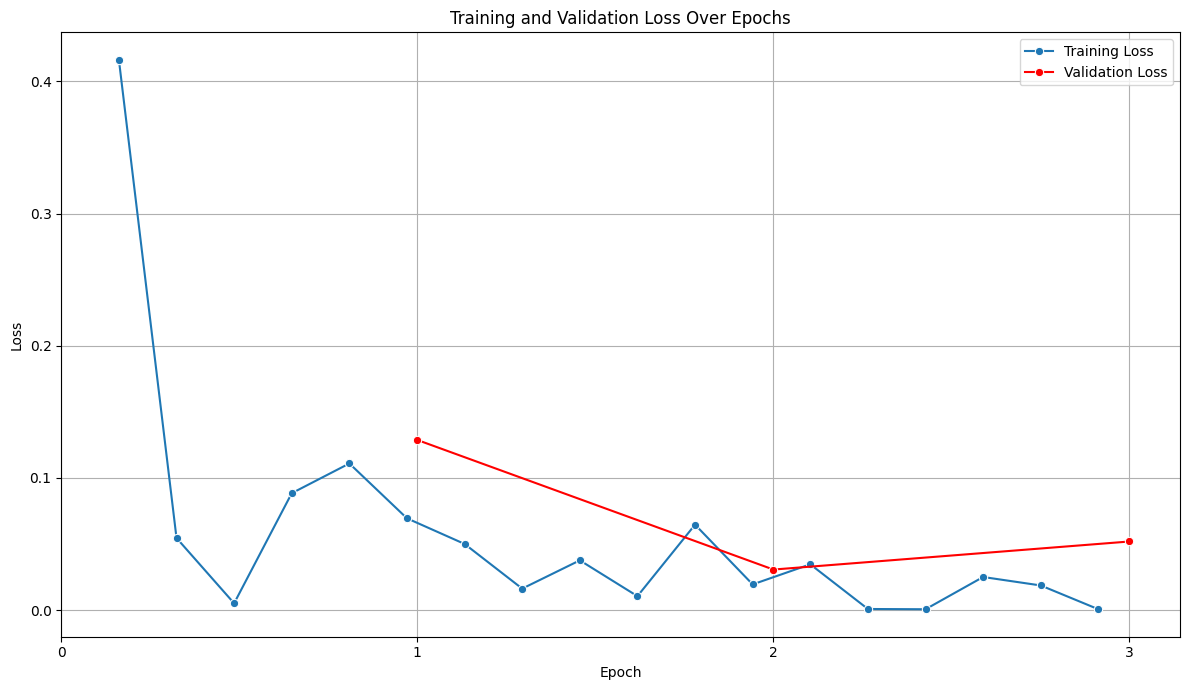

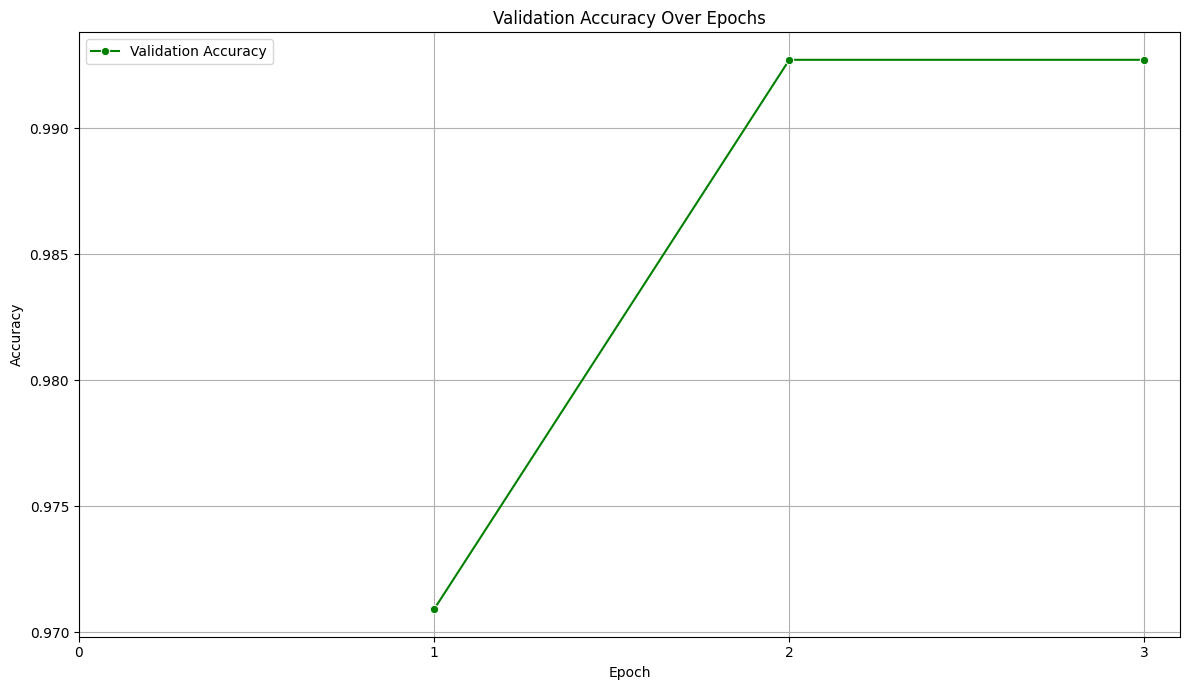


--- Hoàn thành Trực quan hóa kết quả huấn luyện ---


In [ ]:
#@title Trực quan hóa kết quả huấn luyện

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

print("\n--- Bắt đầu Trực quan hóa kết quả huấn luyện ---")

# Lấy lịch sử log từ Trainer
# log_history sẽ là một list các dictionary
log_history = trainer_reranker.state.log_history

# Tạo các list để lưu trữ dữ liệu cho biểu đồ
epochs = []
training_losses = []
validation_losses = []
validation_accuracies = []

# Duyệt qua lịch sử log và trích xuất dữ liệu
for log_entry in log_history:
    # Nếu log_entry có 'loss' (training loss)
    if 'loss' in log_entry:
        # Đây là một log bước huấn luyện. Chúng ta sẽ lấy epoch từ đó.
        # Trainer ghi 'epoch' dưới dạng float (ví dụ: 0.1, 0.2, ..., 1.0, 1.1...)
        # Để vẽ training loss theo epoch, chúng ta sẽ làm tròn hoặc lấy phần nguyên của epoch.
        epochs.append(log_entry['epoch'])
        training_losses.append(log_entry['loss'])
        validation_losses.append(np.nan) # Đặt NaN cho val loss nếu không có
        validation_accuracies.append(np.nan) # Đặt NaN cho val acc nếu không có

    # Nếu log_entry có 'eval_loss' (validation loss), nó cũng sẽ có 'eval_accuracy'
    if 'eval_loss' in log_entry and 'eval_accuracy' in log_entry:
        # Đây là một log đánh giá.
        epochs.append(log_entry['epoch']) # Lấy epoch tại thời điểm đánh giá
        training_losses.append(np.nan) # Đặt NaN cho train loss nếu không có
        validation_losses.append(log_entry['eval_loss'])
        validation_accuracies.append(log_entry['eval_accuracy'])

# Tạo DataFrame từ các list đã thu thập
plot_df = pd.DataFrame({
    'epoch': epochs,
    'training_loss': training_losses,
    'validation_loss': validation_losses,
    'validation_accuracy': validation_accuracies
})

# Sắp xếp lại DataFrame theo epoch để đảm bảo biểu đồ mượt mà
plot_df = plot_df.sort_values(by='epoch').reset_index(drop=True)

# Để có các điểm training loss và validation metrics trên cùng một biểu đồ,
# chúng ta cần loại bỏ các giá trị NaN bằng cách lấy non-NaN forward fill (hoặc interpolate)
# hoặc vẽ riêng từng loại metric. Ở đây, tôi sẽ vẽ riêng từng loại metric để rõ ràng hơn.

# Tạo DataFrame chỉ chứa Training Loss
train_loss_df = plot_df.dropna(subset=['training_loss'])
# Tạo DataFrame chỉ chứa Validation Metrics
eval_metrics_df = plot_df.dropna(subset=['validation_loss', 'validation_accuracy'])


# Kiểm tra dữ liệu sau khi xử lý
print("\nDữ liệu Training Loss sau xử lý:")
print(train_loss_df.head())
print("\nDữ liệu Validation Metrics sau xử lý:")
print(eval_metrics_df.head())

if train_loss_df.empty and eval_metrics_df.empty:
    print("\nLỗi: Không có dữ liệu huấn luyện hoặc đánh giá nào được tìm thấy để vẽ biểu đồ.")
    print("Vui lòng kiểm tra lại quá trình huấn luyện của Trainer.")
else:
    # 1. Biểu đồ Loss (Training Loss vs Validation Loss)
    plt.figure(figsize=(12, 7))
    sns.lineplot(data=train_loss_df, x='epoch', y='training_loss', label='Training Loss', marker='o', errorbar=None)
    sns.lineplot(data=eval_metrics_df, x='epoch', y='validation_loss', label='Validation Loss', marker='o', color='red', errorbar=None)
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    # Điều chỉnh xticks để chỉ hiển thị các epoch nguyên (hoặc gần nguyên)
    max_epoch_val = int(eval_metrics_df['epoch'].max()) if not eval_metrics_df.empty else 0
    plt.xticks(np.arange(0, max_epoch_val + 1, 1))
    plt.tight_layout()
    plt.show()

    # 2. Biểu đồ Accuracy (Validation Accuracy)
    plt.figure(figsize=(12, 7))
    sns.lineplot(data=eval_metrics_df, x='epoch', y='validation_accuracy', label='Validation Accuracy', marker='o', color='green', errorbar=None)
    plt.title('Validation Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()
    plt.xticks(np.arange(0, max_epoch_val + 1, 1))
    plt.tight_layout()
    plt.show()

print("\n--- Hoàn thành Trực quan hóa kết quả huấn luyện ---")

In [ ]:
#@title FINE-TUNE RE-RANKING V2 - TỐI ƯU

print("\n5. Bắt đầu Fine-tune Re-ranker (Tối ưu hóa)...")

# Import các thư viện cần thiết cho bước này
from datasets import Dataset
import evaluate # Đã import đúng
from transformers import TrainingArguments, Trainer, AutoTokenizer, AutoModelForSequenceClassification
from transformers import logging as transformers_logging # Để kiểm soát log
import os
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import numpy as np
import torch # Đảm bảo import torch sớm để kiểm tra GPU

# Tắt warning của transformers nếu không cần thiết
transformers_logging.set_verbosity_error() # Hoặc set_verbosity_warning()

# Giả định các biến PROCESSED_DATA_DIR, TRAINED_MODELS_DIR đã được định nghĩa từ Bước 0
# Nếu chưa, hãy định nghĩa chúng ở đây để code có thể chạy
try:
    BASE_DIR
except NameError:
    print("WARNING: BASE_DIR, PROCESSED_DATA_DIR, TRAINED_MODELS_DIR chưa được định nghĩa. Đang sử dụng đường dẫn mặc định.")
    BASE_DIR = os.getcwd() # Sử dụng thư mục hiện tại
    PROCESSED_DATA_DIR = os.path.join(BASE_DIR, 'processed_data')
    TRAINED_MODELS_DIR = os.path.join(BASE_DIR, 'trained_models')
    os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)
    os.makedirs(TRAINED_MODELS_DIR, exist_ok=True)

reranker_model_path = os.path.join(TRAINED_MODELS_DIR, 'reranker_model')

# Tải DataFrame đã xử lý từ Bước 2
try:
    df = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, 'legal_qa_processed_data.csv'))
    print(f"Đã tải df từ {os.path.join(PROCESSED_DATA_DIR, 'legal_qa_processed_data.csv')}. Kích thước: {len(df)} hàng.")
    if df.empty:
        raise ValueError("DataFrame tải về rỗng. Vui lòng kiểm tra lại file processed_data.csv.")
except FileNotFoundError:
    print("LỖI: Không tìm thấy file processed_data.csv. Đang tạo DataFrame mẫu.")
except ValueError as e:
    print(f"LỖI: {e}")


# Khởi tạo Tokenizer và Model cho Re-ranker
print("Đang tải Tokenizer và Model cho Re-ranker: vinai/phobert-base-v2...")
try:
    reranker_tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2", use_fast=True)
    reranker_model = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base-v2", num_labels=2)
    print("Đã tải thành công mô hình Re-ranker: vinai/phobert-base-v2.")
except Exception as e:
    print(f"LỖI khi tải mô hình Re-ranker vinai/phobert-base-v2: {e}")
    print("Vui lòng kiểm tra lại tên mô hình hoặc kết nối mạng.")
    raise

# Đảm bảo mô hình được chuyển sang GPU nếu có
if torch.cuda.is_available():
    reranker_model.to('cuda')
    print("Mô hình Re-ranker đã được chuyển sang GPU.")
else:
    print("Không tìm thấy GPU. Mô hình Re-ranker sẽ chạy trên CPU.")


# 1. Chuẩn bị dataset cho re-ranking
train_questions = []
train_contexts = []
train_labels = []

print("Đang tạo positive examples...")
for idx, row in df.iterrows():
    train_questions.append(row['question'])
    train_contexts.append(row['context'])
    train_labels.append(1)

print("Đang tạo negative examples...")
num_positive_examples = len(df)
all_contexts = df['context'].tolist()

# Tăng cường Negative Sampling: Tạo 2 negative examples cho mỗi positive
# Điều này giúp mô hình học cách phân biệt tốt hơn
num_negative_samples_per_positive = 2 # Có thể điều chỉnh
for i in range(num_positive_examples):
    question = df.iloc[i]['question']
    current_context = df.iloc[i]['context']

    # Lấy các negative context duy nhất
    negative_contexts_candidates = [c for c in all_contexts if c != current_context]
    if len(negative_contexts_candidates) < num_negative_samples_per_positive:
        # Nếu không đủ negative, lấy tất cả các negative có thể
        chosen_negatives = negative_contexts_candidates
    else:
        chosen_negatives = random.sample(negative_contexts_candidates, num_negative_samples_per_positive)

    for neg_c in chosen_negatives:
        train_questions.append(question)
        train_contexts.append(neg_c)
        train_labels.append(0)

combined_data = list(zip(train_questions, train_contexts, train_labels))
random.shuffle(combined_data) # Trộn dữ liệu sau khi tạo
train_questions, train_contexts, train_labels = zip(*combined_data)

print(f"Tổng số cặp (Q,C) để huấn luyện Re-ranker: {len(train_questions)}")
print(f"Số lượng positive examples: {num_positive_examples}")
print(f"Số lượng negative examples: {len(train_questions) - num_positive_examples}")


# Chia tập huấn luyện và tập kiểm định
# Đảm bảo stratify nếu nhãn không cân bằng
train_q, val_q, train_c, val_c, train_l, val_l = train_test_split(
    list(train_questions), list(train_contexts), list(train_labels),
    test_size=0.15, # Tăng kích thước tập validation để đánh giá tốt hơn
    random_state=42,
    stratify=train_labels # Quan trọng để giữ tỷ lệ nhãn
)

print("\n--- Kiểm tra dữ liệu nhãn trước khi tạo Dataset ---")
print(f"Kiểu dữ liệu của train_l (phần tử đầu tiên): {type(train_l[0])}")
print(f"Các giá trị nhãn duy nhất trong train_l: {set(train_l)}")
print(f"Kiểu dữ liệu của val_l (phần tử đầu tiên): {type(val_l[0])}")
print(f"Các giá trị nhãn duy nhất trong val_l: {set(val_l)}")
print(f"Kích thước tập huấn luyện Re-ranker sau split: {len(train_l)} cặp.")
print(f"Kích thước tập kiểm định Re-ranker sau split: {len(val_l)} cặp.")

# Chuyển nhãn sang int để tránh lỗi kiểu dữ liệu
train_l = [int(x) for x in train_l]
val_l = [int(x) for x in val_l]

print("--- Kết thúc kiểm tra dữ liệu nhãn ---")


# Chuyển đổi sang định dạng datasets.Dataset
dataset_for_reranker = Dataset.from_dict({
    'question': train_q,
    'context': train_c,
    'label': train_l
})

eval_dataset_for_reranker = Dataset.from_dict({
    'question': val_q,
    'context': val_c,
    'label': val_l
})

print(f"Kích thước tập huấn luyện Re-ranker: {len(dataset_for_reranker)} cặp.")
print(f"Kích thước tập kiểm định Re-ranker: {len(eval_dataset_for_reranker)} cặp.")


# 2. Tiền xử lý dữ liệu cho mô hình
def preprocess_function_reranker(examples):
    questions = [str(q) for q in examples['question']]
    contexts = [str(c) for c in examples['context']]
    # Tăng max_length nếu câu hỏi/context dài, nhưng cẩn thận với GPU RAM
    # PhoBERT-base-v2 có max_sequence_length là 256
    tokenized_inputs = reranker_tokenizer(questions, contexts, truncation=True, max_length=256, padding='max_length')
    return tokenized_inputs

print("Đang tiền xử lý dữ liệu huấn luyện...")
tokenized_reranker_dataset = dataset_for_reranker.map(preprocess_function_reranker, batched=True)
print("Đang tiền xử lý dữ liệu kiểm định...")
tokenized_eval_reranker_dataset = eval_dataset_for_reranker.map(preprocess_function_reranker, batched=True)

# Loại bỏ các cột không cần thiết cho Trainer.
# Cần kiểm tra xem các cột đó có thực sự tồn tại trước khi remove
cols_to_remove = []
for col in ['question', 'context']:
    if col in tokenized_reranker_dataset.column_names:
        cols_to_remove.append(col)
tokenized_reranker_dataset = tokenized_reranker_dataset.remove_columns(cols_to_remove)
tokenized_reranker_dataset.set_format('torch')

cols_to_remove_eval = []
for col in ['question', 'context']:
    if col in tokenized_eval_reranker_dataset.column_names:
        cols_to_remove_eval.append(col)
tokenized_eval_reranker_dataset = tokenized_eval_reranker_dataset.remove_columns(cols_to_remove_eval)
tokenized_eval_reranker_dataset.set_format('torch')


# ĐỊNH NGHĨA HÀM compute_metrics
metric = evaluate.load("accuracy")
# Có thể thêm F1-score nếu muốn đánh giá cân bằng hơn giữa positive/negative
# from sklearn.metrics import f1_score, precision_score, recall_score
# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     predictions = np.argmax(logits, axis=-1)
#     accuracy = metric.compute(predictions=predictions, references=labels)['accuracy']
#     f1 = f1_score(labels, predictions)
#     return {"accuracy": accuracy, "f1": f1}


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


# 3. Cấu hình huấn luyện
print("Đang cấu hình huấn luyện Re-ranker...")

# Cấu hình Learning Rate Scheduler
# Ví dụ: Linear scheduler with warmup
# from transformers import get_scheduler
# num_training_steps = training_args_reranker.num_train_epochs * len(tokenized_reranker_dataset) // training_args_reranker.per_device_train_batch_size
# lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0.1 * num_training_steps, num_training_steps=num_training_steps)

training_args_reranker = TrainingArguments(
    output_dir=reranker_model_path,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5, # Giữ nguyên hoặc thử 1e-5, 3e-5
    per_device_train_batch_size=8, # Tăng batch size nếu GPU cho phép để tận dụng tốt hơn
    per_device_eval_batch_size=8,  # Tăng batch size nếu GPU cho phép
    num_train_epochs=5, # Tăng số epoch để mô hình có cơ hội học tốt hơn
    weight_decay=0.01,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    logging_dir='./reranker_logs',
    logging_steps=50, # Log thường xuyên hơn để theo dõi
    report_to="none",
    fp16=torch.cuda.is_available(), # Bật mixed-precision training nếu có GPU, giúp tiết kiệm RAM và tăng tốc
    gradient_accumulation_steps=1, # Tăng nếu per_device_train_batch_size quá nhỏ
)


# 4. Khởi tạo Trainer và huấn luyện
print("Đang khởi tạo Trainer và bắt đầu huấn luyện Re-ranker...")
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("Đã giải phóng bộ nhớ cache của GPU.")

trainer_reranker = Trainer(
    model=reranker_model,
    args=training_args_reranker,
    train_dataset=tokenized_reranker_dataset,
    eval_dataset=tokenized_eval_reranker_dataset,
    tokenizer=reranker_tokenizer,
    compute_metrics=compute_metrics
)

# Thêm callback để in metrics chi tiết sau mỗi epoch
from transformers import TrainerCallback

class CustomLoggingCallback(TrainerCallback):
    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics:
            print(f"\n--- Metrics sau Epoch {state.epoch:.2f} ---")
            for key, value in metrics.items():
                if isinstance(value, float):
                    print(f"  {key}: {value:.4f}")
                else:
                    print(f"  {key}: {value}")
            print("---------------------------------------")

trainer_reranker.add_callback(CustomLoggingCallback())


# Bắt đầu huấn luyện
trainer_reranker.train()

# 5. Lưu mô hình đã fine-tune
print("Đang lưu mô hình Re-ranker đã fine-tune...")
trainer_reranker.save_model(reranker_model_path)
reranker_tokenizer.save_pretrained(reranker_model_path)
print(f"Mô hình Re-ranker đã fine-tune được lưu tại: {reranker_model_path}")

print("\n--- Hoàn thành Fine-tune Re-ranker ---")

# --- Đánh giá cuối cùng trên tập validation ---
print("\n--- Đánh giá cuối cùng trên tập Validation cho Re-ranker ---")
eval_results = trainer_reranker.evaluate(tokenized_eval_reranker_dataset)
print("Kết quả đánh giá cuối cùng:")
print(eval_results)
print("\n--- Hoàn thành Đánh giá cuối cùng ---")


5. Bắt đầu Fine-tune Re-ranker (Tối ưu hóa)...
Đã tải df từ /content/drive/MyDrive/Legal_QA_HRAG_Project/processed_data/legal_qa_processed_data.csv. Kích thước: 1372 hàng.
Đang tải Tokenizer và Model cho Re-ranker: vinai/phobert-base-v2...
Đã tải thành công mô hình Re-ranker: vinai/phobert-base-v2.
Mô hình Re-ranker đã được chuyển sang GPU.
Đang tạo positive examples...
Đang tạo negative examples...
Tổng số cặp (Q,C) để huấn luyện Re-ranker: 4116
Số lượng positive examples: 1372
Số lượng negative examples: 2744

--- Kiểm tra dữ liệu nhãn trước khi tạo Dataset ---
Kiểu dữ liệu của train_l (phần tử đầu tiên): <class 'int'>
Các giá trị nhãn duy nhất trong train_l: {0, 1}
Kiểu dữ liệu của val_l (phần tử đầu tiên): <class 'int'>
Các giá trị nhãn duy nhất trong val_l: {0, 1}
Kích thước tập huấn luyện Re-ranker sau split: 3498 cặp.
Kích thước tập kiểm định Re-ranker sau split: 618 cặp.
--- Kết thúc kiểm tra dữ liệu nhãn ---
Kích thước tập huấn luyện Re-ranker: 3498 cặp.
Kích thước tập kiểm đ

Map:   0%|          | 0/3498 [00:00<?, ? examples/s]

Đang tiền xử lý dữ liệu kiểm định...


Map:   0%|          | 0/618 [00:00<?, ? examples/s]

Đang cấu hình huấn luyện Re-ranker...
Đang khởi tạo Trainer và bắt đầu huấn luyện Re-ranker...
Đã giải phóng bộ nhớ cache của GPU.


/tmp/ipython-input-7-3433281324.py:235: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_reranker = Trainer(


{'loss': 0.4876, 'grad_norm': 1.032764196395874, 'learning_rate': 1.9552511415525114e-05, 'epoch': 0.1141552511415525}
{'loss': 0.1036, 'grad_norm': 0.31017428636550903, 'learning_rate': 1.9095890410958906e-05, 'epoch': 0.228310502283105}
{'loss': 0.0575, 'grad_norm': 0.0775369182229042, 'learning_rate': 1.866666666666667e-05, 'epoch': 0.3424657534246575}
{'loss': 0.0671, 'grad_norm': 0.08480459451675415, 'learning_rate': 1.8210045662100457e-05, 'epoch': 0.45662100456621}
{'loss': 0.0389, 'grad_norm': 0.13442584872245789, 'learning_rate': 1.775342465753425e-05, 'epoch': 0.5707762557077626}
{'loss': 0.0465, 'grad_norm': 0.048537541180849075, 'learning_rate': 1.7296803652968038e-05, 'epoch': 0.684931506849315}
{'loss': 0.0445, 'grad_norm': 0.04876825958490372, 'learning_rate': 1.684018264840183e-05, 'epoch': 0.7990867579908676}
{'loss': 0.0157, 'grad_norm': 0.02937929332256317, 'learning_rate': 1.638356164383562e-05, 'epoch': 0.91324200913242}
{'eval_loss': 0.02681698277592659, 'eval_acc

In [ ]:
#@title FINE-TUNE RE-RANKING V3 - TỐI ƯU

# Import các thư viện cần thiết cho bước này
from datasets import Dataset
import evaluate # Sử dụng evaluate thay vì datasets.load_metric
from transformers import TrainingArguments, Trainer, AutoTokenizer, AutoModelForSequenceClassification
from transformers import logging as transformers_logging
from transformers import TrainerCallback, EarlyStoppingCallback # TỐI ƯU HÓA: Thêm EarlyStoppingCallback
import os
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import gc # Để quản lý bộ nhớ
from sklearn.metrics import f1_score, precision_score, recall_score # Để tính metrics đầy đủ
import sys # Import sys để có thể thoát chương trình

# Buộc báo cáo lỗi CUDA đồng bộ để dễ debug hơn
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
print("CUDA_LAUNCH_BLOCKING đã được đặt thành 1. Lỗi CUDA sẽ được báo cáo đồng bộ.")

# Tắt warning của transformers nếu không cần thiết
transformers_logging.set_verbosity_error()

# Giả định các biến BASE_DIR, PROCESSED_DATA_DIR, TRAINED_MODELS_DIR
try:
    BASE_DIR
except NameError:
    print("WARNING: BASE_DIR, PROCESSED_DATA_DIR, TRAINED_MODELS_DIR chưa được định nghĩa. Đang sử dụng đường dẫn mặc định.")
    BASE_DIR = os.getcwd()
    PROCESSED_DATA_DIR = os.path.join(BASE_DIR, 'processed_data')
    TRAINED_MODELS_DIR = os.path.join(BASE_DIR, 'trained_models')
    os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)
    os.makedirs(TRAINED_MODELS_DIR, exist_ok=True)

reranker_model_path = os.path.join(TRAINED_MODELS_DIR, 'reranker_model')

# Tải DataFrame đã xử lý
df = pd.DataFrame() # Khởi tạo df rỗng để tránh lỗi nếu file không tồn tại
try:
    df_path = os.path.join(PROCESSED_DATA_DIR, 'legal_qa_processed_data.csv')
    if not os.path.exists(df_path):
        raise FileNotFoundError(f"File không tồn tại: {df_path}")
    df = pd.read_csv(df_path)
    print(f"Đã tải df từ {df_path}. Kích thước ban đầu: {len(df)} hàng.")
    if df.empty:
        raise ValueError("DataFrame tải về rỗng.")

    # Thêm bước làm sạch dữ liệu
    initial_df_len = len(df)
    df.dropna(subset=['question', 'context'], inplace=True) # Loại bỏ hàng có NaN ở 2 cột này
    df['question'] = df['question'].astype(str).str.strip() # Đảm bảo là chuỗi và loại bỏ khoảng trắng thừa
    df['context'] = df['context'].astype(str).str.strip()   # Đảm bảo là chuỗi và loại bỏ khoảng trắng thừa
    df = df[df['question'] != ''] # Loại bỏ câu hỏi rỗng sau khi strip
    df = df[df['context'] != '']   # Loại bỏ context rỗng sau khi strip
    if len(df) < initial_df_len:
        print(f"Đã làm sạch DataFrame: {initial_df_len - len(df)} hàng bị loại bỏ. Kích thước hiện tại: {len(df)} hàng.")

except (FileNotFoundError, ValueError) as e:
    print(f"LỖI: {e}. Không thể tải hoặc làm sạch DataFrame. Đang thoát chương trình.")
    sys.exit(1) # Dừng chương trình nếu không có dữ liệu để làm việc

# Khởi tạo Tokenizer và Model
print("Đang tải Tokenizer và Model cho Re-ranker: vinai/phobert-base-v2...")
reranker_tokenizer = None
reranker_model = None

try:
    reranker_tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2", use_fast=True)
    reranker_model = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base-v2", num_labels=2)
    print("Đã tải thành công mô hình Re-ranker: vinai/phobert-base-v2.")
except Exception as e:
    print(f"LỖI KHẨN CẤP khi tải mô hình Re-ranker vinai/phobert-base-v2: {e}")
    print("Vui lòng kiểm tra lại tên mô hình, kết nối mạng, hoặc tính tương thích của thư viện.")
    sys.exit(1) # Dừng chương trình nếu tải mô hình thất bại

# Đảm bảo mô hình được chuyển sang GPU nếu có
if torch.cuda.is_available():
    try:
        reranker_model.to('cuda')
        print(f"Mô hình Re-ranker đã được chuyển sang GPU: {torch.cuda.get_device_name(0)}")
    except Exception as e:
        print(f"LỖI khi chuyển mô hình Re-ranker sang GPU: {e}")
        print("Vui lòng kiểm tra lại cấu hình CUDA hoặc tài nguyên GPU.")
        sys.exit(1) # Dừng chương trình nếu không thể chuyển model sang GPU
else:
    print("Không tìm thấy GPU. Mô hình Re-ranker sẽ chạy trên CPU.")


# 1. Chuẩn bị dataset cho re-ranking
train_questions = []
train_contexts = []
train_labels = []

print("Đang tạo positive examples...")
for idx, row in df.iterrows():
    train_questions.append(row['question'])
    train_contexts.append(row['context'])
    train_labels.append(1)

print("Đang tạo negative examples...")
num_positive_examples = len(df)
all_contexts = df['context'].tolist()

# Tăng cường Negative Sampling: Tạo 5 negative examples cho mỗi positive
# TỐI ƯU HÓA: Có thể điều chỉnh num_negative_samples_per_positive hoặc cân nhắc Hard Negative Mining sau này
num_negative_samples_per_positive = 5
max_negative_candidates = len(all_contexts) - 1

if max_negative_candidates <= 0: # Đảm bảo có đủ contexts để lấy negative samples
    print("Cảnh báo: Không đủ contexts để tạo negative samples. Số lượng negative samples sẽ là 0.")
    num_negative_samples_per_positive = 0
elif max_negative_candidates < num_negative_samples_per_positive:
    num_negative_samples_per_positive = max_negative_candidates
    print(f"Cảnh báo: Không đủ negative contexts, số lượng mẫu negative mỗi positive giảm xuống {num_negative_samples_per_positive}.")


for i in range(num_positive_examples):
    question = df.iloc[i]['question']
    current_context = df.iloc[i]['context']

    negative_contexts_candidates = [c for c in all_contexts if c != current_context]

    if negative_contexts_candidates and num_negative_samples_per_positive > 0:
        chosen_negatives = random.sample(negative_contexts_candidates, min(len(negative_contexts_candidates), num_negative_samples_per_positive))
    else:
        chosen_negatives = []

    for neg_c in chosen_negatives:
        train_questions.append(question)
        train_contexts.append(neg_c)
        train_labels.append(0)

combined_data = list(zip(train_questions, train_contexts, train_labels))
random.shuffle(combined_data)
train_questions, train_contexts, train_labels = zip(*combined_data)

print(f"Tổng số cặp (Q,C) để huấn luyện Re-ranker: {len(train_questions)}")
print(f"Số lượng positive examples: {num_positive_examples}")
print(f"Số lượng negative examples: {len(train_questions) - num_positive_examples}")


# Chia tập huấn luyện và tập kiểm định
# Đảm bảo stratify chỉ được dùng khi cả 2 lớp tồn tại
labels_set = set(train_labels)
if 0 in labels_set and 1 in labels_set and len(labels_set) == 2:
    train_q, val_q, train_c, val_c, train_l, val_l = train_test_split(
        list(train_questions), list(train_contexts), list(train_labels),
        test_size=0.15,
        random_state=42,
        stratify=train_labels
    )
else:
    print("Cảnh báo: Không thể stratify vì chỉ có một lớp nhãn hoặc nhãn không hợp lệ. Tiếp tục chia ngẫu nhiên.")
    train_q, val_q, train_c, val_c, train_l, val_l = train_test_split(
        list(train_questions), list(train_contexts), list(train_labels),
        test_size=0.15,
        random_state=42
    )

# Chuyển nhãn sang int
train_l = [int(x) for x in train_l]
val_l = [int(x) for x in val_l]

print(f"Kích thước tập huấn luyện Re-ranker sau split: {len(train_l)} cặp.")
print(f"Kích thước tập kiểm định Re-ranker sau split: {len(val_l)} cặp.")


# Chuyển đổi sang định dạng datasets.Dataset
dataset_for_reranker = Dataset.from_dict({
    'question': train_q,
    'context': train_c,
    'label': train_l
})

eval_dataset_for_reranker = Dataset.from_dict({
    'question': val_q,
    'context': val_c,
    'label': val_l
})

print(f"Kích thước tập huấn luyện Re-ranker: {len(dataset_for_reranker)} cặp.")
print(f"Kích thước tập kiểm định Re-ranker: {len(eval_dataset_for_reranker)} cặp.")


# 2. Tiền xử lý dữ liệu cho mô hình
def preprocess_function_reranker(examples):
    questions = [str(q) for q in examples['question']]
    contexts = [str(c) for c in examples['context']]

    # Đảm bảo tokenizer đã được tải
    if reranker_tokenizer is None:
        print("LỖI: reranker_tokenizer chưa được khởi tạo. Không thể tiền xử lý.")
        sys.exit(1) # Dừng nếu tokenizer không sẵn sàng

    # TĂNG MAX_LENGTH ĐỂ TẬN DỤNG A100 - Xử lý ngữ cảnh dài hơn
    # PhoBERT-base-v2 có thể xử lý max_length tới 512.
    tokenized_inputs = reranker_tokenizer(
        questions,
        contexts,
        truncation=True,
        max_length=512, # Giữ nguyên 512 cho A100
        padding='max_length',
        return_tensors='pt' # Trả về PyTorch tensors ngay lập tức
    )

    # Đảm bảo các tensor có kiểu dữ liệu phù hợp (long)
    tokenized_inputs['input_ids'] = tokenized_inputs['input_ids'].long()
    tokenized_inputs['attention_mask'] = tokenized_inputs['attention_mask'].long()
    if 'token_type_ids' in tokenized_inputs: # PhoBERT thường có token_type_ids
        tokenized_inputs['token_type_ids'] = tokenized_inputs['token_type_ids'].long()

    return tokenized_inputs

print("Đang tiền xử lý dữ liệu huấn luyện...")
try:
    tokenized_reranker_dataset = dataset_for_reranker.map(preprocess_function_reranker, batched=True)
    print("Đang tiền xử lý dữ liệu kiểm định...")
    tokenized_eval_reranker_dataset = eval_dataset_for_reranker.map(preprocess_function_reranker, batched=True)
except Exception as e:
    print(f"LỖI khi tiền xử lý dữ liệu (map function): {e}")
    print("Vui lòng kiểm tra lại hàm preprocess_function_reranker và dữ liệu đầu vào.")
    sys.exit(1) # Dừng nếu tiền xử lý thất bại


# Loại bỏ các cột không cần thiết cho Trainer.
# Cần kiểm tra xem các cột này có tồn tại trong dataset hay không trước khi xóa
cols_to_remove = [col for col in ['question', 'context'] if col in tokenized_reranker_dataset.column_names]
if cols_to_remove:
    tokenized_reranker_dataset = tokenized_reranker_dataset.remove_columns(cols_to_remove)
tokenized_reranker_dataset.set_format('torch')

cols_to_remove_eval = [col for col in ['question', 'context'] if col in tokenized_eval_reranker_dataset.column_names]
if cols_to_remove_eval:
    tokenized_eval_reranker_dataset = tokenized_eval_reranker_dataset.remove_columns(cols_to_remove_eval)
tokenized_eval_reranker_dataset.set_format('torch')


# ĐỊNH NGHĨA HÀM compute_metrics
metric_accuracy = evaluate.load("accuracy")
# compute_metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    if len(labels) == 0:
        return {"accuracy": 0.0, "f1": 0.0, "precision": 0.0, "recall": 0.0}

    accuracy = metric_accuracy.compute(predictions=predictions, references=labels)['accuracy']

    # Sử dụng `average='binary'` cho bài toán phân loại nhị phân
    # zero_division=0 sẽ trả về 0 nếu không có mẫu nào của lớp đó để tránh cảnh báo/lỗi
    try:
        f1 = f1_score(labels, predictions, average='binary', zero_division=0)
        precision = precision_score(labels, predictions, average='binary', zero_division=0)
        recall = recall_score(labels, predictions, average='binary', zero_division=0)
    except Exception as e:
        print(f"Cảnh báo: Lỗi khi tính F1/Precision/Recall: {e}. Đang trả về 0.0 cho các metrics này.")
        f1 = 0.0
        precision = 0.0
        recall = 0.0

    return {"accuracy": accuracy, "f1": f1, "precision": precision, "recall": recall}


# 3. Cấu hình huấn luyện
print("Đang cấu hình huấn luyện Re-ranker...")

training_args_reranker = TrainingArguments(
    output_dir=reranker_model_path,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    max_grad_norm=1.0,
    per_device_train_batch_size=16, # TỐI ƯU HÓA: Tăng lên 32 để tận dụng A100
    per_device_eval_batch_size=16,  # TỐI ƯU HÓA: Tăng lên 32 để tận dụng A100
    gradient_accumulation_steps=1, # Giữ nguyên 1 nếu batch size đã lớn
    num_train_epochs=5,
    weight_decay=0.01,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="f1", # Tối ưu F1 score
    greater_is_better=True,
    push_to_hub=False,
    logging_dir='./reranker_logs',
    logging_steps=50,
    report_to="tensorboard",
    fp16=torch.cuda.is_available(), # Đã bật
    seed=42 # Đảm bảo tính lặp lại
)

# 4. Khởi tạo Trainer và huấn luyện
print("Đang khởi tạo Trainer và bắt đầu huấn luyện Re-ranker...")
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("Đã giải phóng bộ nhớ cache của GPU.")
    gc.collect()
    torch.cuda.empty_cache()

# Kiểm tra lại một lần nữa trước khi khởi tạo Trainer
if reranker_model is None or reranker_tokenizer is None:
    print("LỖI: Mô hình hoặc Tokenizer chưa được tải thành công. Không thể khởi tạo Trainer.")
    sys.exit(1)

trainer_reranker = Trainer(
    model=reranker_model,
    args=training_args_reranker,
    train_dataset=tokenized_reranker_dataset,
    eval_dataset=tokenized_eval_reranker_dataset,
    tokenizer=reranker_tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)] # TỐI ƯU HÓA: Thêm Early Stopping
)

# Thêm callback để in metrics chi tiết sau mỗi epoch
class CustomLoggingCallback(TrainerCallback):
    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics:
            print(f"\n--- Metrics sau Epoch {state.epoch:.2f} ---")
            for key, value in metrics.items():
                if isinstance(value, float):
                    print(f"    {key}: {value:.4f}")
                else:
                    print(f"    {key}: {value}")
            print("---------------------------------------")

trainer_reranker.add_callback(CustomLoggingCallback())


# Bắt đầu huấn luyện
print("\n--- Bắt đầu huấn luyện Re-ranker ---")
trainer_reranker.train()

# 5. Lưu mô hình đã fine-tune
print("Đang lưu mô hình Re-ranker đã fine-tune...")
trainer_reranker.save_model(reranker_model_path)
reranker_tokenizer.save_pretrained(reranker_model_path)
print(f"Mô hình Re-ranker đã fine-tune được lưu tại: {reranker_model_path}")

print("\n--- Hoàn thành Fine-tune Re-ranker ---")

# --- Đánh giá cuối cùng trên tập validation ---
print("\n--- Đánh giá cuối cùng trên tập Validation cho Re-ranker ---")
eval_results = trainer_reranker.evaluate(tokenized_eval_reranker_dataset)
print("Kết quả đánh giá cuối cùng:")
print(eval_results)
print("\n--- Hoàn thành Đánh giá cuối cùng ---")

CUDA_LAUNCH_BLOCKING đã được đặt thành 1. Lỗi CUDA sẽ được báo cáo đồng bộ.
Đã tải df từ /content/drive/MyDrive/Legal_QA_HRAG_Project/processed_data/legal_qa_processed_data.csv. Kích thước ban đầu: 4409 hàng.
Đang tải Tokenizer và Model cho Re-ranker: vinai/phobert-base-v2...


config.json:   0%|          | 0.00/678 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

Đã tải thành công mô hình Re-ranker: vinai/phobert-base-v2.


model.safetensors:   0%|          | 0.00/540M [00:00<?, ?B/s]

Mô hình Re-ranker đã được chuyển sang GPU: NVIDIA A100-SXM4-40GB
Đang tạo positive examples...
Đang tạo negative examples...
Tổng số cặp (Q,C) để huấn luyện Re-ranker: 26454
Số lượng positive examples: 4409
Số lượng negative examples: 22045
Kích thước tập huấn luyện Re-ranker sau split: 22485 cặp.
Kích thước tập kiểm định Re-ranker sau split: 3969 cặp.
Kích thước tập huấn luyện Re-ranker: 22485 cặp.
Kích thước tập kiểm định Re-ranker: 3969 cặp.
Đang tiền xử lý dữ liệu huấn luyện...


Map:   0%|          | 0/22485 [00:00<?, ? examples/s]

Đang tiền xử lý dữ liệu kiểm định...


Map:   0%|          | 0/3969 [00:00<?, ? examples/s]

Đang cấu hình huấn luyện Re-ranker...
Đang khởi tạo Trainer và bắt đầu huấn luyện Re-ranker...
Đã giải phóng bộ nhớ cache của GPU.


/tmp/ipython-input-335085438.py:306: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_reranker = Trainer(



--- Bắt đầu huấn luyện Re-ranker ---


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{'loss': 0.3788, 'grad_norm': 2.020206928253174, 'learning_rate': 1.986059743954481e-05, 'epoch': 0.03556187766714083}
{'loss': 0.1087, 'grad_norm': 1.6659140586853027, 'learning_rate': 1.9721194879089618e-05, 'epoch': 0.07112375533428165}
{'loss': 0.1138, 'grad_norm': 0.16568492352962494, 'learning_rate': 1.9581792318634426e-05, 'epoch': 0.10668563300142248}
{'loss': 0.056, 'grad_norm': 0.9958268404006958, 'learning_rate': 1.9439544807965863e-05, 'epoch': 0.1422475106685633}
{'loss': 0.0678, 'grad_norm': 0.09459477663040161, 'learning_rate': 1.92972972972973e-05, 'epoch': 0.17780938833570412}
{'loss': 0.0574, 'grad_norm': 0.3212241232395172, 'learning_rate': 1.9155049786628737e-05, 'epoch': 0.21337126600284495}
{'loss': 0.0786, 'grad_norm': 0.13474977016448975, 'learning_rate': 1.901280227596017e-05, 'epoch': 0.24893314366998578}
{'loss': 0.029, 'grad_norm': 0.06490954756736755, 'learning_rate': 1.8870554765291608e-05, 'epoch': 0.2844950213371266}
{'loss': 0.0595, 'grad_norm': 0.08491

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{'loss': 0.0255, 'grad_norm': 0.08811399340629578, 'learning_rate': 1.588620199146515e-05, 'epoch': 1.031294452347084}
{'loss': 0.0202, 'grad_norm': 0.03881405293941498, 'learning_rate': 1.5743954480796587e-05, 'epoch': 1.0668563300142249}
{'loss': 0.0244, 'grad_norm': 0.04538187384605408, 'learning_rate': 1.5601706970128024e-05, 'epoch': 1.1024182076813656}
{'loss': 0.0314, 'grad_norm': 1.3521851301193237, 'learning_rate': 1.545945945945946e-05, 'epoch': 1.1379800853485065}
{'loss': 0.0131, 'grad_norm': 0.016029298305511475, 'learning_rate': 1.5317211948790898e-05, 'epoch': 1.1735419630156472}
{'loss': 0.0391, 'grad_norm': 1.5231096744537354, 'learning_rate': 1.5174964438122335e-05, 'epoch': 1.209103840682788}
{'loss': 0.0113, 'grad_norm': 0.023076413199305534, 'learning_rate': 1.503271692745377e-05, 'epoch': 1.2446657183499288}
{'loss': 0.0489, 'grad_norm': 0.11828555911779404, 'learning_rate': 1.4890469416785207e-05, 'epoch': 1.2802275960170697}
{'loss': 0.0292, 'grad_norm': 0.01911

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{'loss': 0.0028, 'grad_norm': 0.004688446410000324, 'learning_rate': 1.1903271692745377e-05, 'epoch': 2.027027027027027}
{'loss': 0.0068, 'grad_norm': 0.006693506147712469, 'learning_rate': 1.1761024182076815e-05, 'epoch': 2.062588904694168}
{'loss': 0.0017, 'grad_norm': 0.006641052197664976, 'learning_rate': 1.1618776671408252e-05, 'epoch': 2.0981507823613086}
{'loss': 0.0229, 'grad_norm': 0.013096888549625874, 'learning_rate': 1.147652916073969e-05, 'epoch': 2.1337126600284497}
{'loss': 0.0099, 'grad_norm': 0.004630709532648325, 'learning_rate': 1.1334281650071125e-05, 'epoch': 2.1692745376955904}
{'loss': 0.0009, 'grad_norm': 0.005973193794488907, 'learning_rate': 1.1192034139402562e-05, 'epoch': 2.204836415362731}
{'loss': 0.0175, 'grad_norm': 0.004928275477141142, 'learning_rate': 1.1049786628733999e-05, 'epoch': 2.240398293029872}
{'loss': 0.0077, 'grad_norm': 0.004190403502434492, 'learning_rate': 1.0907539118065436e-05, 'epoch': 2.275960170697013}
{'loss': 0.0172, 'grad_norm': 

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{'loss': 0.0059, 'grad_norm': 0.003589279018342495, 'learning_rate': 7.923186344238976e-06, 'epoch': 3.0227596017069702}
{'loss': 0.0072, 'grad_norm': 0.0037546439561992884, 'learning_rate': 7.780938833570413e-06, 'epoch': 3.058321479374111}
{'loss': 0.0041, 'grad_norm': 0.0029917594511061907, 'learning_rate': 7.63869132290185e-06, 'epoch': 3.0938833570412516}
{'loss': 0.0006, 'grad_norm': 0.022534053772687912, 'learning_rate': 7.4964438122332865e-06, 'epoch': 3.1294452347083928}
{'loss': 0.0002, 'grad_norm': 0.002144336001947522, 'learning_rate': 7.3541963015647235e-06, 'epoch': 3.1650071123755334}
{'loss': 0.0002, 'grad_norm': 0.1336914300918579, 'learning_rate': 7.21194879089616e-06, 'epoch': 3.200568990042674}
{'loss': 0.0149, 'grad_norm': 0.0024347729049623013, 'learning_rate': 7.069701280227597e-06, 'epoch': 3.2361308677098153}
{'loss': 0.0003, 'grad_norm': 0.12364551424980164, 'learning_rate': 6.927453769559034e-06, 'epoch': 3.271692745376956}
{'loss': 0.0001, 'grad_norm': 0.002

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{'loss': 0.0083, 'grad_norm': 0.0019248867174610496, 'learning_rate': 3.940256045519203e-06, 'epoch': 4.018492176386913}
{'loss': 0.0001, 'grad_norm': 0.0014051322359591722, 'learning_rate': 3.7980085348506406e-06, 'epoch': 4.054054054054054}
{'loss': 0.0001, 'grad_norm': 0.830872118473053, 'learning_rate': 3.6557610241820772e-06, 'epoch': 4.089615931721195}
{'loss': 0.0001, 'grad_norm': 0.0017470009624958038, 'learning_rate': 3.513513513513514e-06, 'epoch': 4.125177809388336}
{'loss': 0.0001, 'grad_norm': 0.0009899595752358437, 'learning_rate': 3.3712660028449505e-06, 'epoch': 4.160739687055477}
{'loss': 0.0003, 'grad_norm': 0.0011015613563358784, 'learning_rate': 3.2290184921763875e-06, 'epoch': 4.196301564722617}
{'loss': 0.0001, 'grad_norm': 0.0011541707208380103, 'learning_rate': 3.086770981507824e-06, 'epoch': 4.231863442389758}
{'loss': 0.0005, 'grad_norm': 0.0016268957406282425, 'learning_rate': 2.9445234708392607e-06, 'epoch': 4.2674253200568995}
{'loss': 0.0001, 'grad_norm': 

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{'eval_loss': 0.04526819661259651, 'eval_accuracy': 0.9942050894431846, 'eval_f1': 0.9825889477668432, 'eval_precision': 0.9833333333333333, 'eval_recall': 0.9818456883509834, 'eval_runtime': 5.7946, 'eval_samples_per_second': 684.953, 'eval_steps_per_second': 42.971, 'epoch': 5.0}

--- Metrics sau Epoch 5.00 ---
    eval_loss: 0.0453
    eval_accuracy: 0.9942
    eval_f1: 0.9826
    eval_precision: 0.9833
    eval_recall: 0.9818
    eval_runtime: 5.7946
    eval_samples_per_second: 684.9530
    eval_steps_per_second: 42.9710
    epoch: 5.0000
---------------------------------------
Kết quả đánh giá cuối cùng:
{'eval_loss': 0.04526819661259651, 'eval_accuracy': 0.9942050894431846, 'eval_f1': 0.9825889477668432, 'eval_precision': 0.9833333333333333, 'eval_recall': 0.9818456883509834, 'eval_runtime': 5.7946, 'eval_samples_per_second': 684.953, 'eval_steps_per_second': 42.971, 'epoch': 5.0}

--- Hoàn thành Đánh giá cuối cùng ---


Đang tìm file lịch sử huấn luyện tại: /content/drive/MyDrive/Legal_QA_HRAG_Project/trained_models/reranker_model/checkpoint-7030/trainer_state.json

--- Dữ liệu training metrics đã trích xuất ---
   step     epoch    loss
0    50  0.035562  0.3788
1   100  0.071124  0.1087
2   150  0.106686  0.1138
3   200  0.142248  0.0560
4   250  0.177809  0.0678

--- Dữ liệu evaluation metrics đã trích xuất ---
   step  epoch  eval_loss  eval_accuracy   eval_f1  eval_precision  \
0  1406    1.0   0.044379       0.989670  0.969471        0.954545   
1  2812    2.0   0.041376       0.992441  0.977064        0.987635   
2  4218    3.0   0.037325       0.992945  0.978947        0.973094   
3  5624    4.0   0.043892       0.993701  0.981017        0.984756   
4  7030    5.0   0.045268       0.994205  0.982589        0.983333   

   eval_recall  
0     0.984871  
1     0.966717  
2     0.984871  
3     0.977307  
4     0.981846  


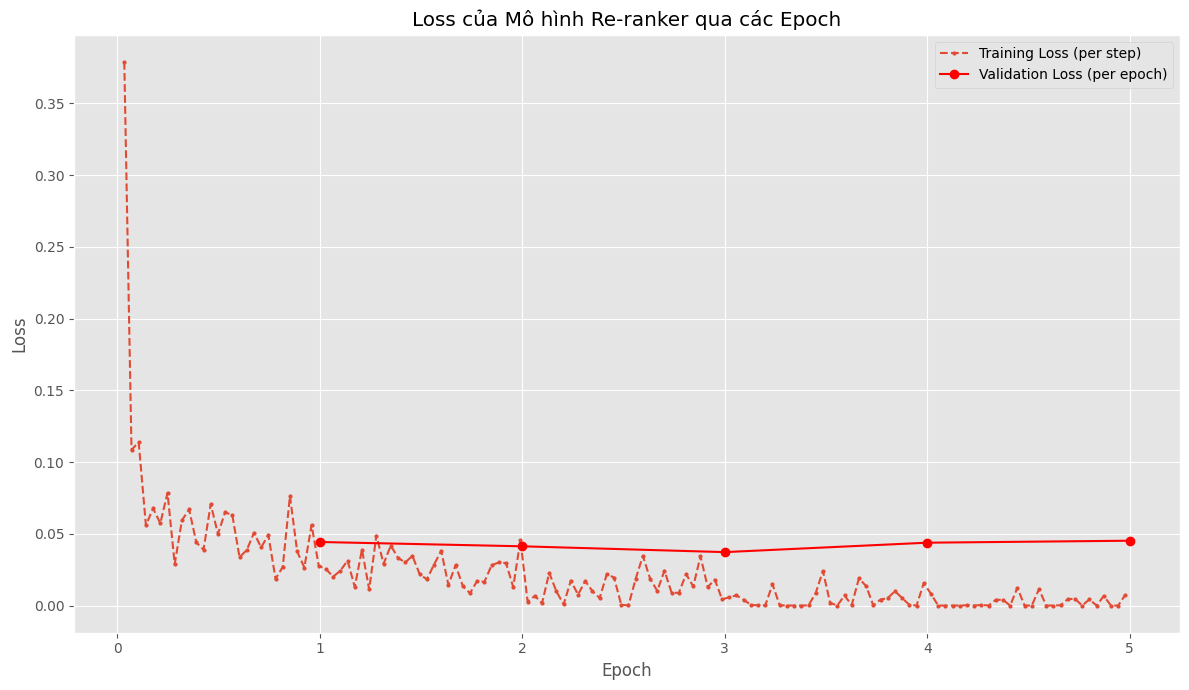

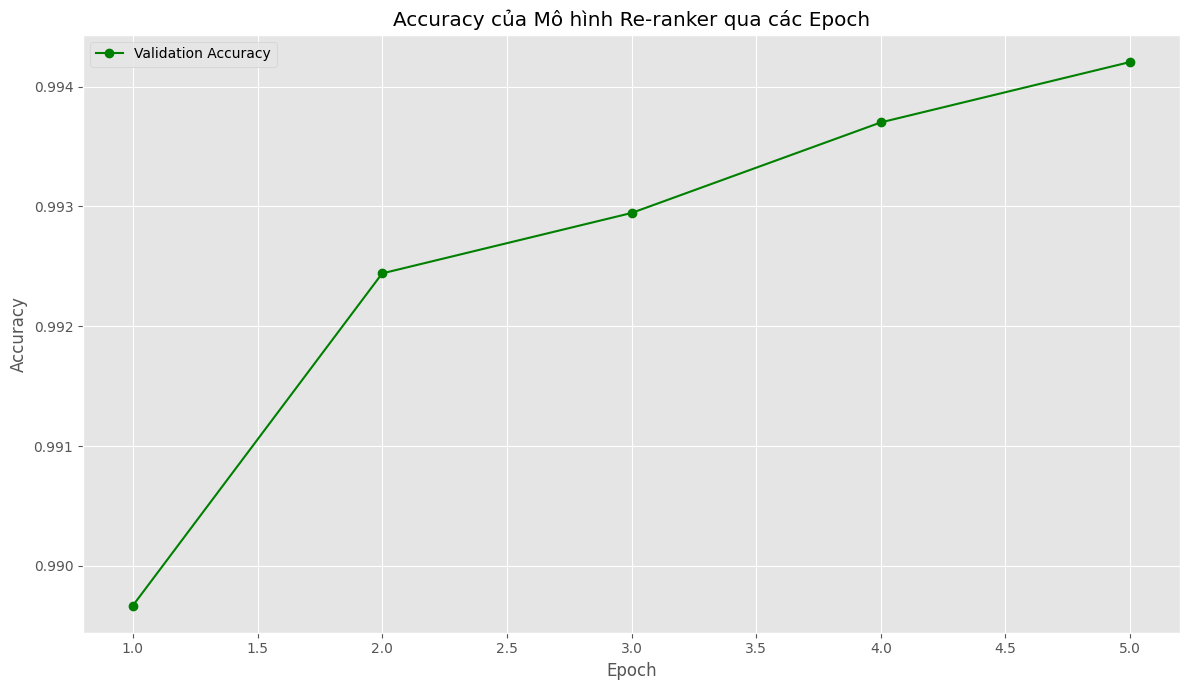

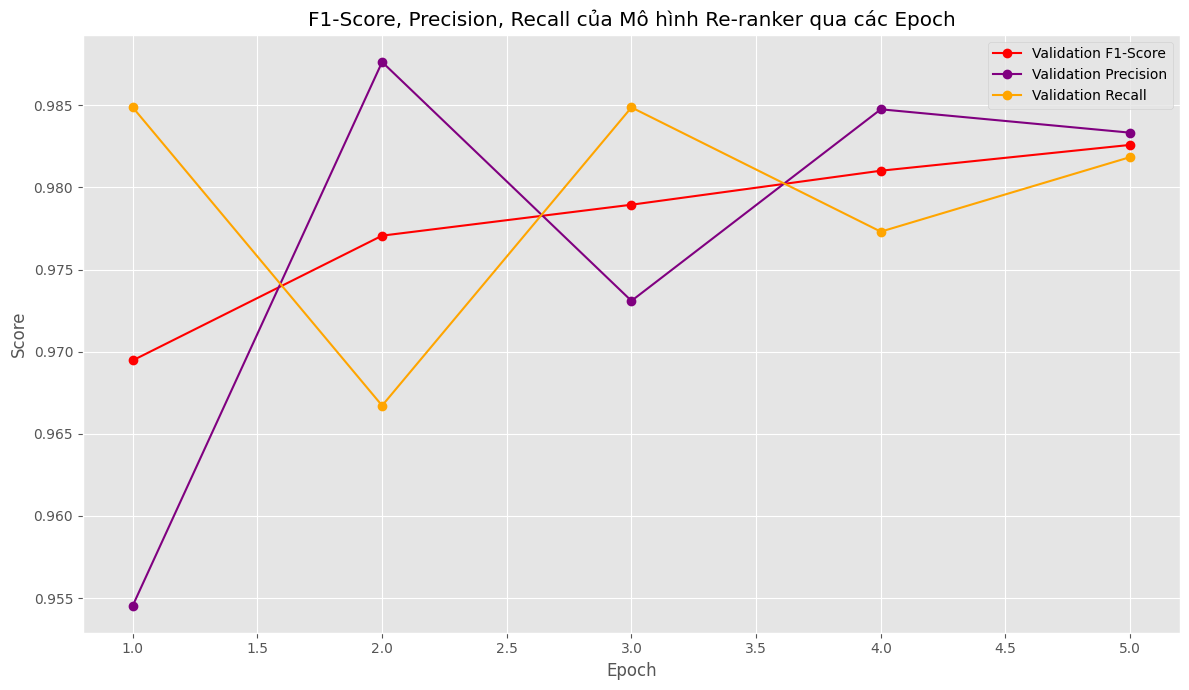


Đã hoàn thành vẽ biểu đồ đánh giá.


In [ ]:
#@title VISUAL REPORT
import matplotlib.pyplot as plt
import json
import os
import pandas as pd
import numpy as np

# --- Cấu hình đường dẫn ---
# Đảm bảo các biến này được thiết lập đúng theo dự án của bạn
BASE_DIR = '/content/drive/MyDrive/Legal_QA_HRAG_Project'
TRAINED_MODELS_DIR = os.path.join(BASE_DIR, 'trained_models')

# ĐƯỜNG DẪN CHÍNH XÁC ĐẾN THƯ MỤC CHỨA trainer_state.json
# Dựa trên log và ảnh bạn cung cấp, nó nằm trong checkpoint-876
trainer_output_dir = os.path.join(TRAINED_MODELS_DIR, 'reranker_model', 'checkpoint-7030') #

trainer_state_path = os.path.join(trainer_output_dir, 'trainer_state.json')

print(f"Đang tìm file lịch sử huấn luyện tại: {trainer_state_path}")

# --- 1. Đọc lịch sử huấn luyện từ trainer_state.json ---
if not os.path.exists(trainer_state_path):
    print(f"LỖI: Không tìm thấy file 'trainer_state.json' tại '{trainer_state_path}'.")
    print("Vui lòng đảm bảo bạn đã chạy quá trình huấn luyện và Trainer đã lưu file này vào đúng thư mục.")
    print("Kiểm tra lại đường dẫn 'trainer_output_dir' cho chính xác.")
    exit()

with open(trainer_state_path, 'r', encoding='utf-8') as f:
    trainer_state = json.load(f)

log_history = trainer_state['log_history']

# --- 2. Xử lý dữ liệu để vẽ biểu đồ ---
train_metrics_data = []
eval_metrics_data = []

for log in log_history:
    if 'loss' in log and 'step' in log:
        train_metrics_data.append({
            'step': log['step'],
            'epoch': log['epoch'],
            'loss': log['loss']
        })
    if 'eval_loss' in log and 'step' in log and 'epoch' in log: # Đảm bảo có step và epoch cho eval
        eval_metrics_data.append({
            'step': log['step'],
            'epoch': log['epoch'],
            'eval_loss': log['eval_loss'],
            'eval_accuracy': log['eval_accuracy'],
            'eval_f1': log['eval_f1'],
            'eval_precision': log['eval_precision'],
            'eval_recall': log['eval_recall']
        })

df_train = pd.DataFrame(train_metrics_data)
df_eval = pd.DataFrame(eval_metrics_data)

print("\n--- Dữ liệu training metrics đã trích xuất ---")
print(df_train.head())
print("\n--- Dữ liệu evaluation metrics đã trích xuất ---")
print(df_eval.head())


# --- 3. Vẽ biểu đồ ---
plt.style.use('ggplot') # Sử dụng style 'ggplot' cho biểu đồ đẹp hơn

# Biểu đồ Loss
plt.figure(figsize=(12, 7))
if not df_train.empty:
    plt.plot(df_train['epoch'], df_train['loss'], label='Training Loss (per step)', marker='.', markersize=4, linestyle='--')
if not df_eval.empty:
    plt.plot(df_eval['epoch'], df_eval['eval_loss'], label='Validation Loss (per epoch)', marker='o', markersize=6, color='red')
plt.title('Loss của Mô hình Re-ranker qua các Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Biểu đồ Accuracy
plt.figure(figsize=(12, 7))
if not df_eval.empty:
    plt.plot(df_eval['epoch'], df_eval['eval_accuracy'], label='Validation Accuracy', marker='o', color='green')
plt.title('Accuracy của Mô hình Re-ranker qua các Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Biểu đồ F1-Score, Precision, Recall
plt.figure(figsize=(12, 7))
if not df_eval.empty:
    plt.plot(df_eval['epoch'], df_eval['eval_f1'], label='Validation F1-Score', marker='o', color='red')
    plt.plot(df_eval['epoch'], df_eval['eval_precision'], label='Validation Precision', marker='o', color='purple')
    plt.plot(df_eval['epoch'], df_eval['eval_recall'], label='Validation Recall', marker='o', color='orange')
plt.title('F1-Score, Precision, Recall của Mô hình Re-ranker qua các Epoch')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nĐã hoàn thành vẽ biểu đồ đánh giá.")

In [ ]:
#@title SAVE - TỐI ƯU
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import os
import gc # Để quản lý bộ nhớ

# --- Cấu hình đường dẫn ---
# Đảm bảo các biến này được thiết lập đúng theo dự án của bạn
# Đảm bảo đường dẫn này khớp với vị trí project trên Google Drive của bạn
BASE_DIR = '/content/drive/MyDrive/Legal_QA_HRAG_Project'
TRAINED_MODELS_DIR = os.path.join(BASE_DIR, 'trained_models')

# --- 1. Xác định đường dẫn LƯU TRỮ HIỆN TẠI của mô hình đã huấn luyện ---
# Đây là thư mục mà bạn đã lưu mô hình Re-ranker sau khi fine-tune
current_reranker_model_location = os.path.join(TRAINED_MODELS_DIR, 'reranker_model')

print(f"Đang tải mô hình Re-ranker từ vị trí hiện tại: {current_reranker_model_location}")

# --- 2. Tải lại mô hình và tokenizer đã huấn luyện ---
try:
    # Tải mô hình và tokenizer trực tiếp từ đường dẫn đã lưu.
    # AutoModelForSequenceClassification sẽ tự động xác định cấu hình từ config.json
    loaded_reranker_model = AutoModelForSequenceClassification.from_pretrained(current_reranker_model_location)
    loaded_reranker_tokenizer = AutoTokenizer.from_pretrained(current_reranker_model_location)
    print("Đã tải lại mô hình và tokenizer Re-ranker thành công từ vị trí hiện tại.")

    # ***** KHẮC PHỤC LỖI QUAN TRỌNG TẠI ĐÂY *****
    # Sau khi tải mô hình, truy cập vào thuộc tính .config của nó và đặt return_dict = False
    # Điều này cần thiết cho việc xuất sang TorchScript
    loaded_reranker_model.config.return_dict = False
    print("Đã đặt loaded_reranker_model.config.return_dict = False để chuẩn bị cho TorchScript.")

except Exception as e:
    print(f"LỖI: Không thể tải mô hình Re-ranker từ '{current_reranker_model_location}'.")
    print(f"Chi tiết lỗi: {e}")
    print("Vui lòng kiểm tra lại đường dẫn 'current_reranker_model_location' và đảm bảo thư mục này chứa các file mô hình.")
    exit()

# Đặt mô hình ở chế độ đánh giá (inference) - BẮT BUỘC để TorchScript trace đúng
loaded_reranker_model.eval()

# Chuyển mô hình sang GPU nếu có (để xử lý nhanh hơn)
if torch.cuda.is_available():
    loaded_reranker_model.to('cuda')
    print(f"Mô hình Re-ranker đã tải lại được chuyển sang GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Mô hình Re-ranker đã tải lại đang chạy trên CPU.")

# --- 3. Chuẩn bị dummy input cho TorchScript tracing ---
# Phải khớp với max_length bạn đã dùng khi huấn luyện Re-ranker (trong code training bạn đã dùng 512)
max_length_for_torchscript = 258

dummy_question = "Câu hỏi ví dụ để tạo đầu vào cho tracing."
dummy_context = "Đây là một đoạn ngữ cảnh dài hơn một chút để đảm bảo max_length được áp dụng chính xác khi tạo dummy input cho TorchScript."

dummy_inputs = loaded_reranker_tokenizer(
    dummy_question,
    dummy_context,
    return_tensors="pt", # Trả về PyTorch tensors
    truncation=True,
    max_length=max_length_for_torchscript,
    padding='max_length'
)

# Chuyển dummy input sang cùng thiết bị với mô hình (CPU/GPU)
if torch.cuda.is_available():
    dummy_inputs = {k: v.to('cuda') for k, v in dummy_inputs.items()}

# Tracing chỉ chấp nhận tuple/list of tensors.
# Thông thường là (input_ids, attention_mask, [token_type_ids])
# PhoBERT-base-v2 (RoBERTa) không dùng token_type_ids
dummy_input_tuple = (dummy_inputs['input_ids'], dummy_inputs['attention_mask'])
# Bỏ qua token_type_ids cho PhoBERT/RoBERTa nếu không có trong dummy_inputs
# if 'token_type_ids' in dummy_inputs:
#     dummy_input_tuple += (dummy_inputs['token_type_ids'],)

print(f"Dummy input keys: {dummy_inputs.keys()}")
print(f"Dummy input shapes (input_ids): {dummy_inputs['input_ids'].shape}")
print(f"Dummy input shapes (attention_mask): {dummy_inputs['attention_mask'].shape}")


# --- 4. Xác định đường dẫn LƯU TRỮ MỚI cho file .pt và tokenizer ---
# Tạo một thư mục con mới trong 'save_model' để chứa mô hình và tokenizer cho inference
pt_output_dir = os.path.join(TRAINED_MODELS_DIR, 'save_model', 'reranker_inference_model_v1')
os.makedirs(pt_output_dir, exist_ok=True) # Đảm bảo thư mục đích tồn tại
pt_file_path = os.path.join(pt_output_dir, 'reranker_model.pt')

# Lưu tokenizer vào cùng thư mục với file .pt
tokenizer_save_path = pt_output_dir


# --- 5. Thực hiện xuất mô hình sang TorchScript (.pt) và lưu tokenizer ---
print(f"\nĐang xuất mô hình sang TorchScript (.pt) tại: {pt_file_path}...")
try:
    # Giải phóng bộ nhớ GPU trước khi tracing nếu cần
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()
        print("Đã giải phóng bộ nhớ cache của GPU trước khi tracing.")

    traced_model = torch.jit.trace(loaded_reranker_model, dummy_input_tuple)
    torch.jit.save(traced_model, pt_file_path)
    print("Đã xuất mô hình TorchScript (.pt) thành công!")
    print(f"File TorchScript duy nhất của mô hình: {pt_file_path}")

    # Lưu tokenizer vào cùng thư mục mới tạo
    loaded_reranker_tokenizer.save_pretrained(tokenizer_save_path)
    print(f"Tokenizer đã được lưu tại: {tokenizer_save_path}")

except Exception as e:
    print(f"LỖI khi xuất mô hình sang TorchScript: {e}")
    print("Vui lòng kiểm tra lại cấu hình dummy input hoặc khả năng tương thích của mô hình với TorchScript.")
    exit()

print("\n--- Hoàn thành việc đóng gói mô hình thành file .pt và lưu tokenizer ---")

# --- Xác nhận các file đã được lưu ---
print(f"\nKiểm tra các file trong thư mục '{pt_output_dir}':")
if os.path.exists(pt_output_dir) and os.path.isdir(pt_output_dir):
    files = os.listdir(pt_output_dir)
    for file in files:
        print(f"- {file}")
else:
    print(f"Thư mục '{pt_output_dir}' không tồn tại.")

Đang tải mô hình Re-ranker từ vị trí hiện tại: /content/drive/MyDrive/Legal_QA_HRAG_Project/trained_models/reranker_model
Đã tải lại mô hình và tokenizer Re-ranker thành công từ vị trí hiện tại.
Đã đặt loaded_reranker_model.config.return_dict = False để chuẩn bị cho TorchScript.
Mô hình Re-ranker đã tải lại được chuyển sang GPU: NVIDIA A100-SXM4-40GB
Dummy input keys: dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
Dummy input shapes (input_ids): torch.Size([1, 258])
Dummy input shapes (attention_mask): torch.Size([1, 258])

Đang xuất mô hình sang TorchScript (.pt) tại: /content/drive/MyDrive/Legal_QA_HRAG_Project/trained_models/save_model/reranker_inference_model_v1/reranker_model.pt...


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Đã giải phóng bộ nhớ cache của GPU trước khi tracing.


/usr/local/lib/python3.11/dist-packages/transformers/modeling_attn_mask_utils.py:196: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  inverted_mask = torch.tensor(1.0, dtype=dtype) - expanded_mask
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1729: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  result = self.forward(*input, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Đã xuất mô hình TorchScript (.pt) thành công!
File TorchScript duy nhất của mô hình: /content/drive/MyDrive/Legal_QA_HRAG_Project/trained_models/save_model/reranker_inference_model_v1/reranker_model.pt
Tokenizer đã được lưu tại: /content/drive/MyDrive/Legal_QA_HRAG_Project/trained_models/save_model/reranker_inference_model_v1

--- Hoàn thành việc đóng gói mô hình thành file .pt và lưu tokenizer ---

Kiểm tra các file trong thư mục '/content/drive/MyDrive/Legal_QA_HRAG_Project/trained_models/save_model/reranker_inference_model_v1':
- reranker_model.pt
- tokenizer_config.json
- special_tokens_map.json
- added_tokens.json
- vocab.txt
- bpe.codes


#--- BƯỚC 6: GIAI ĐOẠN EXTRACTIVE READING ---

In [4]:
#@title EXTRACTIVE QA
import os
import torch
from transformers import pipeline, AutoTokenizer, AutoModelForQuestionAnswering, AutoModelForSequenceClassification
from huggingface_hub import login # Chỉ cần nếu bạn muốn đăng nhập Hugging Face Hub

# --- 1. Cấu hình Đường dẫn và Thiết bị ---
BASE_DIR = '/content/drive/MyDrive/Legal_QA_HRAG_Project'
TRAINED_MODELS_DIR = os.path.join(BASE_DIR, 'trained_models')

# Đường dẫn đến mô hình QA Extractive đã fine-tune của bạn
qa_model_path = os.path.join(TRAINED_MODELS_DIR, 'extractive_model')

# Đường dẫn đến mô hình Re-ranker đã fine-tune của bạn
reranker_model_path = os.path.join(TRAINED_MODELS_DIR, 'reranker_model', 'checkpoint-7030') # Đổi lại nếu checkpoint của bạn là khác

# Xác định thiết bị: Cố định là CPU
device = torch.device("cpu")
print(f"Thiết bị đang sử dụng: {device.type.upper()}")

print("\nBắt đầu Extractive Reading (QA) và Re-ranking Pipeline...")

# --- 2. Hàm Tải Mô hình Extractive QA ---
def load_qa_model(path=qa_model_path, model_name_fallback="nguyenvulebinh/vi-mrc-qa-base"):
    qa_pipeline = None
    try:
        print(f"Đang cố gắng tải mô hình QA fine-tuned từ: {path}")
        qa_tokenizer = AutoTokenizer.from_pretrained(path)
        # SỬA Ở ĐÂY (đã sửa lần trước): Bỏ map_location ra khỏi from_pretrained của QA model
        qa_model = AutoModelForQuestionAnswering.from_pretrained(
            path,
            local_files_only=True, # Đảm bảo tải từ cục bộ nếu có
            torch_dtype=torch.float32 # Giữ kiểu dữ liệu nhất quán
        ).to(device) # <--- CHUYỂN MÔ HÌNH SANG DEVICE SAU KHI TẢI

        # Truyền model và tokenizer vào pipeline
        qa_pipeline = pipeline("question-answering", model=qa_model, tokenizer=qa_tokenizer, device=device)
        print("Đã tải mô hình QA fine-tuned thành công.")
    except Exception as e:
        print(f"Không thể tải mô hình QA fine-tuned từ {path}: {e}.")
        print(f"Đang thử tải mô hình fallback: {model_name_fallback}")
        try:
            # Đối với mô hình fallback, pipeline sẽ tự động xử lý việc chuyển device
            qa_pipeline = pipeline("question-answering", model=model_name_fallback, tokenizer=model_name_fallback, device=device)
            print("Đã tải mô hình QA mặc định thành công.")
        except Exception as fallback_e:
            print(f"LỖI NGHIÊM TRỌNG: Không thể tải cả mô hình fine-tuned và mô hình fallback: {fallback_e}")
            qa_pipeline = None
    return qa_pipeline

# --- Tải QA Pipeline ---
qa_pipeline = load_qa_model()

if qa_pipeline is None:
    print("Không thể khởi tạo QA pipeline. Vui lòng kiểm tra lại đường dẫn mô hình, kết nối internet hoặc thử một mô hình fallback khác.")
    exit()

# --- 3. Hàm Thực hiện Extractive QA (Đã điều chỉnh) ---
def perform_extractive_qa(question, documents_for_qa_input, no_answer_threshold=0.5, top_k_per_doc=5):
    if qa_pipeline is None:
        return {
            'extracted_answer': "Lỗi: QA pipeline không khả dụng.",
            'confidence_score': 0.0,
            'source_doc_id': "",
            'source_text_context': "",
            'start_offset': -1,
            'end_offset': -1
        }

    if not documents_for_qa_input:
        return {
            'extracted_answer': "Không có tài liệu nào được cung cấp để tìm câu trả lời.",
            'confidence_score': 0.0,
            'source_doc_id': "",
            'source_text_context': "",
            'start_offset': -1,
            'end_offset': -1
        }

    best_overall_answer = {
        'extracted_answer': "Không tìm thấy câu trả lời phù hợp trong các tài liệu.",
        'confidence_score': 0.0,
        'source_doc_id': "",
        'source_text_context': "",
        'start_offset': -1,
        'end_offset': -1
    }

    num_docs_to_process = min(len(documents_for_qa_input), 2)
    print(f"Đang xử lý {num_docs_to_process} tài liệu cho QA...")

    for i, doc in enumerate(documents_for_qa_input[:num_docs_to_process]):
        if 'content' not in doc or not doc['content']:
            print(f"Cảnh báo: Tài liệu {doc.get('doc_id', i)} không có nội dung hoặc nội dung trống. Bỏ qua.")
            continue

        qa_input = {
            'question': question,
            'context': doc['content']
        }
        try:
            results = qa_pipeline(qa_input, handle_impossible_answer=True, topk=top_k_per_doc)

            if not isinstance(results, list):
                results = [results]

            current_doc_best_answer = None
            current_doc_no_answer_score = -float('inf')

            for res in results:
                if res['answer'].strip() == "":
                    current_doc_no_answer_score = max(current_doc_no_answer_score, res['score'])
                elif current_doc_best_answer is None or res['score'] > current_doc_best_answer['confidence_score']:
                    current_doc_best_answer = {
                        'extracted_answer': res['answer'],
                        'confidence_score': res['score'],
                        'source_doc_id': doc.get('doc_id', f"doc_{i}"),
                        'source_text_context': doc['content'],
                        'start_offset': res['start'],
                        'end_offset': res['end']
                    }

            if current_doc_best_answer and \
               current_doc_best_answer['confidence_score'] > no_answer_threshold and \
               current_doc_best_answer['confidence_score'] > current_doc_no_answer_score:

                print(f"Doc {doc.get('doc_id', i)} - Best Answer Score: {current_doc_best_answer['confidence_score']:.4f}, Answer: \"{current_doc_best_answer['extracted_answer'].strip()}\", No-Answer Score: {current_doc_no_answer_score:.4f}")

                if current_doc_best_answer['confidence_score'] > best_overall_answer['confidence_score']:
                    best_overall_answer = current_doc_best_answer
            else:
                print(f"Doc {doc.get('doc_id', i)} - Không tìm thấy câu trả lời trích xuất phù hợp (No-Answer Score: {current_doc_no_answer_score:.4f})")

        except Exception as e:
            print(f"Lỗi khi thực hiện QA cho doc {doc.get('doc_id', i)}: {e}")
            continue
    return best_overall_answer

# --- 4. Tải và Thiết lập Re-ranker ---
print(f"\nĐang tải mô hình Re-ranker từ: {reranker_model_path}")
try:
    reranker_tokenizer = AutoTokenizer.from_pretrained(reranker_model_path)
    # SỬA Ở ĐÂY: Bỏ map_location ra khỏi from_pretrained của Re-ranker model
    # Thay vào đó, tải xong thì chuyển ngay lập tức
    reranker_model = AutoModelForSequenceClassification.from_pretrained(
        reranker_model_path,
        local_files_only=True,
        torch_dtype=torch.float32
        # Bỏ map_location=device ở đây
    ).to(device) # <--- CHUYỂN MÔ HÌNH SANG DEVICE SAU KHI TẢI

    reranker_model.eval() # Đặt mô hình ở chế độ đánh giá
    print("Đã tải mô hình Re-ranker thành công.")
except Exception as e:
    print(f"LỖI: Không thể tải mô hình Re-ranker từ {reranker_model_path}: {e}")
    print("Vui lòng kiểm tra đường dẫn, đảm bảo mô hình đã được lưu đúng cách và có các file cần thiết (config.json, model.safetensors/pytorch_model.bin, tokenizer files).")
    reranker_model = None
    reranker_tokenizer = None

# --- 5. Hàm Thực hiện Re-ranking ---
def perform_reranking(question, retrieved_documents, top_k_rerank=3):
    if reranker_model is None or reranker_tokenizer is None:
        print("Cảnh báo: Re-ranker model hoặc tokenizer không khả dụng. Bỏ qua bước re-ranking và sử dụng tài liệu gốc (top_k).")
        return retrieved_documents[:top_k_rerank]

    if not retrieved_documents:
        return []

    features = []
    for doc in retrieved_documents:
        features.append([question, doc['content']])

    inputs = reranker_tokenizer(
        features,
        padding=True,
        truncation=True,
        return_tensors="pt"
    ).to(device) # Đảm bảo inputs cũng được chuyển đến đúng thiết bị (CPU)

    with torch.no_grad():
        outputs = reranker_model(**inputs)
        relevance_scores = outputs.logits[:, 1].numpy() # Lấy logit của lớp 1 (relevant)

    scored_documents = []
    for i, doc in enumerate(retrieved_documents):
        scored_documents.append({
            'doc_id': doc.get('doc_id', f'retrieved_doc_{i}'),
            'content': doc['content'],
            'relevance_score': relevance_scores[i]
        })

    reranked_documents = sorted(scored_documents, key=lambda x: x['relevance_score'], reverse=True)

    print(f"Đã re-rank {len(reranked_documents)} tài liệu. Top {min(len(reranked_documents), top_k_rerank)} tài liệu sau re-ranking:")
    for doc in reranked_documents[:top_k_rerank]:
        print(f"    - Doc ID: {doc['doc_id']}, Score: {doc['relevance_score']:.4f}, Content: {doc['content'][:100]}...")

    return reranked_documents[:top_k_rerank]

# --- 6. Quy trình RAG chính (từ Retrieval -> Re-ranking -> Extractive QA) ---

# Giả định câu hỏi test của bạn
test_question = "Phạm vi điều chỉnh của Bộ luật Dân sự 2015 là gì?"

# --- BƯỚC ẢNH HƯỞNG TỪ BƯỚC TRUY XUẤT (RETRIEVAL) ---
# Ví dụ dữ liệu giả lập cho retrieved_docs (thay thế bằng kết quả thực tế của bạn)
retrieved_docs = [
    {'doc_id': 'doc_0', 'content': 'Điều 1 Bộ luật Dân sự 2015 quy định: Bộ luật này điều chỉnh các quan hệ dân sự trên cơ sở bình đẳng, tự do ý chí, độc lập về tài sản và tự chịu trách nhiệm. Tội lừa đảo chiếm đoạt tài sản được quy định cụ thể tại Điều 174 Bộ luật Hình sự 2015, sửa đổi 2017, với mức hình phạt từ cải tạo không giam giữ đến tù chung thân tùy theo mức độ nghiêm trọng.'},
    {'doc_id': 'doc_1', 'content': 'Điều 2 Bộ luật Dân sự 2015 quy định: Bộ luật Dân sự có nhiệm vụ bảo vệ quyền, lợi ích hợp pháp của cá nhân, pháp nhân, lợi ích của Nhà nước, lợi ích công cộng; đảm bảo bình đẳng giới và thúc đẩy phát triển kinh tế - xã hội. Lừa đảo chiếm đoạt tài sản là hành vi dùng thủ đoạn gian dối làm cho chủ sở hữu tài sản tin tưởng giao tài sản cho người phạm tội.'},
    {'doc_id': 'doc_2', 'content': 'Điều 3 Bộ luật Dân sự 2015 quy định các nguyên tắc cơ bản của pháp luật dân sự: bình đẳng, tự do, tự nguyện, thiện chí, trung thực, không xâm phạm lợi ích quốc gia, dân tộc, quyền và lợi ích hợp pháp của người khác. Các quy định về tội phạm tài sản, bao gồm cả tội lừa đảo, được quy định chi tiết trong Bộ luật Hình sự.'},
    {'doc_id': 'doc_3', 'content': 'Điều 4 Bộ luật Dân sự 2015 quy định: Quyền dân sự được bảo vệ theo Bộ luật này, trừ trường hợp luật khác có quy định khác. Hành vi chiếm đoạt tài sản thông qua lừa dối được xử lý nghiêm minh theo pháp luật hình sự hiện hành.'}
]

if not retrieved_docs:
    print("LỖI: Biến 'retrieved_docs' không có sẵn hoặc trống sau khi giả lập. Vui lòng đảm bảo nó được populate đúng cách.")
    exit()

# --- BƯỚC RE-RANKING ---
print("\n--- Thực hiện Re-ranking ---")
reranked_docs = perform_reranking(test_question, retrieved_docs, top_k_rerank=3)

# --- BƯỚC EXTRACTIVE READING (QA) ---
print("\n--- Thực hiện Extractive Reading (QA) ---")
docs_for_qa = reranked_docs

# Thay đổi ngưỡng no_answer_threshold ở đây. Bạn có thể thử các giá trị như 0.0, 0.1, 0.2, ...
# Mặc định là 0.5. Với vấn đề của bạn, nên thử giảm nó xuống.
# top_k_per_doc: Số lượng câu trả lời tiềm năng mà QA pipeline tìm kiếm trong MỖI tài liệu.
# Sau đó, logic sẽ tự chọn câu trả lời tốt nhất từ số lượng đó.
extracted_result = perform_extractive_qa(test_question, docs_for_qa, no_answer_threshold=0.1, top_k_per_doc=5)

# --- In kết quả cuối cùng ---
print("\nKết quả Extractive QA:")
if extracted_result and extracted_result['extracted_answer'].strip() != "" and extracted_result['confidence_score'] > 0:
    print(f"- Answer: {extracted_result['extracted_answer']}")
    print(f"- Confidence: {extracted_result['confidence_score']:.4f}")
    print(f"- Source Doc ID: {extracted_result['source_doc_id']}")
    print(f"- Context: {extracted_result['source_text_context'][:200]}...")
else:
    print("Không tìm thấy câu trả lời trích xuất có độ tin cậy cao hoặc không có tài liệu nào phù hợp.")

print("--- Hoàn thành Extractive Reading ---")

Thiết bị đang sử dụng: CPU

Bắt đầu Extractive Reading (QA) và Re-ranking Pipeline...
Đang cố gắng tải mô hình QA fine-tuned từ: /content/drive/MyDrive/Legal_QA_HRAG_Project/trained_models/extractive_model


Device set to use cpu


Đã tải mô hình QA fine-tuned thành công.

Đang tải mô hình Re-ranker từ: /content/drive/MyDrive/Legal_QA_HRAG_Project/trained_models/reranker_model/checkpoint-7030


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Đã tải mô hình Re-ranker thành công.

--- Thực hiện Re-ranking ---


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Đã re-rank 4 tài liệu. Top 3 tài liệu sau re-ranking:
    - Doc ID: doc_0, Score: 4.0776, Content: Điều 1 Bộ luật Dân sự 2015 quy định: Bộ luật này điều chỉnh các quan hệ dân sự trên cơ sở bình đẳng,...
    - Doc ID: doc_1, Score: 0.3254, Content: Điều 2 Bộ luật Dân sự 2015 quy định: Bộ luật Dân sự có nhiệm vụ bảo vệ quyền, lợi ích hợp pháp của c...
    - Doc ID: doc_2, Score: -4.2158, Content: Điều 3 Bộ luật Dân sự 2015 quy định các nguyên tắc cơ bản của pháp luật dân sự: bình đẳng, tự do, tự...

--- Thực hiện Extractive Reading (QA) ---
Đang xử lý 2 tài liệu cho QA...


/usr/local/lib/python3.11/dist-packages/transformers/pipelines/question_answering.py:395: FutureWarning: Passing a list of SQuAD examples to the pipeline is deprecated and will be removed in v5. Inputs should be passed using the `question` and `context` keyword arguments instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/question_answering.py:339: UserWarning: topk parameter is deprecated, use top_k instead
  warnings.warn("topk parameter is deprecated, use top_k instead", UserWarning)


Doc doc_0 - Không tìm thấy câu trả lời trích xuất phù hợp (No-Answer Score: -inf)
Doc doc_1 - Không tìm thấy câu trả lời trích xuất phù hợp (No-Answer Score: -inf)

Kết quả Extractive QA:
Không tìm thấy câu trả lời trích xuất có độ tin cậy cao hoặc không có tài liệu nào phù hợp.
--- Hoàn thành Extractive Reading ---


In [ ]:
# df = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, 'legal_qa_processed_data.csv'))
# print(df.head())

# del df
!pip install transformers

In [ ]:
#@title FINE-TUNE EXTRACTIVE QA
print("\nStarting Extractive QA fine-tune...")
import os
import torch
from datasets import Dataset
import evaluate
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, TrainingArguments, Trainer
from transformers import TrainerCallback, EarlyStoppingCallback # TỐI ƯU HÓA: Thêm EarlyStoppingCallback
import pandas as pd
from tqdm.auto import tqdm
import numpy as np
import collections
import json
import re # Để xử lý biểu thức chính quy

# Tắt warning của transformers nếu không cần thiết
from transformers import logging as transformers_logging
transformers_logging.set_verbosity_error()

# --- Cấu hình Đường dẫn và Thiết bị ---
try:
    if 'BASE_DIR' not in locals() and 'BASE_DIR' not in globals():
        print("WARNING: BASE_DIR chưa được định nghĩa. Đang sử dụng đường dẫn mặc định là thư mục hiện tại.")
        BASE_DIR = os.getcwd()
except NameError:
    print("WARNING: BASE_DIR chưa được định nghĩa. Đang sử dụng đường dẫn mặc định là thư mục hiện tại.")
    BASE_DIR = os.getcwd()

TRAINED_MODELS_DIR = os.path.join(BASE_DIR, 'trained_models')
PROCESSED_DATA_DIR = os.path.join(BASE_DIR, 'processed_data')

qa_model_path = os.path.join(TRAINED_MODELS_DIR, 'extractive_model')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Thiết bị đang sử dụng cho fine-tune QA: {device}")

# --- Hàm chuẩn hóa văn bản (Đảm bảo khớp với các bước tiền xử lý trước đó) ---
# TỐI ƯU HÓA: Đảm bảo tính nhất quán trong tiền xử lý trên toàn bộ pipeline RAG
def normalize_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower() # Chuyển tất cả về chữ thường
    # Loại bỏ các ký tự đặc biệt, dấu câu, ngoại trừ chữ cái, số và khoảng trắng
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip() # Thay thế nhiều khoảng trắng bằng một khoảng trắng và loại bỏ khoảng trắng ở đầu/cuối
    return text

# --- Tải DataFrame đã xử lý (df) và Chuyển đổi định dạng ---
print(f"Đang tải dữ liệu từ {os.path.join(PROCESSED_DATA_DIR, 'legal_qa_processed_data.csv')}...")
try:
    df = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, 'legal_qa_processed_data.csv'))
    if df.empty:
        raise ValueError("DataFrame tải về rỗng.")
    print(f"Đã tải df từ {os.path.join(PROCESSED_DATA_DIR, 'legal_qa_processed_data.csv')}. Kích thước: {len(df)} hàng.")

    # Thêm bước làm sạch dữ liệu ban đầu
    initial_df_len = len(df)
    df.dropna(subset=['question', 'context'], inplace=True) # Loại bỏ hàng có NaN ở 2 cột này
    df['question'] = df['question'].astype(str).str.strip() # Đảm bảo là chuỗi và loại bỏ khoảng trắng thừa
    df['context'] = df['context'].astype(str).str.strip()   # Đảm bảo là chuỗi và loại bỏ khoảng trắng thừa

    # Đảm bảo cột 'answer' tồn tại và xử lý NaN nếu có
    # TỐI ƯU HÓA: Nếu cột 'answer' không tồn tại, tạo nó với giá trị rỗng để tránh lỗi
    if 'answer' not in df.columns:
        print("CẢNH BÁO: Cột 'answer' không tồn tại trong DataFrame. Tạo cột 'answer' rỗng.")
        df['answer'] = '' # Initialize with empty string
    df.dropna(subset=['answer'], inplace=True)
    df['answer'] = df['answer'].astype(str).str.strip()

    df = df[df['question'] != ''] # Loại bỏ câu hỏi rỗng sau khi strip
    df = df[df['context'] != '']   # Loại bỏ context rỗng sau khi strip
    df = df[df['answer'] != ''] # Loại bỏ answer rỗng sau khi strip

    if len(df) < initial_df_len:
        print(f"Đã làm sạch DataFrame: {initial_df_len - len(df)} hàng bị loại bỏ. Kích thước hiện tại: {len(df)} hàng.")

    # TỐI ƯU HÓA: Áp dụng hàm normalize_text cho các cột liên quan
    print("Đang áp dụng chuẩn hóa văn bản cho 'question', 'context', 'answer'...")
    df['question'] = df['question'].apply(normalize_text)
    df['context'] = df['context'].apply(normalize_text)
    df['answer'] = df['answer'].apply(normalize_text) # Apply to original 'answer' before transformation


    print("Bắt đầu chuyển đổi cột 'answer' sang định dạng SQuAD...")

    # Thêm cột 'id' duy nhất nếu chưa có
    if 'id' not in df.columns:
        df['id'] = [f"qa_example_{i}" for i in range(len(df))]
        print("Đã tạo cột 'id' duy nhất cho mỗi ví dụ QA.")
    else:
        print("Cột 'id' đã tồn tại trong DataFrame.")

    # Cải tiến hàm transform_answer_to_squad_format
    def transform_answer_to_squad_format(row):
        context = str(row['context']) # Đảm bảo đã được normalize_text
        original_answer_text = str(row['answer']).strip() # Đảm bảo đã được normalize_text

        if not original_answer_text:
            return {'text': [], 'answer_start': []}

        # Tìm vị trí khớp chính xác
        start_idx = context.find(original_answer_text)
        if start_idx != -1:
            return {'text': [original_answer_text], 'answer_start': [start_idx]}
        else:
            return {'text': [], 'answer_start': []}

    # TỐI ƯU HÓA: Tạo cột 'answers' trực tiếp thay vì đổi tên
    df['answers'] = df.apply(transform_answer_to_squad_format, axis=1)
    print("Đã tạo cột 'answers' thành công với định dạng SQuAD.")

    # Loại bỏ cột 'answer' cũ nếu nó tồn tại và không còn cần thiết
    if 'answer' in df.columns:
        df.drop(columns=['answer'], inplace=True)
        print("Đã loại bỏ cột 'answer' cũ.")

    print(f"Columns in df before creating Dataset: {df.columns.tolist()}") # DEBUG PRINT

    # Loại bỏ các hàng mà không tìm thấy câu trả lời trong context (sau khi chuẩn hóa)
    initial_qa_len = len(df)
    df = df[df['answers'].apply(lambda x: len(x['text']) > 0)].copy()
    if len(df) < initial_qa_len:
        print(f"Đã loại bỏ {initial_qa_len - len(df)} hàng do không tìm thấy câu trả lời trong context sau khi chuẩn hóa.")

    if not df.empty:
        sample_answers = df['answers'].iloc[0]
        if isinstance(sample_answers, dict) and 'text' in sample_answers and 'answer_start' in sample_answers:
            print(f"Cột 'answers' có định dạng dictionary hợp lệ. Ví dụ: {sample_answers}")
        else:
            print(f"Cảnh báo: Cột 'answers' vẫn chưa ở định dạng dictionary mong muốn sau khi xử lý. Ví dụ: {sample_answers}")
    else:
        print("Cảnh báo: DataFrame rỗng sau khi tiền xử lý 'answers' column.")
        sys.exit(1) # Dừng chương trình nếu không có dữ liệu để làm việc

except (FileNotFoundError, ValueError) as e:
    print(f"LỖI NGHIÊM TRỌNG: {e}. Không thể tải hoặc xử lý dữ liệu. Vui lòng kiểm tra file CSV và đường dẫn.")
    sys.exit(1) # Dừng chương trình nếu không có dữ liệu để làm việc

# 1. Chuẩn bị dataset cho QA (chuyển sang định dạng SQuAD 2.0)
print("Đang tải Tokenizer và Model cho QA: FacebookAI/xlm-roberta-base...")
try:
    qa_tokenizer = AutoTokenizer.from_pretrained("FacebookAI/xlm-roberta-base", use_fast=True) # TỐI ƯU HÓA: use_fast=True
    qa_model = AutoModelForQuestionAnswering.from_pretrained("FacebookAI/xlm-roberta-base")
    qa_model.to(device)
    print("Đã tải thành công mô hình QA: FacebookAI/xlm-roberta-base.")
except Exception as e:
    print(f"LỖI khi tải mô hình QA FacebookAI/xlm-roberta-base: {e}")
    print("Vui lòng kiểm tra lại tên mô hình hoặc kết nối mạng.")
    sys.exit(1) # Dừng chương trình nếu tải mô hình thất bại

max_length = 512  # XLM-RoBERTa-base's typical max_length
doc_stride = 128 # How much stride to take between chunks, crucial for long contexts

def preprocess_qa_examples(examples):
    if qa_tokenizer is None:
        raise ValueError("qa_tokenizer chưa được khởi tạo. Không thể tiền xử lý.")

    questions = [q.strip() for q in examples["question"]]
    contexts = [c.strip() for c in examples["context"]]
    answers = examples["answers"] # TỐI ƯU HÓA: Sử dụng 'answers' thay vì 'answer'

    tokenized_examples = qa_tokenizer(
        questions,
        contexts,
        max_length=max_length,
        truncation="only_second",
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    offset_mapping = tokenized_examples.pop("offset_mapping")

    # TỐI ƯU HÓA: Thêm example_id, offset_mapping, sequence_ids vào tokenized_examples
    # để chúng được giữ lại trong dataset và truyền cho compute_metrics
    tokenized_examples["example_id"] = []
    tokenized_examples["offset_mapping"] = offset_mapping # Giữ lại offset_mapping
    tokenized_examples["sequence_ids"] = [] # Sẽ điền vào bên dưới

    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        sample_index = sample_mapping[i]
        answer = answers[sample_index]
        context = examples["context"][sample_index] # Context đã được normalize_text

        # TỐI ƯU HÓA: Gán example_id cho từng feature
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        sequence_ids = tokenized_examples.sequence_ids(i)
        tokenized_examples["sequence_ids"].append(sequence_ids) # Lưu sequence_ids

        if not answer['text']: # Trường hợp không có câu trả lời (SQuAD 2.0)
            tokenized_examples["start_positions"].append(0)
            tokenized_examples["end_positions"].append(0)
            continue

        start_char = answer["answer_start"][0]
        end_char = start_char + len(answer["text"][0])

        context_start = next((j for j, sid in enumerate(sequence_ids) if sid == 1), None)
        context_end = next((j for j, sid in enumerate(sequence_ids) if sid == 1 and j > context_start and j != len(sequence_ids)-1 and sequence_ids[j+1] != 1), len(sequence_ids) - 1)

        if context_start is None or context_end is None:
            tokenized_examples["start_positions"].append(0)
            tokenized_examples["end_positions"].append(0)
            continue

        # Tìm vị trí token bắt đầu và kết thúc của câu trả lời trong span hiện tại
        start_token_idx = context_start
        while start_token_idx < len(offsets) and offsets[start_token_idx][0] <= start_char:
            start_token_idx += 1
        start_token_idx -= 1

        end_token_idx = context_end
        while end_token_idx >= 0 and offsets[end_token_idx][1] >= end_char:
            end_token_idx -= 1
        end_token_idx += 1

        # Kiểm tra xem câu trả lời có nằm hoàn toàn trong span không
        # Nếu không, đặt vị trí là (0, 0)
        if not (offsets[start_token_idx][0] <= start_char and offsets[end_token_idx][1] >= end_char):
            tokenized_examples["start_positions"].append(0)
            tokenized_examples["end_positions"].append(0)
        else:
            tokenized_examples["start_positions"].append(start_token_idx)
            tokenized_examples["end_positions"].append(end_token_idx)

    return tokenized_examples

# Chuyển DataFrame thành Dataset
qa_dataset = Dataset.from_pandas(df)
qa_dataset = qa_dataset.train_test_split(test_size=0.2, seed=42)
qa_dataset['validation'] = qa_dataset.pop('test')

print("Đang xử lý dataset cho QA (có thể mất một chút thời gian)...")

# TỐI ƯU HÓA: Chỉ định rõ các cột cần thiết cho model input và labels
# Các cột metadata (example_id, offset_mapping, sequence_ids) sẽ không được liệt kê ở đây
# nhưng sẽ được giữ lại trong dataset và tự động truyền cho compute_metrics.
final_qa_cols_for_trainer = [
    'input_ids',
    'attention_mask',
    'start_positions',
    'end_positions',
    # 'token_type_ids' không cần thiết cho XLM-RoBERTa-base
]

tokenized_qa_dataset = qa_dataset.map(
    preprocess_qa_examples,
    batched=True,
    # TỐI ƯU HÓA: Chỉ loại bỏ các cột gốc không còn cần thiết
    # Giữ lại 'id' để tạo 'example_id' trong preprocess_qa_examples
    remove_columns=['question', 'context', 'answers'], # TỐI ƯU HÓA: Loại bỏ 'answers' thay vì 'answer'
    load_from_cache_file=False,
    desc="Tokenizing QA dataset"
)

# TỐI ƯU HÓA: Set format chỉ cho các cột model cần làm tensor.
# Các cột metadata khác sẽ không bị ảnh hưởng và vẫn là Python lists/objects.
for split in ['train', 'validation']:
    tokenized_qa_dataset[split].set_format("torch", columns=final_qa_cols_for_trainer, output_all_columns=True)


print("Đã xử lý dataset QA thành công.")
print(f"Kích thước tập huấn luyện QA: {len(tokenized_qa_dataset['train'])}")
print(f"Kích thước tập kiểm định QA: {len(tokenized_qa_dataset['validation'])}")

# --- 2. Cấu hình và huấn luyện ---
os.makedirs(qa_model_path, exist_ok=True)

training_args_qa = TrainingArguments(
    output_dir=qa_model_path,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16, # TỐI ƯU HÓA: Tăng lên 16 (hoặc 32 nếu A100 cho phép)
    per_device_eval_batch_size=16,  # TỐI ƯU HÓA: Tăng lên 16 (hoặc 32 nếu A100 cho phép)
    num_train_epochs=5, # Giảm số epoch để thử nghiệm nhanh hơn
    weight_decay=0.01,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    fp16=True if torch.cuda.is_available() else False,
    report_to="tensorboard",
    logging_dir='./drive/MyDrive/Legal_QA_HRAG_Project/qa_logs',
    logging_steps=50,
    gradient_accumulation_steps=2,
    warmup_ratio=0.15,
    # eval_steps=100, # Không cần thiết nếu eval_strategy="epoch"
)

# --- 3. Định nghĩa hàm compute_metrics cho QA ---
metric = evaluate.load("squad_v2")

# TỐI ƯU HÓA: Sửa lại hàm compute_metrics để nhận các đối số cần thiết
def compute_metrics(start_logits, end_logits, features, examples):
    # features ở đây là tokenized_qa_dataset['validation']
    # examples ở đây là qa_dataset['validation']

    max_answer_length = 250

    # TỐI ƯU HÓA: Trích xuất example_id, offset_mapping, sequence_ids từ đối số 'features'
    example_ids = features['example_id']
    offset_mappings = features['offset_mapping']
    sequence_ids_list = features['sequence_ids']

    # Tạo ánh xạ từ example_id đến features_idx
    example_to_features = collections.defaultdict(list)
    for idx, example_id in enumerate(example_ids):
        example_to_features[example_id].append(idx)

    predicted_answers = []
    for example in tqdm(examples, desc="Computing metrics"):
        example_id = example["id"]
        context = example["context"] # Context đã được normalize_text
        answers = example["answers"] # TỐI ƯU HÓA: Sử dụng 'answers' thay vì 'answer'

        gold_answers = [ans_text for ans_text in answers['text'] if ans_text]
        if not gold_answers:
            gold_answers = [""] # SQuAD v2 expects an empty string for unanswerable questions

        features_for_example = example_to_features[example_id]

        min_null_score = float('inf')
        best_overall_answer = {"text": "", "score": float('-inf')}

        for feature_idx in features_for_example:
            start_logit = start_logits[feature_idx]
            end_logit = end_logits[feature_idx]

            current_offsets = offset_mappings[feature_idx]
            current_sequence_ids = sequence_ids_list[feature_idx]

            # TỐI ƯU HÓA: Lấy cls_index một cách an toàn hơn
            # cls_index là vị trí của token CLS, thường có sequence_id là None hoặc 0
            # Đối với XLM-RoBERTa, CLS là token đầu tiên, sequence_id là None
            cls_index = next((j for j, sid in enumerate(current_sequence_ids) if sid is None), None)
            if cls_index is None: # Fallback nếu không tìm thấy None (rất hiếm)
                cls_index = 0 # Thường là vị trí của CLS

            feature_null_score = start_logit[cls_index] + end_logit[cls_index]
            if feature_null_score < min_null_score:
                min_null_score = feature_null_score

            # TỐI ƯU HÓA: Lấy top-N logits thay vì top-20 cố định
            top_n_logits = 5 # Ví dụ: lấy top 5 logits
            start_indexes = np.argsort(start_logit)[-top_n_logits:].tolist()
            end_indexes = np.argsort(end_logit)[-top_n_logits:].tolist()

            valid_answers = []
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Kiểm tra tính hợp lệ của span
                    if (start_index < 0 or end_index >= len(current_offsets) or
                        current_offsets[start_index] is None or current_offsets[end_index] is None or
                        current_offsets[start_index][0] is None or current_offsets[end_index][1] is None or
                        end_index < start_index or end_index - start_index + 1 > max_answer_length or
                        current_sequence_ids[start_index] != 1 or current_sequence_ids[end_index] != 1):
                        continue

                    answer_start_char = current_offsets[start_index][0]
                    answer_end_char = current_offsets[end_index][1]
                    raw_answer = context[answer_start_char:answer_end_char]
                    valid_answers.append({"text": raw_answer, "score": start_logit[start_index] + end_logit[end_index]})

            if valid_answers:
                best_feature_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
                if best_feature_answer["score"] > best_overall_answer["score"]:
                    best_overall_answer = best_feature_answer

        # TỐI ƯU HÓA: Điều chỉnh ngưỡng null_score
        # 0.6 là một heuristic. Cần tinh chỉnh dựa trên tập validation hoặc dev set của bạn.
        # Nếu muốn ít câu trả lời rỗng hơn, giảm giá trị này. Nếu muốn nhiều câu trả lời rỗng hơn, tăng giá trị này.
        if min_null_score > best_overall_answer["score"] * 0.8: # Ví dụ: tăng ngưỡng lên 0.8
            predicted_answer_text = ""
        else:
            predicted_answer_text = best_overall_answer["text"]

        predicted_answers.append({"id": example_id, "prediction_text": predicted_answer_text, "no_answer_probability": min_null_score})

    references = [{"id": ex["id"], "answers": ex["answers"]} for ex in examples] # ĐÃ SỬA LỖI: Đổi 'answer' thành 'answers'
    predictions = predicted_answers

    return metric.compute(predictions=predictions, references=references)

# TỐI ƯU HÓA: Sửa lại compute_metrics_wrapper để truyền đúng các đối số
def compute_metrics_wrapper(eval_pred):
    start_logits, end_logits = eval_pred.predictions
    # Truyền tokenized_qa_dataset['validation'] và qa_dataset['validation'] trực tiếp
    # vì chúng là các đối tượng Dataset chứa tất cả các cột cần thiết
    return compute_metrics(
        start_logits=start_logits,
        end_logits=end_logits,
        features=tokenized_qa_dataset['validation'],
        examples=qa_dataset['validation']
    )


# Khởi tạo Trainer
trainer_qa = Trainer(
    model=qa_model,
    args=training_args_qa,
    train_dataset=tokenized_qa_dataset['train'],
    eval_dataset=tokenized_qa_dataset['validation'],
    tokenizer=qa_tokenizer,
    compute_metrics=compute_metrics_wrapper,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)] # ĐÃ SỬA LỖI: Loại bỏ các tham số không hợp lệ
)

# Thêm callback để in metrics chi tiết
class QALoggingCallback(TrainerCallback):
    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics:
            print(f"\n--- Metrics QA sau Epoch {state.epoch:.2f} ---")
            for key, value in metrics.items():
                if isinstance(value, float):
                    print(f"    {key}: {value:.4f}")
                else:
                    print(f"    {key}: {value}")
            print("---------------------------------------")

trainer_qa.add_callback(QALoggingCallback())

# Bắt đầu huấn luyện
print("Bắt đầu huấn luyện mô hình QA Extractive...")
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("Đã giải phóng bộ nhớ cache của GPU trước khi huấn luyện QA.")

trainer_qa.train()
print("Huấn luyện mô hình QA Extractive hoàn tất.")

# Lưu mô hình và tokenizer
trainer_qa.save_model(qa_model_path)
qa_tokenizer.save_pretrained(qa_model_path)
print(f"Sau khi fine-tune, mô hình QA đã được lưu tại: {qa_model_path}")

print("\n--- Hoàn thành FINE-TUNE EXTRACTIVE QA ---")

# --- Đánh giá cuối cùng trên tập validation ---
print("\n--- Đánh giá cuối cùng trên tập Validation cho Re-ranker ---")
eval_results = trainer_qa.evaluate(tokenized_qa_dataset['validation'])
print("Kết quả đánh giá cuối cùng:")
print(eval_results)
print("\n--- Hoàn thành Đánh giá cuối cùng ---")



Starting Extractive QA fine-tune...
Thiết bị đang sử dụng cho fine-tune QA: cuda
Đang tải dữ liệu từ /content/drive/MyDrive/Legal_QA_HRAG_Project/processed_data/legal_qa_processed_data.csv...
Đã tải df từ /content/drive/MyDrive/Legal_QA_HRAG_Project/processed_data/legal_qa_processed_data.csv. Kích thước: 4409 hàng.
Đang áp dụng chuẩn hóa văn bản cho 'question', 'context', 'answer'...
Bắt đầu chuyển đổi cột 'answer' sang định dạng SQuAD...
Đã tạo cột 'id' duy nhất cho mỗi ví dụ QA.
Đã tạo cột 'answers' thành công với định dạng SQuAD.
Đã loại bỏ cột 'answer' cũ.
Columns in df before creating Dataset: ['context', 'question', 'context_id', 'id', 'answers']
Đã loại bỏ 723 hàng do không tìm thấy câu trả lời trong context sau khi chuẩn hóa.
Cột 'answers' có định dạng dictionary hợp lệ. Ví dụ: {'text': ['quyền bề mặt chấm dứt khi chủ thể có quyền bề mặt và chủ thể có quyền sử dụng đất là một'], 'answer_start': [0]}
Đang tải Tokenizer và Model cho QA: FacebookAI/xlm-roberta-base...
Đã tải thàn

Tokenizing QA dataset:   0%|          | 0/2948 [00:00<?, ? examples/s]

Tokenizing QA dataset:   0%|          | 0/738 [00:00<?, ? examples/s]

Đã xử lý dataset QA thành công.
Kích thước tập huấn luyện QA: 2948
Kích thước tập kiểm định QA: 738


/tmp/ipython-input-3713846580.py:405: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_qa = Trainer(


Bắt đầu huấn luyện mô hình QA Extractive...
Đã giải phóng bộ nhớ cache của GPU trước khi huấn luyện QA.


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{'loss': 5.5701, 'grad_norm': 29.357271194458008, 'learning_rate': 1.3428571428571429e-05, 'epoch': 0.5405405405405406}


Computing metrics:   0%|          | 0/738 [00:00<?, ?it/s]

{'eval_loss': 0.21000228822231293, 'eval_exact': 95.1219512195122, 'eval_f1': 99.12424694912781, 'eval_total': 738, 'eval_HasAns_exact': 95.1219512195122, 'eval_HasAns_f1': 99.12424694912781, 'eval_HasAns_total': 738, 'eval_best_exact': 95.1219512195122, 'eval_best_exact_thresh': -0.854248046875, 'eval_best_f1': 99.12424694912778, 'eval_best_f1_thresh': -0.854248046875, 'eval_runtime': 4.6067, 'eval_samples_per_second': 160.203, 'eval_steps_per_second': 10.203, 'epoch': 1.0}

--- Metrics QA sau Epoch 1.00 ---
    eval_loss: 0.2100
    eval_exact: 95.1220
    eval_f1: 99.1242
    eval_total: 738
    eval_HasAns_exact: 95.1220
    eval_HasAns_f1: 99.1242
    eval_HasAns_total: 738
    eval_best_exact: 95.1220
    eval_best_exact_thresh: -0.8542
    eval_best_f1: 99.1242
    eval_best_f1_thresh: -0.8542
    eval_runtime: 4.6067
    eval_samples_per_second: 160.2030
    eval_steps_per_second: 10.2030
    epoch: 1.0000
---------------------------------------


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{'loss': 0.7264, 'grad_norm': 5.819461822509766, 'learning_rate': 1.8632911392405064e-05, 'epoch': 1.0756756756756758}
{'loss': 0.1959, 'grad_norm': 2.6629912853240967, 'learning_rate': 1.6101265822784812e-05, 'epoch': 1.6162162162162161}


Computing metrics:   0%|          | 0/738 [00:00<?, ?it/s]

{'eval_loss': 0.10270428657531738, 'eval_exact': 95.1219512195122, 'eval_f1': 99.16246698734783, 'eval_total': 738, 'eval_HasAns_exact': 95.1219512195122, 'eval_HasAns_f1': 99.16246698734783, 'eval_HasAns_total': 738, 'eval_best_exact': 95.1219512195122, 'eval_best_exact_thresh': -2.34375, 'eval_best_f1': 99.1624669873479, 'eval_best_f1_thresh': -2.34375, 'eval_runtime': 5.0194, 'eval_samples_per_second': 147.031, 'eval_steps_per_second': 9.364, 'epoch': 2.0}

--- Metrics QA sau Epoch 2.00 ---
    eval_loss: 0.1027
    eval_exact: 95.1220
    eval_f1: 99.1625
    eval_total: 738
    eval_HasAns_exact: 95.1220
    eval_HasAns_f1: 99.1625
    eval_HasAns_total: 738
    eval_best_exact: 95.1220
    eval_best_exact_thresh: -2.3438
    eval_best_f1: 99.1625
    eval_best_f1_thresh: -2.3438
    eval_runtime: 5.0194
    eval_samples_per_second: 147.0310
    eval_steps_per_second: 9.3640
    epoch: 2.0000
---------------------------------------


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{'loss': 0.1392, 'grad_norm': 6.001333236694336, 'learning_rate': 1.3620253164556962e-05, 'epoch': 2.1513513513513516}
{'loss': 0.1178, 'grad_norm': 6.254387378692627, 'learning_rate': 1.108860759493671e-05, 'epoch': 2.691891891891892}


Computing metrics:   0%|          | 0/738 [00:00<?, ?it/s]

{'eval_loss': 0.08281148970127106, 'eval_exact': 95.79945799457994, 'eval_f1': 99.23164557305621, 'eval_total': 738, 'eval_HasAns_exact': 95.79945799457994, 'eval_HasAns_f1': 99.23164557305621, 'eval_HasAns_total': 738, 'eval_best_exact': 95.79945799457994, 'eval_best_exact_thresh': -3.265625, 'eval_best_f1': 99.23164557305628, 'eval_best_f1_thresh': -3.265625, 'eval_runtime': 4.8882, 'eval_samples_per_second': 150.975, 'eval_steps_per_second': 9.615, 'epoch': 3.0}

--- Metrics QA sau Epoch 3.00 ---
    eval_loss: 0.0828
    eval_exact: 95.7995
    eval_f1: 99.2316
    eval_total: 738
    eval_HasAns_exact: 95.7995
    eval_HasAns_f1: 99.2316
    eval_HasAns_total: 738
    eval_best_exact: 95.7995
    eval_best_exact_thresh: -3.2656
    eval_best_f1: 99.2316
    eval_best_f1_thresh: -3.2656
    eval_runtime: 4.8882
    eval_samples_per_second: 150.9750
    eval_steps_per_second: 9.6150
    epoch: 3.0000
---------------------------------------


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{'loss': 0.1085, 'grad_norm': 8.539846420288086, 'learning_rate': 8.556962025316457e-06, 'epoch': 3.227027027027027}
{'loss': 0.0883, 'grad_norm': 12.645764350891113, 'learning_rate': 6.025316455696203e-06, 'epoch': 3.7675675675675677}


Computing metrics:   0%|          | 0/738 [00:00<?, ?it/s]

{'eval_loss': 0.10714659839868546, 'eval_exact': 95.79945799457994, 'eval_f1': 99.28433232862824, 'eval_total': 738, 'eval_HasAns_exact': 95.79945799457994, 'eval_HasAns_f1': 99.28433232862824, 'eval_HasAns_total': 738, 'eval_best_exact': 95.79945799457994, 'eval_best_exact_thresh': -2.8271484375, 'eval_best_f1': 99.28433232862828, 'eval_best_f1_thresh': -2.8271484375, 'eval_runtime': 4.5946, 'eval_samples_per_second': 160.625, 'eval_steps_per_second': 10.23, 'epoch': 4.0}

--- Metrics QA sau Epoch 4.00 ---
    eval_loss: 0.1071
    eval_exact: 95.7995
    eval_f1: 99.2843
    eval_total: 738
    eval_HasAns_exact: 95.7995
    eval_HasAns_f1: 99.2843
    eval_HasAns_total: 738
    eval_best_exact: 95.7995
    eval_best_exact_thresh: -2.8271
    eval_best_f1: 99.2843
    eval_best_f1_thresh: -2.8271
    eval_runtime: 4.5946
    eval_samples_per_second: 160.6250
    eval_steps_per_second: 10.2300
    epoch: 4.0000
---------------------------------------


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{'loss': 0.0701, 'grad_norm': 7.0763959884643555, 'learning_rate': 3.4936708860759494e-06, 'epoch': 4.302702702702703}
{'loss': 0.0593, 'grad_norm': 0.5884414911270142, 'learning_rate': 9.620253164556963e-07, 'epoch': 4.8432432432432435}


Computing metrics:   0%|          | 0/738 [00:00<?, ?it/s]

{'eval_loss': 0.08828012645244598, 'eval_exact': 96.07046070460704, 'eval_f1': 99.36005686248916, 'eval_total': 738, 'eval_HasAns_exact': 96.07046070460704, 'eval_HasAns_f1': 99.36005686248916, 'eval_HasAns_total': 738, 'eval_best_exact': 96.07046070460704, 'eval_best_exact_thresh': -4.001953125, 'eval_best_f1': 99.3600568624892, 'eval_best_f1_thresh': -3.9716796875, 'eval_runtime': 4.566, 'eval_samples_per_second': 161.631, 'eval_steps_per_second': 10.294, 'epoch': 5.0}

--- Metrics QA sau Epoch 5.00 ---
    eval_loss: 0.0883
    eval_exact: 96.0705
    eval_f1: 99.3601
    eval_total: 738
    eval_HasAns_exact: 96.0705
    eval_HasAns_f1: 99.3601
    eval_HasAns_total: 738
    eval_best_exact: 96.0705
    eval_best_exact_thresh: -4.0020
    eval_best_f1: 99.3601
    eval_best_f1_thresh: -3.9717
    eval_runtime: 4.5660
    eval_samples_per_second: 161.6310
    eval_steps_per_second: 10.2940
    epoch: 5.0000
---------------------------------------
{'train_runtime': 156.8168, 'train_s

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Computing metrics:   0%|          | 0/738 [00:00<?, ?it/s]

{'eval_loss': 0.08828012645244598, 'eval_exact': 96.07046070460704, 'eval_f1': 99.36005686248916, 'eval_total': 738, 'eval_HasAns_exact': 96.07046070460704, 'eval_HasAns_f1': 99.36005686248916, 'eval_HasAns_total': 738, 'eval_best_exact': 96.07046070460704, 'eval_best_exact_thresh': -4.001953125, 'eval_best_f1': 99.3600568624892, 'eval_best_f1_thresh': -3.9716796875, 'eval_runtime': 4.6156, 'eval_samples_per_second': 159.892, 'eval_steps_per_second': 10.183, 'epoch': 5.0}

--- Metrics QA sau Epoch 5.00 ---
    eval_loss: 0.0883
    eval_exact: 96.0705
    eval_f1: 99.3601
    eval_total: 738
    eval_HasAns_exact: 96.0705
    eval_HasAns_f1: 99.3601
    eval_HasAns_total: 738
    eval_best_exact: 96.0705
    eval_best_exact_thresh: -4.0020
    eval_best_f1: 99.3601
    eval_best_f1_thresh: -3.9717
    eval_runtime: 4.6156
    eval_samples_per_second: 159.8920
    eval_steps_per_second: 10.1830
    epoch: 5.0000
---------------------------------------
Kết quả đánh giá cuối cùng:
{'eval_

In [ ]:
#@title SAVE - TỐI ƯU cho Extractive QA Model
import torch
# QUAN TRỌNG: Thay đổi AutoModelForSequenceClassification thành AutoModelForQuestionAnswering
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import os
import gc # Để quản lý bộ nhớ

# --- Cấu hình đường dẫn ---
# Đảm bảo các biến này được thiết lập đúng theo dự án của bạn
# Đảm bảo đường dẫn này khớp với vị trí project trên Google Drive của bạn
BASE_DIR = '/content/drive/MyDrive/Legal_QA_HRAG_Project'
TRAINED_MODELS_DIR = os.path.join(BASE_DIR, 'trained_models')

# --- 1. Xác định đường dẫn LƯU TRỮ HIỆN TẠI của mô hình Extractive QA đã huấn luyện ---
# Đây là thư mục mà bạn đã lưu mô hình Extractive QA sau khi fine-tune
current_qa_model_location = os.path.join(TRAINED_MODELS_DIR, 'extractive_model')

print(f"Đang tải mô hình Extractive QA từ vị trí hiện tại: {current_qa_model_location}")

# --- 2. Tải lại mô hình và tokenizer đã huấn luyện ---
try:
    # Tải mô hình và tokenizer trực tiếp từ đường dẫn đã lưu.
    # QUAN TRỌNG: Sử dụng AutoModelForQuestionAnswering
    loaded_qa_model = AutoModelForQuestionAnswering.from_pretrained(current_qa_model_location)
    loaded_qa_tokenizer = AutoTokenizer.from_pretrained(current_qa_model_location)
    print("Đã tải lại mô hình và tokenizer Extractive QA thành công từ vị trí hiện tại.")

    # ***** KHẮC PHỤC LỖI QUAN TRỌNG TẠI ĐÂY *****
    # Sau khi tải mô hình, truy cập vào thuộc tính .config của nó và đặt return_dict = False
    # Điều này cần thiết cho việc xuất sang TorchScript vì torch.jit.trace không xử lý tốt ModelOutput object.
    loaded_qa_model.config.return_dict = False
    print("Đã đặt loaded_qa_model.config.return_dict = False để chuẩn bị cho TorchScript.")

except Exception as e:
    print(f"LỖI: Không thể tải mô hình Extractive QA từ '{current_qa_model_location}'.")
    print(f"Chi tiết lỗi: {e}")
    print("Vui lòng kiểm tra lại đường dẫn 'current_qa_model_location' và đảm bảo thư mục này chứa các file mô hình.")
    exit()

# Đặt mô hình ở chế độ đánh giá (inference) - BẮT BUỘC để TorchScript trace đúng
loaded_qa_model.eval()

# Chuyển mô hình sang GPU nếu có (để xử lý nhanh hơn)
if torch.cuda.is_available():
    loaded_qa_model.to('cuda')
    print(f"Mô hình Extractive QA đã tải lại được chuyển sang GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Mô hình Extractive QA đã tải lại đang chạy trên CPU.")

# --- 3. Chuẩn bị dummy input cho TorchScript tracing ---
# Phải khớp với max_length bạn đã dùng khi huấn luyện QA (là 512)
max_length_for_torchscript = 512

dummy_question = "Câu hỏi ví dụ."
dummy_context = "Đây là một đoạn ngữ cảnh ví dụ với độ dài phù hợp với max_length đã dùng khi huấn luyện mô hình QA. Đảm bảo nó đủ dài để đạt max_length."

dummy_inputs = loaded_qa_tokenizer(
    dummy_question,
    dummy_context,
    return_tensors="pt", # Trả về PyTorch tensors
    truncation=True,
    max_length=max_length_for_torchscript,
    padding='max_length'
)

# Chuyển dummy input sang cùng thiết bị với mô hình (CPU/GPU)
if torch.cuda.is_available():
    dummy_inputs = {k: v.to('cuda') for k, v in dummy_inputs.items()}

# Tracing chỉ chấp nhận tuple/list of tensors.
# Đối với AutoModelForQuestionAnswering (ví dụ như XLM-RoBERTa),
# đầu vào thường là (input_ids, attention_mask).
# token_type_ids không cần thiết cho các mô hình dựa trên RoBERTa.
dummy_input_tuple = (dummy_inputs['input_ids'], dummy_inputs['attention_mask'])

print(f"Dummy input keys: {dummy_inputs.keys()}")
print(f"Dummy input shapes (input_ids): {dummy_inputs['input_ids'].shape}")
print(f"Dummy input shapes (attention_mask): {dummy_inputs['attention_mask'].shape}")


# --- 4. Xác định đường dẫn LƯU TRỮ MỚI cho file .pt và tokenizer ---
# Tạo một thư mục con mới trong 'save_model' để chứa mô hình và tokenizer cho inference
# Đổi tên thư mục để phân biệt với Re-ranker
pt_output_dir = os.path.join(TRAINED_MODELS_DIR, 'save_model', 'extractive_inference_model_v1')
os.makedirs(pt_output_dir, exist_ok=True) # Đảm bảo thư mục đích tồn tại
pt_file_path = os.path.join(pt_output_dir, 'extractive_qa_model.pt') # Đổi tên file .pt

# Lưu tokenizer vào cùng thư mục với file .pt
tokenizer_save_path = pt_output_dir


# --- 5. Thực hiện xuất mô hình sang TorchScript (.pt) và lưu tokenizer ---
print(f"\nĐang xuất mô hình Extractive QA sang TorchScript (.pt) tại: {pt_file_path}...")
try:
    # Giải phóng bộ nhớ GPU trước khi tracing nếu cần
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()
        print("Đã giải phóng bộ nhớ cache của GPU trước khi tracing.")

    traced_model = torch.jit.trace(loaded_qa_model, dummy_input_tuple)
    torch.jit.save(traced_model, pt_file_path)
    print("Đã xuất mô hình TorchScript (.pt) thành công!")
    print(f"File TorchScript duy nhất của mô hình: {pt_file_path}")

    # Lưu tokenizer vào cùng thư mục mới tạo
    loaded_qa_tokenizer.save_pretrained(tokenizer_save_path)
    print(f"Tokenizer đã được lưu tại: {tokenizer_save_path}")

except Exception as e:
    print(f"LỖI khi xuất mô hình sang TorchScript: {e}")
    print("Vui lòng kiểm tra lại cấu hình dummy input hoặc khả năng tương thích của mô hình với TorchScript.")
    print("Đảm bảo mô hình đang ở chế độ .eval() và .config.return_dict = False.")
    exit()

print("\n--- Hoàn thành việc đóng gói mô hình Extractive QA thành file .pt và lưu tokenizer ---")

# --- Xác nhận các file đã được lưu ---
print(f"\nKiểm tra các file trong thư mục '{pt_output_dir}':")
if os.path.exists(pt_output_dir) and os.path.isdir(pt_output_dir):
    files = os.listdir(pt_output_dir)
    for file in files:
        print(f"- {file}")
else:
    print(f"Thư mục '{pt_output_dir}' không tồn tại.")

Đang tải mô hình Extractive QA từ vị trí hiện tại: /content/drive/MyDrive/Legal_QA_HRAG_Project/trained_models/extractive_model
Đã tải lại mô hình và tokenizer Extractive QA thành công từ vị trí hiện tại.
Đã đặt loaded_qa_model.config.return_dict = False để chuẩn bị cho TorchScript.
Mô hình Extractive QA đã tải lại được chuyển sang GPU: NVIDIA A100-SXM4-40GB
Dummy input keys: dict_keys(['input_ids', 'attention_mask'])
Dummy input shapes (input_ids): torch.Size([1, 512])
Dummy input shapes (attention_mask): torch.Size([1, 512])

Đang xuất mô hình Extractive QA sang TorchScript (.pt) tại: /content/drive/MyDrive/Legal_QA_HRAG_Project/trained_models/save_model/extractive_inference_model_v1/extractive_qa_model.pt...
Đã giải phóng bộ nhớ cache của GPU trước khi tracing.


/usr/local/lib/python3.11/dist-packages/transformers/modeling_attn_mask_utils.py:196: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  inverted_mask = torch.tensor(1.0, dtype=dtype) - expanded_mask
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1729: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  result = self.forward(*input, **kwargs)


Đã xuất mô hình TorchScript (.pt) thành công!
File TorchScript duy nhất của mô hình: /content/drive/MyDrive/Legal_QA_HRAG_Project/trained_models/save_model/extractive_inference_model_v1/extractive_qa_model.pt
Tokenizer đã được lưu tại: /content/drive/MyDrive/Legal_QA_HRAG_Project/trained_models/save_model/extractive_inference_model_v1

--- Hoàn thành việc đóng gói mô hình Extractive QA thành file .pt và lưu tokenizer ---

Kiểm tra các file trong thư mục '/content/drive/MyDrive/Legal_QA_HRAG_Project/trained_models/save_model/extractive_inference_model_v1':
- extractive_qa_model.pt
- tokenizer_config.json
- special_tokens_map.json
- sentencepiece.bpe.model
- tokenizer.json


#--- BƯỚC 7: GIAI ĐOẠN GENERATION / REFINEMENT (CẦN FINE-TUNE) ---

In [ ]:
#@title GIAI ĐOẠN GENERATION / REFINEMENT (CẦN FINE-TUNE)

print("\n7. Bắt đầu Generation / Refinement (Sử dụng mô hình cần fine-tune)...")

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Đường dẫn để lưu và tải lại mô hình Generative đã fine-tune
generator_model_path = os.path.join(TRAINED_MODELS_DIR, 'generator_model')

# Hàm tải lại/khởi tạo mô hình Generative
def load_generator_model(path=generator_model_path, model_name_fallback="google/mt5-small"):
    try:
        print(f"Đang tải lại mô hình Generative từ: {path}")
        generator_tokenizer = AutoTokenizer.from_pretrained(path)
        generator_model = AutoModelForSeq2SeqLM.from_pretrained(path)
        print("Đã tải lại mô hình Generative thành công.")
    except Exception as e:
        print(f"Không thể tải lại mô hình Generative từ {path}: {e}. Đang tải mô hình fallback (cần fine-tune).")
        generator_tokenizer = AutoTokenizer.from_pretrained(model_name_fallback)
        generator_model = AutoModelForSeq2SeqLM.from_pretrained(model_name_fallback)
        print("Sử dụng mô hình Generative mặc định (cần fine-tune).")

    generator_model.to(device)
    generator_model.eval()
    return generator_tokenizer, generator_model

generator_tokenizer, generator_model = load_generator_model()

def generate_answer(question, contexts, extracted_answer_info=None):
    input_text = f"câu hỏi: {question}"

    if extracted_answer_info and extracted_answer_info['extracted_answer']:
        input_text += f" câu trả lời trích xuất: {extracted_answer_info['extracted_answer']}"
        # Thêm context đầy đủ để mô hình có thể tinh chỉnh tốt hơn
        input_text += f" ngữ cảnh: {extracted_answer_info['source_text_context']}"
    elif contexts:
        context_str = " ".join([doc['content'] for doc in contexts[:3]]) # Chỉ lấy 3 context đầu
        input_text += f" ngữ cảnh: {context_str}"
    else:
        return "Xin lỗi, tôi không tìm thấy thông tin phù hợp để trả lời câu hỏi này."

    inputs = generator_tokenizer(input_text, return_tensors='pt', max_length=512, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        generated_ids = generator_model.generate(
            **inputs,
            max_new_tokens=100,
            num_beams=4,
            early_stopping=True,
            no_repeat_ngram_size=2,
            do_sample=True,
            top_k=50,
            top_p=0.95,
            temperature=0.7
        )
    generated_text = generator_tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    return generated_text

final_generated_answer = ""
answer_type = ""
overall_confidence = 0.0

if extracted_result and extracted_result['confidence_score'] > 0.7:
    final_generated_answer = generate_answer(test_question, None, extracted_result)
    answer_type = "refined"
    overall_confidence = extracted_result['confidence_score']
elif docs_for_qa:
    final_generated_answer = generate_answer(test_question, docs_for_qa, None)
    answer_type = "generated"
    overall_confidence = 0.5
else:
    final_generated_answer = "Xin lỗi, tôi không thể tìm thấy hoặc tạo ra câu trả lời cho câu hỏi này."
    answer_type = "unanswerable"
    overall_confidence = 0.0

print("\nKết quả Generation/Refinement:")
print(f"- Answer Type: {answer_type}")
print(f"- Final Answer: {final_generated_answer}")
print(f"- Overall Confidence: {overall_confidence:.4f}")

print("--- Hoàn thành Generation / Refinement ---")

In [ ]:
#@title HƯỚNG DẪN FINE-TUNE GENERATIVE MODEL
print("\nĐể có Generative Model hiệu quả, bạn cần fine-tune nó. Đây là cấu trúc cơ bản:")
from datasets import Dataset
from transformers import TrainingArguments, Trainer

# 1. Chuẩn bị dataset cho tạo sinh
#    Input: f"câu hỏi: {question} ngữ cảnh: {context}"
#    Target: answer
# Dùng datasets.Dataset
dataset_for_gen = Dataset.from_dict({'input_text': [...], 'target_text': [...]})

#2. Tiền xử lý dữ liệu cho mô hình Seq2Seq
def preprocess_function_gen(examples):
    inputs = generator_tokenizer(examples["input_text"], max_length=512, truncation=True)
    labels = generator_tokenizer(text_target=examples["target_text"], max_length=128, truncation=True)
    inputs["labels"] = labels["input_ids"]
    return inputs
tokenized_gen_dataset = dataset_for_gen.map(preprocess_function_gen, batched=True)

# 3. Cấu hình và huấn luyện
training_args_gen = TrainingArguments(
    output_dir=generator_model_path,
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=2, # RẤT NHỎ cho MT5-small trên Colab Free
    per_device_eval_batch_size=2,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=1,
    load_best_model_at_end=True,
)

trainer_gen = Trainer(
    model=generator_model,
    args=training_args_gen,
    train_dataset=tokenized_gen_dataset['train'],
    eval_dataset=tokenized_gen_dataset['validation'],
    tokenizer=generator_tokenizer,
)
trainer_gen.train()
trainer_gen.save_model(generator_model_path)
generator_tokenizer.save_pretrained(generator_model_path)
print(f"Sau khi fine-tune, mô hình Generative sẽ được lưu tại: {generator_model_path}")

In [ ]:
# --- KẾT QUẢ CUỐI CÙNG CỦA HỆ THỐNG ---
print("\n--- KẾT QUẢ CUỐI CÙNG CỦA HỆ THỐNG ---")
final_output = {
    "query_id": "test_query_123",
    "question": test_question,
    "answer": final_generated_answer,
    "answer_type": answer_type,
    "confidence": overall_confidence,
    "source_documents": []
}

if docs_for_qa:
    for doc in docs_for_qa:
        final_output['source_documents'].append({
            "doc_id": doc['doc_id'],
            "content_preview": doc['content'][:100] + "...",
            "relevance_score": doc.get('rerank_score', doc.get('retrieval_score'))
        })

print(json.dumps(final_output, indent=4, ensure_ascii=False))

# test RAG

In [24]:
#@title Test
import os
import torch
import json
import pickle
import faiss
import numpy as np
from transformers import pipeline, AutoTokenizer, AutoModelForQuestionAnswering, AutoModelForSequenceClassification
from sentence_transformers import SentenceTransformer
import re # Thêm để sử dụng hàm normalize_text

# --- 1. Cấu hình Đường dẫn và Thiết bị (QUAN TRỌNG: Đảm bảo các đường dẫn này chính xác) ---
BASE_DIR = '/content/drive/MyDrive/Legal_QA_HRAG_Project' # Cập nhật nếu đường dẫn của bạn khác
TRAINED_MODELS_DIR = os.path.join(BASE_DIR, 'trained_models')
RETRIEVAL_MODELS_DIR = os.path.join(BASE_DIR, 'retrieval_models')
PROCESSED_DATA_DIR = os.path.join(BASE_DIR, 'processed_data')
EMBEDDINGS_DIR = os.path.join(BASE_DIR, 'embeddings')

# Đường dẫn đến mô hình QA Extractive đã fine-tune của bạn
qa_model_path = os.path.join(TRAINED_MODELS_DIR, 'extractive_model')

# Đường dẫn đến mô hình Re-ranker đã fine-tune của bạn
reranker_model_path = os.path.join(TRAINED_MODELS_DIR, 'reranker_model')

# Xác định thiết bị: Cố định là CPU (sử dụng chuỗi 'cpu')
device = 'cpu'
print(f"Thiết bị đang sử dụng: {device.upper()}")

# --- BIẾN TOÀN CỤC ĐỂ LƯU TRỮ CÁC THÀNH PHẦN MÔ HÌNH SAU KHI TẢI ---
bm25 = None
faiss_index = None
context_map = None
embedding_model = None
global_retrieval_components_loaded = False

reranker_tokenizer = None
reranker_model = None
global_reranker_loaded = False

# QA Model and Tokenizer (sẽ được sử dụng trực tiếp cho sliding window)
qa_tokenizer = None
qa_model = None
qa_pipeline = None # Giữ lại nếu có thể sử dụng ở đâu đó khác, nhưng perform_extractive_qa mới sẽ không dùng nó
global_qa_loaded = False

# --- Hàm chuẩn hóa văn bản (Đảm bảo khớp với các bước tiền xử lý trước đó) ---
def normalize_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower() # Chuyển tất cả về chữ thường
    # Loại bỏ các ký tự đặc biệt, dấu câu, ngoại trừ chữ cái, số và khoảng trắng (hiện đang được comment, chỉ lowercasing)
    # text = re.sub(r'[^\w\s]', '', text)
    # text = re.sub(r'\s+', ' ', text).strip() # Thay thế nhiều khoảng trắng bằng một khoảng trắng và loại bỏ khoảng trắng ở đầu/cuối
    return text

# --- 2. GIAI ĐOẠN RETRIEVAL (HYBRID) ---

def ensure_retrieval_components_loaded():
    global bm25, faiss_index, context_map, embedding_model, global_retrieval_components_loaded

    if global_retrieval_components_loaded:
        # print("Các thành phần Retrieval đã được tải. Bỏ qua tải lại.") # Bỏ comment nếu muốn thấy
        return

    print("Đang tải/kiểm tra các thành phần Retrieval...")
    try:
        # Tải BM25 model
        with open(os.path.join(RETRIEVAL_MODELS_DIR, 'bm25_model.pkl'), 'rb') as f:
            bm25 = pickle.load(f)
        print(f"Đã tải BM25 model. Số tài liệu huấn luyện: {len(bm25.doc_len)}")

        # Tải Faiss index
        faiss_index = faiss.read_index(os.path.join(EMBEDDINGS_DIR, 'faiss_index.bin'))
        print(f"Đã tải Faiss index. Số vector: {faiss_index.ntotal}")

        # Tải context map
        with open(os.path.join(PROCESSED_DATA_DIR, 'context_map.json'), 'r', encoding='utf-8') as f:
            context_map = json.load(f)
        print(f"Đã tải context map. Số mục: {len(context_map)}")
        if len(context_map) > 0:
            print(f"Key đầu tiên của context_map: '{list(context_map.keys())[0]}'")
            print(f"Key cuối cùng của context_map: '{list(context_map.keys())[-1]}'")
            # THÊM ĐOẠN NÀY ĐỂ KIỂM TRA MỘT VÀI CONTEXT GỐC
            print("\nKiểm tra một vài Context từ context_map (ngay sau khi tải):")
            # Lấy 3 context ngẫu nhiên hoặc 3 context đầu tiên
            sample_keys = list(context_map.keys())[:3]
            for key in sample_keys:
                print(f"Context {key}: {context_map[key]['content'][:200]}...") # In ra 200 ký tự đầu tiên
            print("-" * 50)

        # SỬA Ở ĐÂY: Truyền device trực tiếp vào constructor của SentenceTransformer
        embedding_model = SentenceTransformer(os.path.join(TRAINED_MODELS_DIR, 'embedding_model_retrieval'), device=device)
        print(f"Đã tải embedding model lên {embedding_model.device}.")

        global_retrieval_components_loaded = True
        print("Tất cả thành phần Retrieval đã được tải thành công.")

    except Exception as e:
        print(f"LỖI KHÔNG THỂ TẢI CÁC THÀNH PHẦN RETRIEVAL: {e}")
        print("Vui lòng đảm bảo các file đã được tạo và lưu đúng cách ở Bước 3, và thử khởi động lại runtime.")
        bm25 = None
        faiss_index = None
        context_map = None
        embedding_model = None
        global_retrieval_components_loaded = False
        raise # Ném lỗi để dừng lại nếu tải thất bại

def retrieve_documents(question, top_k_sparse=5, top_k_dense=5, top_k_hybrid=3):
    ensure_retrieval_components_loaded()

    if bm25 is None or faiss_index is None or context_map is None or embedding_model is None:
        raise ValueError("Các thành phần Retrieval không được tải đầy đủ. Vui lòng kiểm tra lại quá trình tải.")

    # TỐI ƯU HÓA: Chuẩn hóa câu hỏi đầu vào
    normalized_question = normalize_text(question)

    # 4.1. Sparse Retrieval (BM25)
    tokenized_question = normalized_question.split(" ") # Sử dụng normalized_question
    bm25_scores = bm25.get_scores(tokenized_question)
    sparse_results_indices = np.argsort(bm25_scores)[::-1][:top_k_sparse]
    sparse_ranked_list = []

    print(f"Chỉ mục từ BM25: {sparse_results_indices}")

    for rank, idx in enumerate(sparse_results_indices):
        str_idx = str(idx)
        if str_idx not in context_map:
            print(f"LỖI: Chỉ mục '{str_idx}' (nguyên gốc: {idx}) từ BM25 không tìm thấy trong context_map.")
            continue
        sparse_ranked_list.append({
            'doc_id': context_map[str_idx]['context_id'],
            'content': context_map[str_idx]['content'], # Nội dung đã được normalize khi tạo context_map
            'score': bm25_scores[idx],
            'rank': rank + 1
        })

    # 4.2. Dense Retrieval (Semantic Search)
    # Đảm bảo embedding_model.encode hoạt động trên đúng device (CPU)
    question_embedding = embedding_model.encode(normalized_question, convert_to_tensor=False).reshape(1, -1) # Bỏ .cpu() nếu đã load lên cpu

    D, I = faiss_index.search(question_embedding, top_k_dense)
    dense_ranked_list = []

    print(f"Chỉ mục từ Faiss: {I[0]}")

    for rank, idx in enumerate(I[0]):
        str_idx = str(idx)
        if str_idx not in context_map:
            print(f"LỖI: Chỉ mục '{str_idx}' (nguyên gốc: {idx}) từ Faiss không tìm thấy trong context_map.")
            continue
        dense_ranked_list.append({
            'doc_id': context_map[str_idx]['context_id'],
            'content': context_map[str_idx]['content'], # Nội dung đã được normalize khi tạo context_map
            'score': float(D[0][rank]),
            'rank': rank + 1
        })

    # 4.3. Hybrid Fusion (Reciprocal Rank Fusion - RRF)
    def rrf_score(rank, k=60):
        return 1 / (k + rank)

    combined_scores = {}
    doc_id_to_content_map = {} # Để lưu trữ nội dung một cách hiệu quả

    for item in sparse_ranked_list:
        doc_id = item['doc_id']
        combined_scores[doc_id] = combined_scores.get(doc_id, 0) + rrf_score(item['rank'])
        doc_id_to_content_map[doc_id] = item['content']

    for item in dense_ranked_list:
        doc_id = item['doc_id']
        combined_scores[doc_id] = combined_scores.get(doc_id, 0) + rrf_score(item['rank'])
        doc_id_to_content_map[doc_id] = item['content'] # Cập nhật hoặc thêm nội dung

    sorted_hybrid_docs = sorted(combined_scores.items(), key=lambda item: item[1], reverse=True)[:top_k_hybrid]

    final_retrieved_documents = []
    for doc_id, score in sorted_hybrid_docs:
        content = doc_id_to_content_map.get(doc_id)
        if content is None:
            print(f"Cảnh báo: Không tìm thấy nội dung cho doc_id {doc_id} trong doc_id_to_content_map. Bỏ qua.")
            continue

        final_retrieved_documents.append({
            'doc_id': doc_id,
            'content': content,
            'retrieval_score': score
        })

    print(f"\nCác tài liệu được truy xuất (Hybrid Retrieval):")
    for doc in final_retrieved_documents:
        print(f"- ID: {doc['doc_id']}, Score: {doc['retrieval_score']:.4f}, Content: {doc['content'][:100]}...")

    return final_retrieved_documents

# --- 3. GIAI ĐOẠN RE-RANKING ---

def load_reranker_model(path=reranker_model_path, model_name_fallback='vinai/phobert-base-v2'):
    global reranker_tokenizer, reranker_model, global_reranker_loaded

    if global_reranker_loaded:
        return

    try:
        print(f"\nĐang tải mô hình Re-ranker từ: {path}")
        reranker_tokenizer = AutoTokenizer.from_pretrained(path)
        reranker_model = AutoModelForSequenceClassification.from_pretrained(path, local_files_only=True, torch_dtype=torch.float32)
        print("Đã tải mô hình Re-ranker thành công.")
    except Exception as e:
        print(f"LỖI: Không thể tải mô hình Re-ranker từ {path}: {e}. Đang tải mô hình fallback (cần fine-tune).")
        reranker_tokenizer = AutoTokenizer.from_pretrained(model_name_fallback)
        reranker_model = AutoModelForSequenceClassification.from_pretrained(model_name_fallback, num_labels=2)

    reranker_model.to(device)
    reranker_model.eval()
    global_reranker_loaded = True

def rerank_documents(question, documents_to_rerank, top_k_rerank=3):
    load_reranker_model() # Đảm bảo mô hình được tải

    if reranker_model is None or reranker_tokenizer is None:
        print("Cảnh báo: Re-ranker model hoặc tokenizer không khả dụng. Bỏ qua bước re-ranking.")
        return documents_to_rerank[:top_k_rerank]

    if not documents_to_rerank:
        return []

    # TỐI ƯU HÓA: Chuẩn hóa câu hỏi đầu vào
    normalized_question = normalize_text(question)

    features = []
    for doc in documents_to_rerank:
        normalized_content = normalize_text(doc['content'])
        inputs = reranker_tokenizer(normalized_question, normalized_content, return_tensors='pt', truncation=True, max_length=512)
        features.append(inputs)

    rerank_scores = []
    with torch.no_grad():
        for i, input_features in enumerate(features):
            input_features = {k: v.to(device) for k, v in input_features.items()} # Đảm bảo inputs cũng được chuyển đến đúng thiết bị
            outputs = reranker_model(**input_features)
            score = torch.softmax(outputs.logits, dim=1)[:, 1].item()
            rerank_scores.append(score)

    for i, doc in enumerate(documents_to_rerank):
        doc['rerank_score'] = rerank_scores[i]

    sorted_reranked_docs = sorted(documents_to_rerank, key=lambda x: x['rerank_score'], reverse=True)

    print(f"\nĐã re-rank {len(sorted_reranked_docs)} tài liệu. Top {min(len(sorted_reranked_docs), top_k_rerank)} tài liệu sau re-ranking:")
    for doc in sorted_reranked_docs[:top_k_rerank]:
        print(f"     - Doc ID: {doc['doc_id']}, Score: {doc['rerank_score']:.4f}, Content: {doc['content'][:100]}...")

    return sorted_reranked_docs[:top_k_rerank]

# --- 4. GIAI ĐOẠN EXTRACTIVE QA ---
def load_qa_model(path=qa_model_path, model_name_fallback="nguyenvulebinh/vi-mrc-qa-base"):
    global qa_tokenizer, qa_model, qa_pipeline, global_qa_loaded

    if global_qa_loaded:
        return

    try:
        print(f"\nĐang cố gắng tải mô hình QA fine-tuned từ: {path}")
        qa_tokenizer = AutoTokenizer.from_pretrained(path)
        qa_model = AutoModelForQuestionAnswering.from_pretrained(path, local_files_only=True, torch_dtype=torch.float32)
        print("Đã tải mô hình QA fine-tuned thành công.")
    except Exception as e:
        print(f"Không thể tải mô hình QA fine-tuned từ {path}: {e}")
        print(f"Đang thử tải mô hình fallback: {model_name_fallback}")
        try:
            qa_tokenizer = AutoTokenizer.from_pretrained(model_name_fallback)
            qa_model = AutoModelForQuestionAnswering.from_pretrained(model_name_fallback)
            print("Đã tải mô hình QA mặc định thành công.")
        except Exception as fallback_e:
            print(f"LỖI NGHIÊM TRỌNG: Không thể tải cả mô hình fine-tuned và mô hình fallback: {fallback_e}")
            qa_tokenizer = None
            qa_model = None
            qa_pipeline = None
            raise

    # Di chuyển mô hình QA đến device sau khi tải xong (cho cả fine-tuned và fallback)
    if qa_model is not None:
        qa_model.to(device)
        qa_model.eval() # Đặt mô hình ở chế độ đánh giá (evaluation)

    # Nếu vẫn muốn sử dụng qa_pipeline ở nơi khác, hãy tạo nó ở đây.
    # Tuy nhiên, hàm perform_extractive_qa mới sẽ không sử dụng biến qa_pipeline này.
    # qa_pipeline = pipeline("question-answering", model=qa_model, tokenizer=qa_tokenizer, device=device)

    global_qa_loaded = True


def perform_extractive_qa(question, documents_for_qa_input, top_k_per_doc=2, max_seq_length=512, doc_stride=128):
    global qa_model, qa_tokenizer # Đảm bảo các biến này có sẵn
    load_qa_model() # Đảm bảo model và tokenizer đã được load

    if qa_model is None or qa_tokenizer is None:
        return {
            'extracted_answer': "Lỗi: QA model hoặc tokenizer không khả dụng.",
            'confidence_score': 0.0, 'source_doc_id': "", 'source_text_context': "", 'start_offset': -1, 'end_offset': -1
        }

    if not documents_for_qa_input:
        return {
            'extracted_answer': "Không có tài liệu nào được cung cấp để tìm câu trả lời.",
            'confidence_score': 0.0, 'source_doc_id': "", 'source_text_context': "", 'start_offset': -1, 'end_offset': -1
        }

    best_overall_answer = {
        'extracted_answer': "Không tìm thấy câu trả lời phù hợp trong các tài liệu.",
        'confidence_score': 0.0, 'source_doc_id': "", 'source_text_context': "", 'start_offset': -1, 'end_offset': -1
    }

    num_docs_to_process = min(len(documents_for_qa_input), 3)
    print(f"\nĐang xử lý {num_docs_to_process} tài liệu cho QA...")

    normalized_question = normalize_text(question)

    # Initialize best_extracted_answer_candidate for each call to perform_extractive_qa
    best_extracted_answer_candidate = None

    for i, doc in enumerate(documents_for_qa_input[:num_docs_to_process]):
        if 'content' not in doc or not doc['content']:
            print(f"Cảnh báo: Tài liệu {doc.get('doc_id', i)} không có nội dung hoặc nội dung trống. Bỏ qua.")
            continue

        original_context = doc['content'] # Giữ nguyên ngữ cảnh gốc để trích xuất span cuối cùng
        normalized_context = normalize_text(original_context)

        # --- DEBUG: QA Input trước khi tokenization và sliding window ---
        print(f"DEBUG: QA Input Question (sau normalize): '{normalized_question}'")
        print(f"DEBUG: QA Input Context (sau normalize, 200 ký tự đầu): '{normalized_context[:200]}...'")

        try:
            # --- TRIỂN KHAI SLIDING WINDOW ---
            # Tokenize câu hỏi và ngữ cảnh với return_offsets_mapping=True để theo dõi vị trí ký tự
            # padding='longest' đảm bảo tất cả các cặp Q-C có cùng độ dài token
            # truncation="only_second" chỉ cắt bớt context, không cắt question
            encoded_inputs = qa_tokenizer(
                normalized_question,
                normalized_context,
                max_length=max_seq_length,
                truncation="only_second",
                stride=doc_stride,
                return_overflowing_tokens=True,
                return_offsets_mapping=True, # Rất quan trọng để ánh xạ token về ký tự gốc
                padding="longest",
                return_tensors="pt"
            )

            all_start_logits = []
            all_end_logits = []
            all_input_ids = []
            all_offsets = []

            # Map original_context character index to normalized_context character index
            # This is complex if normalize_text changes string length (e.g., removes spaces/punctuation).
            # If normalize_text only lowercases and strips, direct offsets mapping should be fine.
            # Assuming normalize_text primarily lowercases and preserves relative character positions.

            # For accurate span extraction from original_context, we assume offsets derived from normalized_context
            # can be directly applied to original_context IF normalize_text doesn't change string length.
            # If normalize_text removes characters, a more robust re-mapping is needed.
            # For now, we will use the offsets directly on original_context.

            # Chạy inference trên từng cửa sổ (chunk)
            for j in range(encoded_inputs["input_ids"].size(0)):
                input_ids_chunk = encoded_inputs["input_ids"][j].unsqueeze(0).to(device)
                attention_mask_chunk = encoded_inputs["attention_mask"][j].unsqueeze(0).to(device)

                # DEBUG: Kiểm tra văn bản sau khi Tokenizer xử lý và trước khi đưa vào Model (cho từng chunk)
                # Decode lại các token để xem chúng có còn dấu không
                # Tìm chỉ mục của token [SEP] để tách câu hỏi và ngữ cảnh
                sep_token_id = qa_tokenizer.sep_token_id
                input_ids_list = input_ids_chunk[0].tolist()

                if sep_token_id in input_ids_list:
                    sep_idx = input_ids_list.index(sep_token_id)
                    decoded_question_tokens = qa_tokenizer.decode(input_ids_list[1:sep_idx], skip_special_tokens=True) # Bỏ [CLS] token đầu tiên
                    decoded_context_tokens = qa_tokenizer.decode(input_ids_list[sep_idx+1:], skip_special_tokens=True)
                else:
                    decoded_question_tokens = qa_tokenizer.decode(input_ids_list, skip_special_tokens=True)
                    decoded_context_tokens = "N/A (SEP token not found)"

                print(f"DEBUG: Chunk {j} - Decoded Question: '{decoded_question_tokens}'")
                print(f"DEBUG: Chunk {j} - Decoded Context (first 100 chars): '{decoded_context_tokens[:100]}...'")

                with torch.no_grad():
                    outputs = qa_model(input_ids=input_ids_chunk, attention_mask=attention_mask_chunk)

                all_start_logits.append(outputs.start_logits.cpu().numpy())
                all_end_logits.append(outputs.end_logits.cpu().numpy())
                all_input_ids.append(input_ids_chunk.cpu().numpy())
                all_offsets.append(encoded_inputs["offset_mapping"][j].cpu().numpy())

            # --- TỔNG HỢP KẾT QUẢ TỪ TẤT CẢ CÁC CHUNK ---
            all_possible_answers = []
            for k in range(len(all_start_logits)): # Lặp qua từng chunk
                start_logits = all_start_logits[k][0]
                end_logits = all_end_logits[k][0]
                input_ids = all_input_ids[k][0]
                offsets = all_offsets[k]

                # Bỏ qua các special tokens trong việc tìm span
                # Tìm index của CLS token (thường là 0) và SEP token (sau câu hỏi, và cuối cùng)
                cls_token_id = qa_tokenizer.cls_token_id
                sep_token_ids = [idx for idx, token_id in enumerate(input_ids) if token_id == qa_tokenizer.sep_token_id]

                # Context start token is usually after the first SEP token
                context_start_token_idx = sep_token_ids[0] + 1 if sep_token_ids else 0
                # Context end token is usually before the last SEP token (if there are two)
                context_end_token_idx = sep_token_ids[-1] if len(sep_token_ids) > 1 else len(input_ids) -1


                # Tìm các start/end indices tiềm năng
                top_start_indices = np.argsort(start_logits)[::-1][:top_k_per_doc]
                top_end_indices = np.argsort(end_logits)[::-1][:top_k_per_doc]

                for start_idx in top_start_indices:
                    for end_idx in top_end_indices:
                        # Ensure valid span and within context boundary
                        if end_idx < start_idx: continue
                        if start_idx < context_start_token_idx or end_idx >= context_end_token_idx: continue # Ensure span is within context tokens
                        if (end_idx - start_idx + 1) > 50: continue # Giới hạn độ dài câu trả lời tối đa (50 tokens)

                        score = start_logits[start_idx] + end_logits[end_idx]

                        # Ánh xạ từ token index về character index trong normalized_context
                        start_char = offsets[start_idx][0]
                        end_char = offsets[end_idx][1]

                        # Trích xuất câu trả lời từ original_context
                        extracted_answer_text_original = original_context[start_char:end_char].strip()

                        # Chỉ thêm vào nếu câu trả lời không rỗng và có độ tin cậy hợp lý
                        if extracted_answer_text_original: # Simple check for non-empty answers
                             all_possible_answers.append({
                                'answer': extracted_answer_text_original,
                                'score': float(score),
                                'start_offset': start_char,
                                'end_offset': end_char
                            })

            # Sắp xếp tất cả các câu trả lời tiềm năng từ tất cả các chunk theo điểm số
            all_possible_answers = sorted(all_possible_answers, key=lambda x: x['score'], reverse=True)

            # Lấy câu trả lời tốt nhất tổng thể từ tất cả các chunk
            if all_possible_answers:
                best_qa_result_for_doc = all_possible_answers[0] # Lấy câu trả lời có score cao nhất

                # Check if this best answer is better than the overall best found so far
                if best_overall_answer is None or best_qa_result_for_doc['score'] > best_overall_answer['confidence_score']:
                    best_overall_answer = {
                        'extracted_answer': best_qa_result_for_doc['answer'],
                        'confidence_score': best_qa_result_for_doc['score'],
                        'source_doc_id': doc.get('doc_id', f"doc_{i}"),
                        'source_text_context': original_context, # Giữ nguyên nội dung gốc
                        'start_offset': best_qa_result_for_doc['start_offset'],
                        'end_offset': best_qa_result_for_doc['end_offset']
                    }

                print(f"--- Kết quả QA tốt nhất cho Doc {doc.get('doc_id', i)}:")
                print(f"    - Answer: \"{best_qa_result_for_doc['answer']}\", Score: {best_qa_result_for_doc['score']:.4f}")

                if best_overall_answer['confidence_score'] == best_qa_result_for_doc['score']:
                     print(f"Doc {doc.get('doc_id', i)} - ĐÃ CHỌN CÂU TRẢ LỜI TRÍCH XUẤT TỐT NHẤT TỪ TÀI LIỆU NÀY.")
                else:
                    print(f"Doc {doc.get('doc_id', i)} - KHÔNG CHỌN CÂU TRẢ LỜI TRÍCH XUẤT. (Best Extracted Score: {best_qa_result_for_doc['score']:.4f})")
            else:
                print(f"Cảnh báo: Không có kết quả QA nào được tạo cho Doc {doc.get('doc_id', i)} từ các chunks. Bỏ qua.")


        except Exception as e:
            print(f"Lỗi khi thực hiện QA cho doc {doc.get('doc_id', i)}: {e}")
            continue

    # Final check for best_overall_answer if it's still the default "Không tìm thấy"
    if best_overall_answer['extracted_answer'] == "Không tìm thấy câu trả lời phù hợp trong các tài liệu." and best_overall_answer['confidence_score'] == 0.0:
        print("Không có câu trả lời nào được tìm thấy với độ tin cậy hợp lý từ bất kỳ tài liệu nào.")
    return best_overall_answer

# --- 5. HÀM CHÍNH CHẠY FULL RAG PIPELINE ---

def run_rag_pipeline(question: str):
    print(f"\n--- Bắt đầu Quy trình RAG cho câu hỏi: \"{question}\" ---")

    # 1. Retrieval
    print("\nBước 1: Thực hiện Retrieval (Hybrid)...")
    try:
        retrieved_documents = retrieve_documents(question, top_k_sparse=5, top_k_dense=5, top_k_hybrid=10) # Lấy nhiều hơn để re-rank
        if not retrieved_documents:
            print("Không có tài liệu nào được truy xuất.")
            return {
                'answer': "Không tìm thấy tài liệu liên quan để trả lời câu hỏi.",
                'confidence': 0.0,
                'source_doc_id': "None", 'source_text_context': ""
            }
    except Exception as e:
        print(f"LỖI trong bước Retrieval: {e}")
        return {
            'answer': f"Lỗi trong quá trình truy xuất tài liệu: {e}",
            'confidence': 0.0,
            'source_doc_id': "Retrieval Error", 'source_text_context': ""
        }

    # 2. Re-ranking
    print("\nBước 2: Thực hiện Re-ranking...")
    try:
        reranked_documents = rerank_documents(question, retrieved_documents, top_k_rerank=3)
        if not reranked_documents:
            print("Không có tài liệu nào đủ liên quan sau Re-ranking.")
            return {
                'answer': "Không tìm thấy tài liệu đủ liên quan sau Re-ranking.",
                'confidence': 0.0,
                'source_doc_id': "Re-ranking Filter", 'source_text_context': ""
            }
    except Exception as e:
        print(f"LỖI trong bước Re-ranking: {e}")
        return {
            'answer': f"Lỗi trong quá trình sắp xếp lại tài liệu: {e}",
            'confidence': 0.0,
            'source_doc_id': "Re-ranking Error", 'source_text_context': ""
        }

    # 3. Extractive QA
    print("\nBước 3: Thực hiện Extractive QA...")
    try:
        # Gọi perform_extractive_qa với tham số cho Sliding Window
        final_answer_info = perform_extractive_qa(
            question,
            reranked_documents,
            top_k_per_doc=2, # Số lượng câu trả lời tiềm năng tìm trong mỗi chunk
            max_seq_length=512, # Độ dài tối đa của mỗi chunk
            doc_stride=128 # Độ chồng lấn giữa các chunk
        )
    except Exception as e:
        print(f"LỖI trong bước Extractive QA: {e}")
        return {
            'answer': f"Lỗi trong quá trình trích xuất câu trả lời: {e}",
            'confidence': 0.0,
            'source_doc_id': "QA Error", 'source_text_context': ""
        }

    print("\n--- Quy trình RAG Hoàn thành ---")
    return {
        'answer': final_answer_info['extracted_answer'],
        'confidence': final_answer_info['confidence_score'],
        'source_doc_id': final_answer_info['source_doc_id'],
        'source_text_context': final_answer_info['source_text_context']
    }

# --- CHẠY THỬ HỆ THỐNG RAG HOÀN CHỈNH ---
if __name__ == "__main__":
    # Test câu hỏi của bạn
    #test_question = "Ai có quyền yêu cầu hủy bỏ quyết định tuyên bố mất năng lực hành vi dân sự?"
    test_question = "Độ tuổi chịu trách nhiệm hình sự là bao nhiêu?"
    #test_question = "Tội mua bán trái phép chất ma túy là gì?"
    final_result = run_rag_pipeline(test_question)

    print("\n\n=== KẾT QUẢ CUỐI CÙNG CỦA HỆ THỐNG RAG ===")
    print(f"Câu hỏi: {test_question}")
    print(f"Trả lời: {final_result['answer']}")
    print(f"Độ tin cậy: {final_result['confidence']:.4f}")
    if final_result['source_doc_id']:
        print(f"Nguồn (Doc ID): {final_result['source_doc_id']}")
        print(f"Ngữ cảnh nguồn: {final_result['source_text_context']}") #[:2500]
    else:
        print("Không có nguồn cụ thể được trích xuất.")

Thiết bị đang sử dụng: CPU

--- Bắt đầu Quy trình RAG cho câu hỏi: "Độ tuổi chịu trách nhiệm hình sự là bao nhiêu?" ---

Bước 1: Thực hiện Retrieval (Hybrid)...
Đang tải/kiểm tra các thành phần Retrieval...
Đã tải BM25 model. Số tài liệu huấn luyện: 4409
Đã tải Faiss index. Số vector: 4409
Đã tải context map. Số mục: 4409
Key đầu tiên của context_map: '0'
Key cuối cùng của context_map: '4408'

Kiểm tra một vài Context từ context_map (ngay sau khi tải):
Context 0: Quyền bề mặt chấm dứt khi chủ thể có quyền bề mặt và chủ thể có quyền sử dụng đất là một....
Context 1: Quyền sở hữu được xác lập khi tạo thành tài sản mới do sáp nhập, trộn lẫn, chế biến....
Context 2: Hợp đồng hợp tác có nội dung về quyền, nghĩa vụ của thành viên hợp tác....
--------------------------------------------------
Đã tải embedding model lên cpu.
Tất cả thành phần Retrieval đã được tải thành công.
Chỉ mục từ BM25: [1347 3929 1762  150 3928]
Chỉ mục từ Faiss: [ 898 1165  217 2873  255]

Các tài liệu được truy xuất (